In [1]:
# packages
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from utilities import dLambda
from solver_1d import false_transient_one_iteration_python
from supportfunctions import PDESolver_2d, finiteDiff
import matplotlib.pyplot as plt
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
from derivative import derivatives_2d, derivative_1d
import SolveLinSys
import time
from solver_ode import solve_ode
from scipy import interpolate
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [2]:
# parameters
δ = 0.01
η = 0.032
ξₐ = 1/4000
μ = 1.86/1000
θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
σy = 1.2*μ/3
# damage function
ȳ = 2
γ1 = 0.00017675
γ2 = 2*0.0022
γ3_list = np.array([0, 2*0.0197, 2*0.3853])
# y grid
numy_bar = 200
y_min = 0
y_max = 4
hy = (ȳ - y_min)/numy_bar
y_grid = np.arange(y_min, y_max+hy, hy)

In [3]:
# def func
def solve_smooth(y_grid, args, tol=1e-8, ϵ=0.3):
    δ, η, θ_list, σy, γ1, γ2, γ3, ȳ, ξₐ, ξ = args
    dy = y_grid[1] - y_grid[0]
    n_y = len(y_grid)
    dΛ = γ1 + γ2*y_grid + γ3*(y_grid-ȳ)*(y_grid>ȳ)
    ϕ = - δ*η*y_grid**2
    ems = δ*η
    ems_old = ems
    πo = np.ones((len(θ_list), n_y))/len(θ_list)
    lhs_error = 1
    episode = 0
    while lhs_error > tol:
        ϕ_old = ϕ.copy()
        dϕdy = derivative_1d(ϕ, 1, dy)
        dϕdyy = derivative_1d(ϕ, 2, dy)
        temp = dϕdy + (η-1)*dΛ
        # update belief
        weight = np.array([ - 1/ξₐ*temp*ems*θ for θ in θ_list])
        weight = weight - np.max(weight, axis=0)
        π = πo*np.exp(weight)
        π[π <= 1e-15] = 1e-15
        π = π/np.sum(π, axis=0)
        # update control
        a = dϕdyy*σy**2 - 1/ξ*temp**2*σy**2
        b = (θ_list@π)*temp
        c = δ*η
        Δ = b**2 - 4*a*c
        Δ[Δ < 0] = 0
        root1 = (-b - np.sqrt(Δ))/(2*a)
        root2 = (-b + np.sqrt(Δ))/(2*a)
        if root1.all() > 0:
            ems_new = root1
        else:
            ems_new = root2
        ems_new[ems_new < 1e-15] = 1e-15
        ems = ems_new*0.5 + ems_old*0.5
        # solve for ode
        A = - δ*np.ones(y_grid.shape)
        B = (θ_list@π)*ems
#         C = np.zeros(y_grid.shape)
        C = ems**2*σy**2/2
        D = δ*η*np.log(ems) + (θ_list@π)*(η-1)*dΛ*ems + ξₐ*np.sum(π*(np.log(π) - np.log(πo)), axis=0)\
        - 1/(2*ξ)*temp**2*ems**2*σy**2
        ϕ_new = solve_ode(A, B, C, D, y_grid, ϕ, ϵ, (False, 0))
        rhs = -δ*ϕ_new + B*dϕdy + C*dϕdyy + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
        ϕ = ϕ_new
        ems_old = ems
        episode += 1
        print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))
    h = - temp*ems*σy/ξ
    return ϕ, ems, π, h

In [4]:
# no ambguity
def solve_base(y_grid, args, tol=1e-8, ϵ=0.3):
    δ, η, θ, σy, γ1, γ2, γ3, ȳ = args
    hy = y_grid[1] - y_grid[0]
    # initialize the while loop
    episode = 0
    lhs_error = 1
    dΛ = γ1 + γ2*y_grid + γ3*(y_grid - ȳ)*(y_grid>ȳ)
    ϕ =  - δ*η*y_grid**2
    ems = - δ*η/((η-1)*dΛ*θ)
    ems_old = ems
    h_star = 0
    while lhs_error > tol:
        ϕ_old = ϕ.copy()
        dϕdy = derivative_1d(ϕ, 1, hy)
        dϕdyy = derivative_1d(ϕ, 2, hy)
        temp = dϕdy + (η-1)*dΛ
        a = dϕdyy*σy**2  
        b = temp*θ
        c = δ*η
        Δ = b**2 - 4*a*c
        ems_new = (-b - np.sqrt(Δ))/(2*a)
        ems_new[ems_new <= 1e-15] = 1e-15    
        ems = ems_new*1 + ems_old*0
        # coefficients
        A = -δ*np.ones(y_grid.shape)
        B = ems*θ
        C = σy**2*ems**2/2
        D = δ*η*np.log(ems) + (η-1)*dΛ*ems*θ

        ϕ_new = solve_ode(A, B, C, D, y_grid, ϕ, ϵ, (False, 0))
        rhs = -δ*ϕ_new + B*dϕdy + C*dϕdyy + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
        ϕ = ϕ_new
        ems_old = ems
        episode += 1
        print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))
    return ϕ, ems

In [5]:
# intensity
def get_intensity(y_grid, ς, ȳ=2):
    temp = 1/(np.sqrt(np.pi*2)*ς)*np.exp(-(y_grid - ȳ)**2/(2*ς**2))
#     temp *= v_bar - v_new
    return temp

In [76]:
# solve for ϕⱼ
ϕ_list = list()
ems_list = list()
π_list = list()
h_list = list()
ξₐ = 1/15_000
ξ = 0.002
for γ3 in γ3_list:
    args = (δ, η, θ_list, σy, γ1, γ2, γ3, ȳ, ξₐ, ξ)
    ϕ, ems, π ,h = solve_smooth(y_grid, args)
    ϕ_list.append(ϕ)
    ems_list.append(ems)
    π_list.append(π)
    h_list.append(h)

episode: 1,	 ode error: 0.0017049711488100684,	 ft error: 0.0014433733128076528
episode: 2,	 ode error: 0.0014054245248626474,	 ft error: 0.0012754880675421994
episode: 3,	 ode error: 0.0013055882549496518,	 ft error: 0.001211747901989547
episode: 4,	 ode error: 0.0012388291908434286,	 ft error: 0.0011682626414294631
episode: 5,	 ode error: 0.0011873538699584383,	 ft error: 0.0011331590576324781
episode: 6,	 ode error: 0.0011454593854308285,	 ft error: 0.0011028833146214541
episode: 7,	 ode error: 0.0011102392010254977,	 ft error: 0.0010760623443626782
episode: 8,	 ode error: 0.001079996432309448,	 ft error: 0.0010518828400320867
episode: 9,	 ode error: 0.0010537810309676878,	 ft error: 0.0010301776224010187
episode: 10,	 ode error: 0.0010309035544245162,	 ft error: 0.0010104107882980618
episode: 11,	 ode error: 0.0010103383154710143,	 ft error: 0.0009924004703714285
episode: 12,	 ode error: 0.0009919608651092775,	 ft error: 0.0009758917915512685
episode: 13,	 ode error: 0.000974908467

episode: 157,	 ode error: 0.00037512330309645277,	 ft error: 0.0003739778370004272
episode: 158,	 ode error: 0.0003728728090966789,	 ft error: 0.000372008523883971
episode: 159,	 ode error: 0.00037100366779646457,	 ft error: 0.00037026754747200113
episode: 160,	 ode error: 0.0003692706789978212,	 ft error: 0.00036989514232428633
episode: 161,	 ode error: 0.00036854089765150347,	 ft error: 0.00036749169321447184
episode: 162,	 ode error: 0.0003664134399112818,	 ft error: 0.00036618897282590657
episode: 163,	 ode error: 0.0003652276547854021,	 ft error: 0.0003643665960828546
episode: 164,	 ode error: 0.0003633919882510084,	 ft error: 0.00036285099657008824
episode: 165,	 ode error: 0.00036202885214126177,	 ft error: 0.0003612650718416363
episode: 166,	 ode error: 0.0003604207542425344,	 ft error: 0.0003589724437748701
episode: 167,	 ode error: 0.0003577416241106544,	 ft error: 0.0003568855999548648
episode: 168,	 ode error: 0.0003558487191272204,	 ft error: 0.0003551476333377967
episode:

episode: 271,	 ode error: 0.0002278289263824159,	 ft error: 0.00022662037311250993
episode: 272,	 ode error: 0.0002267962605656896,	 ft error: 0.00022539383862529388
episode: 273,	 ode error: 0.00022556863409599727,	 ft error: 0.00022430483462329565
episode: 274,	 ode error: 0.00022444761182082178,	 ft error: 0.00022356445929544444
episode: 275,	 ode error: 0.00022355050803772624,	 ft error: 0.00022307749754459094
episode: 276,	 ode error: 0.00022246960159696808,	 ft error: 0.0002226667134758396
episode: 277,	 ode error: 0.00022184475899795835,	 ft error: 0.00022223722668165508
episode: 278,	 ode error: 0.00022142891009913307,	 ft error: 0.0002216962480204125
episode: 279,	 ode error: 0.00022098035029877476,	 ft error: 0.00022097597748867623
episode: 280,	 ode error: 0.00022042016072990522,	 ft error: 0.0002203583692098286
episode: 281,	 ode error: 0.00021968961240381214,	 ft error: 0.00021952000525673107
episode: 282,	 ode error: 0.00021875845674208848,	 ft error: 0.000218391602006100

episode: 385,	 ode error: 0.0001443643461617319,	 ft error: 0.00014416759645595006
episode: 386,	 ode error: 0.00014381395846280848,	 ft error: 0.00014361690531731106
episode: 387,	 ode error: 0.0001432636505957122,	 ft error: 0.00014306611161192068
episode: 388,	 ode error: 0.00014271306563990956,	 ft error: 0.00014251509963115566
episode: 389,	 ode error: 0.00014216236325164007,	 ft error: 0.00014196423525805746
episode: 390,	 ode error: 0.00014161213859399712,	 ft error: 0.0001414142504407856
episode: 391,	 ode error: 0.00014106327007322862,	 ft error: 0.00014086607295703268
episode: 392,	 ode error: 0.00014051673038774446,	 ft error: 0.00014032063737785355
episode: 393,	 ode error: 0.00013997339872232777,	 ft error: 0.00013977871299591013
episode: 394,	 ode error: 0.00013943390815821725,	 ft error: 0.00013924077821032832
episode: 395,	 ode error: 0.0001388985527924529,	 ft error: 0.00013870695993680832
episode: 396,	 ode error: 0.00013836726584733506,	 ft error: 0.00013817704315882

episode: 496,	 ode error: 9.5052103746432e-05,	 ft error: 9.4912090379586e-05
episode: 497,	 ode error: 9.470297130397757e-05,	 ft error: 9.4563321910666e-05
episode: 498,	 ode error: 9.435525033890679e-05,	 ft error: 9.421596233745444e-05
episode: 499,	 ode error: 9.400893380667676e-05,	 ft error: 9.387000467054227e-05
episode: 500,	 ode error: 9.366401477695757e-05,	 ft error: 9.352544207694621e-05
episode: 501,	 ode error: 9.332048651778258e-05,	 ft error: 9.318226794311399e-05
episode: 502,	 ode error: 9.297834253671835e-05,	 ft error: 9.284047589511643e-05
episode: 503,	 ode error: 9.263757657882702e-05,	 ft error: 9.250005977611923e-05
episode: 504,	 ode error: 9.22981825849671e-05,	 ft error: 9.21610135945263e-05
episode: 505,	 ode error: 9.196015462874967e-05,	 ft error: 9.18233314549377e-05
episode: 506,	 ode error: 9.162348684300199e-05,	 ft error: 9.148700748961662e-05
episode: 507,	 ode error: 9.128817335544808e-05,	 ft error: 9.115203580017939e-05
episode: 508,	 ode error:

episode: 611,	 ode error: 6.280796304051822e-05,	 ft error: 6.269928657089605e-05
episode: 612,	 ode error: 6.258745099561728e-05,	 ft error: 6.24789794613038e-05
episode: 613,	 ode error: 6.236781423099461e-05,	 ft error: 6.225954621519314e-05
episode: 614,	 ode error: 6.214904861855271e-05,	 ft error: 6.204098268227284e-05
episode: 615,	 ode error: 6.193115001412622e-05,	 ft error: 6.182328469629221e-05
episode: 616,	 ode error: 6.17141142572735e-05,	 ft error: 6.160644807554998e-05
episode: 617,	 ode error: 6.14979371727374e-05,	 ft error: 6.139046862358814e-05
episode: 618,	 ode error: 6.128261457087939e-05,	 ft error: 6.117534213085733e-05
episode: 619,	 ode error: 6.10681422491408e-05,	 ft error: 6.096106437494808e-05
episode: 620,	 ode error: 6.0854515992516236e-05,	 ft error: 6.074763112158543e-05
episode: 621,	 ode error: 6.06417315742111e-05,	 ft error: 6.053503812578539e-05
episode: 622,	 ode error: 6.042978475717144e-05,	 ft error: 6.032328113210935e-05
episode: 623,	 ode e

episode: 727,	 ode error: 4.206353185090984e-05,	 ft error: 4.196920760662452e-05
episode: 728,	 ode error: 4.1919666941430864e-05,	 ft error: 4.1825415336774197e-05
episode: 729,	 ode error: 4.177630225950181e-05,	 ft error: 4.168212294757001e-05
episode: 730,	 ode error: 4.163343596166934e-05,	 ft error: 4.1539328600991486e-05
episode: 731,	 ode error: 4.1491066216312e-05,	 ft error: 4.139703047058296e-05
episode: 732,	 ode error: 4.134919120337929e-05,	 ft error: 4.125522674131484e-05
episode: 733,	 ode error: 4.120780911428244e-05,	 ft error: 4.111391560912096e-05
episode: 734,	 ode error: 4.106691815094349e-05,	 ft error: 4.0973095280852356e-05
episode: 735,	 ode error: 4.092651652662653e-05,	 ft error: 4.0832763973652764e-05
episode: 736,	 ode error: 4.0786602464270866e-05,	 ft error: 4.069291991472731e-05
episode: 737,	 ode error: 4.064717419725915e-05,	 ft error: 4.055356134111121e-05
episode: 738,	 ode error: 4.0508229968130014e-05,	 ft error: 4.041468649932286e-05
episode: 73

episode: 840,	 ode error: 2.8592449403787973e-05,	 ft error: 2.8504713976395167e-05
episode: 841,	 ode error: 2.849521507994595e-05,	 ft error: 2.8407526068927973e-05
episode: 842,	 ode error: 2.8398316366909566e-05,	 ft error: 2.8310673594160916e-05
episode: 843,	 ode error: 2.830175209179726e-05,	 ft error: 2.82141553801842e-05
episode: 844,	 ode error: 2.8205521086235256e-05,	 ft error: 2.8117970259181984e-05
episode: 845,	 ode error: 2.810962218592378e-05,	 ft error: 2.802211706750176e-05
episode: 846,	 ode error: 2.801405423070438e-05,	 ft error: 2.7926594645561836e-05
episode: 847,	 ode error: 2.7918816064419205e-05,	 ft error: 2.7831401838175156e-05
episode: 848,	 ode error: 2.7823906535464705e-05,	 ft error: 2.7736537493994184e-05
episode: 849,	 ode error: 2.7729324495713386e-05,	 ft error: 2.7642000465811594e-05
episode: 850,	 ode error: 2.7635068801389637e-05,	 ft error: 2.75477896098895e-05
episode: 851,	 ode error: 2.7541138311867452e-05,	 ft error: 2.7453903786907784e-05
e

episode: 952,	 ode error: 1.9544939184453218e-05,	 ft error: 1.946143641321415e-05
episode: 953,	 ode error: 1.947886343701445e-05,	 ft error: 1.939539085884142e-05
episode: 954,	 ode error: 1.9413014681295918e-05,	 ft error: 1.9329572180278497e-05
episode: 955,	 ode error: 1.9347392128095256e-05,	 ft error: 1.926397958933642e-05
episode: 956,	 ode error: 1.928199499192317e-05,	 ft error: 1.919861229997729e-05
episode: 957,	 ode error: 1.9216822488601275e-05,	 ft error: 1.913346952944761e-05
episode: 958,	 ode error: 1.9151873837904292e-05,	 ft error: 1.9068550497168085e-05
episode: 959,	 ode error: 1.9087148261452366e-05,	 ft error: 1.900385442542748e-05
episode: 960,	 ode error: 1.9022644983814345e-05,	 ft error: 1.893938053924386e-05
episode: 961,	 ode error: 1.8958363232079957e-05,	 ft error: 1.887512806629521e-05
episode: 962,	 ode error: 1.8894302236215316e-05,	 ft error: 1.8811096236664993e-05
episode: 963,	 ode error: 1.8830461228422596e-05,	 ft error: 1.8747284283189097e-05
ep

episode: 1068,	 ode error: 1.3212591099625594e-05,	 ft error: 1.3131920399307256e-05
episode: 1069,	 ode error: 1.3168221806784237e-05,	 ft error: 1.3087570446199126e-05
episode: 1070,	 ode error: 1.3124004222967996e-05,	 ft error: 1.3043372127953073e-05
episode: 1071,	 ode error: 1.3079937823156631e-05,	 ft error: 1.2999324919780546e-05
episode: 1072,	 ode error: 1.303602208440008e-05,	 ft error: 1.2955428298581467e-05
episode: 1073,	 ode error: 1.2992256484825105e-05,	 ft error: 1.2911681743499326e-05
episode: 1074,	 ode error: 1.2948640505286001e-05,	 ft error: 1.28680847350654e-05
episode: 1075,	 ode error: 1.2905173627696977e-05,	 ft error: 1.282463675573072e-05
episode: 1076,	 ode error: 1.2861855336263159e-05,	 ft error: 1.2781337290027988e-05
episode: 1077,	 ode error: 1.2818685117038132e-05,	 ft error: 1.2738185824178369e-05
episode: 1078,	 ode error: 1.2775662457585883e-05,	 ft error: 1.2695181846137753e-05
episode: 1079,	 ode error: 1.2732786847538839e-05,	 ft error: 1.26523

episode: 1182,	 ode error: 9.016785298029983e-06,	 ft error: 8.937902317267729e-06
episode: 1183,	 ode error: 8.986731305370426e-06,	 ft error: 8.907860785505503e-06
episode: 1184,	 ode error: 8.95677959153083e-06,	 ft error: 8.877921484536552e-06
episode: 1185,	 ode error: 8.92692980413931e-06,	 ft error: 8.848084062026973e-06
episode: 1186,	 ode error: 8.897181591852781e-06,	 ft error: 8.818348167146292e-06
episode: 1187,	 ode error: 8.867534604850807e-06,	 ft error: 8.788713449734791e-06
episode: 1188,	 ode error: 8.837988494218157e-06,	 ft error: 8.759179561691293e-06
episode: 1189,	 ode error: 8.80854291278061e-06,	 ft error: 8.72974615556225e-06
episode: 1190,	 ode error: 8.779197514175037e-06,	 ft error: 8.70041288555945e-06
episode: 1191,	 ode error: 8.749951953750373e-06,	 ft error: 8.671179407120552e-06
episode: 1192,	 ode error: 8.720805888052401e-06,	 ft error: 8.642045376700918e-06
episode: 1193,	 ode error: 8.691758974367528e-06,	 ft error: 8.613010452166819e-06
episode: 

episode: 1294,	 ode error: 6.213285042021375e-06,	 ft error: 6.135536882630651e-06
episode: 1295,	 ode error: 6.1927512018236435e-06,	 ft error: 6.115011119897651e-06
episode: 1296,	 ode error: 6.172286915096751e-06,	 ft error: 6.094554879793046e-06
episode: 1297,	 ode error: 6.1518919439998085e-06,	 ft error: 6.074167923803923e-06
episode: 1298,	 ode error: 6.131566050339887e-06,	 ft error: 6.053850014550721e-06
episode: 1299,	 ode error: 6.111308997797885e-06,	 ft error: 6.033600915440289e-06
episode: 1300,	 ode error: 6.091120550363806e-06,	 ft error: 6.013420390596491e-06
episode: 1301,	 ode error: 6.071000472777596e-06,	 ft error: 5.993308205022123e-06
episode: 1302,	 ode error: 6.050948530644394e-06,	 ft error: 5.9732641243213464e-06
episode: 1303,	 ode error: 6.0309644905477255e-06,	 ft error: 5.9532879150003826e-06
episode: 1304,	 ode error: 6.011048119389001e-06,	 ft error: 5.933379344467508e-06
episode: 1305,	 ode error: 5.991199185354087e-06,	 ft error: 5.913538180547333e-06

episode: 1402,	 ode error: 4.352949265554835e-06,	 ft error: 4.275915089085869e-06
episode: 1403,	 ode error: 4.3387036116562415e-06,	 ft error: 4.261674745829429e-06
episode: 1404,	 ode error: 4.324505993856943e-06,	 ft error: 4.247482417914691e-06
episode: 1405,	 ode error: 4.3103562479293676e-06,	 ft error: 4.233337941213685e-06
episode: 1406,	 ode error: 4.296254210381899e-06,	 ft error: 4.219241152639275e-06
episode: 1407,	 ode error: 4.28219971850192e-06,	 ft error: 4.205191889289361e-06
episode: 1408,	 ode error: 4.268192610013964e-06,	 ft error: 4.191189988747568e-06
episode: 1409,	 ode error: 4.254232722913291e-06,	 ft error: 4.177235289545833e-06
episode: 1410,	 ode error: 4.240319896173651e-06,	 ft error: 4.163327630539912e-06
episode: 1411,	 ode error: 4.2264539694059815e-06,	 ft error: 4.149466851117538e-06
episode: 1412,	 ode error: 4.2126347821281945e-06,	 ft error: 4.135652791591634e-06
episode: 1413,	 ode error: 4.198862175548257e-06,	 ft error: 4.121885292645197e-06
e

episode: 1517,	 ode error: 2.9927162055198592e-06,	 ft error: 2.9161752525957985e-06
episode: 1518,	 ode error: 2.98304696029982e-06,	 ft error: 2.906509398945915e-06
episode: 1519,	 ode error: 2.973410161951685e-06,	 ft error: 2.896875979004528e-06
episode: 1520,	 ode error: 2.963805700175121e-06,	 ft error: 2.8872748826051326e-06
episode: 1521,	 ode error: 2.954233465224474e-06,	 ft error: 2.8777059997200003e-06
episode: 1522,	 ode error: 2.9446933472935914e-06,	 ft error: 2.868169220945904e-06
episode: 1523,	 ode error: 2.9351852373470794e-06,	 ft error: 2.8586644372496917e-06
episode: 1524,	 ode error: 2.925709026847952e-06,	 ft error: 2.849191539898895e-06
episode: 1525,	 ode error: 2.9162646070983282e-06,	 ft error: 2.8397504208549362e-06
episode: 1526,	 ode error: 2.906851870657242e-06,	 ft error: 2.830340971847941e-06
episode: 1527,	 ode error: 2.897470709281309e-06,	 ft error: 2.820963085671998e-06
episode: 1528,	 ode error: 2.888121016447016e-06,	 ft error: 2.8116166548667705

episode: 1631,	 ode error: 2.0752553930870324e-06,	 ft error: 1.9990271081515854e-06
episode: 1632,	 ode error: 2.0686581168533665e-06,	 ft error: 1.9924320044291863e-06
episode: 1633,	 ode error: 2.0620828765007416e-06,	 ft error: 1.9858589276935032e-06
episode: 1634,	 ode error: 2.055529597227556e-06,	 ft error: 1.9793078036289824e-06
episode: 1635,	 ode error: 2.048998205037662e-06,	 ft error: 1.972778557896941e-06
episode: 1636,	 ode error: 2.0424886255994597e-06,	 ft error: 1.9662711162512134e-06
episode: 1637,	 ode error: 2.0360007847783487e-06,	 ft error: 1.9597854047000616e-06
episode: 1638,	 ode error: 2.0295346088672296e-06,	 ft error: 1.953321349436784e-06
episode: 1639,	 ode error: 2.02309002413244e-06,	 ft error: 1.9468788765390306e-06
episode: 1640,	 ode error: 2.0166669567825294e-06,	 ft error: 1.9404579129402486e-06
episode: 1641,	 ode error: 2.010265334090734e-06,	 ft error: 1.9340583852732003e-06
episode: 1642,	 ode error: 2.0038850828125836e-06,	 ft error: 1.92768022

episode: 1746,	 ode error: 1.4442399699325648e-06,	 ft error: 1.3682130453607222e-06
episode: 1747,	 ode error: 1.439745508949276e-06,	 ft error: 1.3637199669976527e-06
episode: 1748,	 ode error: 1.4352659889881481e-06,	 ft error: 1.3592418238635626e-06
episode: 1749,	 ode error: 1.4308013592384799e-06,	 ft error: 1.354778565466434e-06
episode: 1750,	 ode error: 1.4263515695146127e-06,	 ft error: 1.3503301415455453e-06
episode: 1751,	 ode error: 1.4219165696892182e-06,	 ft error: 1.3458965017476565e-06
episode: 1752,	 ode error: 1.4174963093782286e-06,	 ft error: 1.3414775958583056e-06
episode: 1753,	 ode error: 1.4130907383044788e-06,	 ft error: 1.3370733740793637e-06
episode: 1754,	 ode error: 1.4086998071982442e-06,	 ft error: 1.3326837864045353e-06
episode: 1755,	 ode error: 1.4043234659912853e-06,	 ft error: 1.3283087834982852e-06
episode: 1756,	 ode error: 1.3999616653449223e-06,	 ft error: 1.3239483158631697e-06
episode: 1757,	 ode error: 1.395614356222534e-06,	 ft error: 1.3196

episode: 1858,	 ode error: 1.0232535618102815e-06,	 ft error: 9.473519990699231e-07
episode: 1859,	 ode error: 1.0201554356783398e-06,	 ft error: 9.442547606319796e-07
episode: 1860,	 ode error: 1.0170675605816618e-06,	 ft error: 9.411677695988127e-07
episode: 1861,	 ode error: 1.0139899018697966e-06,	 ft error: 9.380909912990825e-07
episode: 1862,	 ode error: 1.0109224251415513e-06,	 ft error: 9.350243912927455e-07
episode: 1863,	 ode error: 1.0078650958743026e-06,	 ft error: 9.319679354635735e-07
episode: 1864,	 ode error: 1.004817880307621e-06,	 ft error: 9.289215897415974e-07
episode: 1865,	 ode error: 1.0017807442425173e-06,	 ft error: 9.25885320195626e-07
episode: 1866,	 ode error: 9.987536539800366e-07,	 ft error: 9.228590927556901e-07
episode: 1867,	 ode error: 9.957365755593889e-07,	 ft error: 9.198428741613585e-07
episode: 1868,	 ode error: 9.927294759141427e-07,	 ft error: 9.168366307127362e-07
episode: 1869,	 ode error: 9.89732321230309e-07,	 ft error: 9.138403291262624e-07

episode: 1972,	 ode error: 7.421684673615623e-07,	 ft error: 6.527364712396085e-07
episode: 1973,	 ode error: 7.40319004506238e-07,	 ft error: 6.5061184877091e-07
episode: 1974,	 ode error: 7.384755133355405e-07,	 ft error: 6.484942244542695e-07
episode: 1975,	 ode error: 7.366387953595867e-07,	 ft error: 6.463835747205771e-07
episode: 1976,	 ode error: 7.3480812916955e-07,	 ft error: 6.442798763014087e-07
episode: 1977,	 ode error: 7.329833728480823e-07,	 ft error: 6.421831059745994e-07
episode: 1978,	 ode error: 7.31164507123815e-07,	 ft error: 6.400932403098174e-07
episode: 1979,	 ode error: 7.293515127452751e-07,	 ft error: 6.380102564549721e-07
episode: 1980,	 ode error: 7.275443705855641e-07,	 ft error: 6.359341311647689e-07
episode: 1981,	 ode error: 7.257430614839022e-07,	 ft error: 6.338648418878028e-07
episode: 1982,	 ode error: 7.239475664472359e-07,	 ft error: 6.318023657488533e-07
episode: 1983,	 ode error: 7.221578664908597e-07,	 ft error: 6.297466799883485e-07
episode: 1

episode: 2086,	 ode error: 5.65867354216233e-07,	 ft error: 4.504759313720778e-07
episode: 2087,	 ode error: 5.645922036549194e-07,	 ft error: 4.49015981340839e-07
episode: 2088,	 ode error: 5.633211510744579e-07,	 ft error: 4.475608168102996e-07
episode: 2089,	 ode error: 5.62054183159274e-07,	 ft error: 4.461104216128368e-07
episode: 2090,	 ode error: 5.607912866204099e-07,	 ft error: 4.446647797427354e-07
episode: 2091,	 ode error: 5.595324482436637e-07,	 ft error: 4.4322387530992824e-07
episode: 2092,	 ode error: 5.582776548385235e-07,	 ft error: 4.417876926556449e-07
episode: 2093,	 ode error: 5.570268932354023e-07,	 ft error: 4.4035621588981816e-07
episode: 2094,	 ode error: 5.557801503781748e-07,	 ft error: 4.389294298162705e-07
episode: 2095,	 ode error: 5.54537413199115e-07,	 ft error: 4.3750731866058307e-07
episode: 2096,	 ode error: 5.532986686907241e-07,	 ft error: 4.360898674810043e-07
episode: 2097,	 ode error: 5.520639038788426e-07,	 ft error: 4.3467706089631947e-07
epis

episode: 2200,	 ode error: 4.4410026644152315e-07,	 ft error: 3.11380517828419e-07
episode: 2201,	 ode error: 4.432181903101483e-07,	 ft error: 3.1037559466984277e-07
episode: 2202,	 ode error: 4.4233893670803884e-07,	 ft error: 3.0937394999985823e-07
episode: 2203,	 ode error: 4.4146249652019876e-07,	 ft error: 3.083755734332542e-07
episode: 2204,	 ode error: 4.405888606401429e-07,	 ft error: 3.073804543766527e-07
episode: 2205,	 ode error: 4.3971801999038865e-07,	 ft error: 3.0638858228293486e-07
episode: 2206,	 ode error: 4.3884996553470714e-07,	 ft error: 3.0539994679001925e-07
episode: 2207,	 ode error: 4.379846883102701e-07,	 ft error: 3.0441453772086146e-07
episode: 2208,	 ode error: 4.371221792787887e-07,	 ft error: 3.034323442507869e-07
episode: 2209,	 ode error: 4.362624295284464e-07,	 ft error: 3.0245335592519557e-07
episode: 2210,	 ode error: 4.354054301286157e-07,	 ft error: 3.01477562497654e-07
episode: 2211,	 ode error: 4.345511721919287e-07,	 ft error: 3.005049535135621

episode: 2314,	 ode error: 3.9125880997071833e-07,	 ft error: 2.1556363552962163e-07
episode: 2315,	 ode error: 3.919507909786943e-07,	 ft error: 2.1487077742077254e-07
episode: 2316,	 ode error: 3.9264052412017227e-07,	 ft error: 2.141801702891059e-07
episode: 2317,	 ode error: 3.933280162654162e-07,	 ft error: 2.1349180650183838e-07
episode: 2318,	 ode error: 3.940132750513293e-07,	 ft error: 2.1280567893503893e-07
episode: 2319,	 ode error: 3.946963077419577e-07,	 ft error: 2.1212177986340564e-07
episode: 2320,	 ode error: 3.9537712155808796e-07,	 ft error: 2.1144010225552606e-07
episode: 2321,	 ode error: 3.9605572382990246e-07,	 ft error: 2.1076063887182084e-07
episode: 2322,	 ode error: 3.9673212203525203e-07,	 ft error: 2.1008338240332178e-07
episode: 2323,	 ode error: 3.974063232830335e-07,	 ft error: 2.0940832565670883e-07
episode: 2324,	 ode error: 3.9807833490819976e-07,	 ft error: 2.0873546171621776e-07
episode: 2325,	 ode error: 3.98748164354883e-07,	 ft error: 2.080647835

episode: 2428,	 ode error: 4.5728898029567897e-07,	 ft error: 1.4945149176085842e-07
episode: 2429,	 ode error: 4.577668771626152e-07,	 ft error: 1.4897302171949328e-07
episode: 2430,	 ode error: 4.582432282331829e-07,	 ft error: 1.484960993984134e-07
episode: 2431,	 ode error: 4.5871803850165097e-07,	 ft error: 1.480207192696333e-07
episode: 2432,	 ode error: 4.591913127674572e-07,	 ft error: 1.475468762446308e-07
episode: 2433,	 ode error: 4.596630560779963e-07,	 ft error: 1.470745650729762e-07
episode: 2434,	 ode error: 4.6013327337495347e-07,	 ft error: 1.4660378080492514e-07
episode: 2435,	 ode error: 4.6060196960771155e-07,	 ft error: 1.461345181437886e-07
episode: 2436,	 ode error: 4.61069149500031e-07,	 ft error: 1.4566677202417408e-07
episode: 2437,	 ode error: 4.615348183368553e-07,	 ft error: 1.4520053754259651e-07
episode: 2438,	 ode error: 4.6199898090981597e-07,	 ft error: 1.4473581007312664e-07
episode: 2439,	 ode error: 4.624616421623328e-07,	 ft error: 1.44272584619760

episode: 2540,	 ode error: 5.02259587033824e-07,	 ft error: 1.0442765959831994e-07
episode: 2541,	 ode error: 5.025922831497064e-07,	 ft error: 1.0409457804986626e-07
episode: 2542,	 ode error: 5.029239071821946e-07,	 ft error: 1.037625702952442e-07
episode: 2543,	 ode error: 5.032544629189487e-07,	 ft error: 1.0343163286500683e-07
episode: 2544,	 ode error: 5.035839537566658e-07,	 ft error: 1.0310176249787399e-07
episode: 2545,	 ode error: 5.039123832096789e-07,	 ft error: 1.0277295579378769e-07
episode: 2546,	 ode error: 5.04239755013498e-07,	 ft error: 1.0244520939894919e-07
episode: 2547,	 ode error: 5.045660722965885e-07,	 ft error: 1.0211852000581909e-07
episode: 2548,	 ode error: 5.048913389269502e-07,	 ft error: 1.0179288409869111e-07
episode: 2549,	 ode error: 5.052155582057618e-07,	 ft error: 1.014682983006369e-07
episode: 2550,	 ode error: 5.05538733634129e-07,	 ft error: 1.0114475891091305e-07
episode: 2551,	 ode error: 5.058608685105199e-07,	 ft error: 1.0082226257572084e-

episode: 2645,	 ode error: 5.319435342850034e-07,	 ft error: 7.471035632737137e-08
episode: 2646,	 ode error: 5.321807668831526e-07,	 ft error: 7.44728685201738e-08
episode: 2647,	 ode error: 5.32417238026492e-07,	 ft error: 7.423614195589678e-08
episode: 2648,	 ode error: 5.326529502774251e-07,	 ft error: 7.400017439096462e-08
episode: 2649,	 ode error: 5.328879062307728e-07,	 ft error: 7.376496316546799e-08
episode: 2650,	 ode error: 5.331221079854422e-07,	 ft error: 7.353050575827544e-08
episode: 2651,	 ode error: 5.333555579611557e-07,	 ft error: 7.329680001832983e-08
episode: 2652,	 ode error: 5.335882587413502e-07,	 ft error: 7.306384337824046e-08
episode: 2653,	 ode error: 5.338202126775517e-07,	 ft error: 7.283163350191302e-08
episode: 2654,	 ode error: 5.340514218616201e-07,	 ft error: 7.260016789134571e-08
episode: 2655,	 ode error: 5.342818891179019e-07,	 ft error: 7.23694442798332e-08
episode: 2656,	 ode error: 5.345116164256081e-07,	 ft error: 7.213946053944802e-08
episode

episode: 2759,	 ode error: 5.546270007139847e-07,	 ft error: 5.200243164323511e-08
episode: 2760,	 ode error: 5.547915530550304e-07,	 ft error: 5.183771099870338e-08
episode: 2761,	 ode error: 5.549555792682152e-07,	 ft error: 5.167351794140481e-08
episode: 2762,	 ode error: 5.551190811702283e-07,	 ft error: 5.1509850667226985e-08
episode: 2763,	 ode error: 5.552820605442569e-07,	 ft error: 5.1346707580224304e-08
episode: 2764,	 ode error: 5.55444519098028e-07,	 ft error: 5.118408673750648e-08
episode: 2765,	 ode error: 5.556064584816972e-07,	 ft error: 5.102198647373898e-08
episode: 2766,	 ode error: 5.557678805146642e-07,	 ft error: 5.086040498480937e-08
episode: 2767,	 ode error: 5.559287868774423e-07,	 ft error: 5.069934058225349e-08
episode: 2768,	 ode error: 5.560891792934794e-07,	 ft error: 5.053879139256997e-08
episode: 2769,	 ode error: 5.562490592452051e-07,	 ft error: 5.037875554225746e-08
episode: 2770,	 ode error: 5.564084286203237e-07,	 ft error: 5.021923159727789e-08
epi

episode: 2869,	 ode error: 5.699108501721565e-07,	 ft error: 3.670321294576192e-08
episode: 2870,	 ode error: 5.700266216815061e-07,	 ft error: 3.658731898466735e-08
episode: 2871,	 ode error: 5.701420241445909e-07,	 ft error: 3.647179382578377e-08
episode: 2872,	 ode error: 5.702570587398301e-07,	 ft error: 3.635663675209215e-08
episode: 2873,	 ode error: 5.703717269724216e-07,	 ft error: 3.624184690779557e-08
episode: 2874,	 ode error: 5.704860295300748e-07,	 ft error: 3.612742339083782e-08
episode: 2875,	 ode error: 5.705999681462123e-07,	 ft error: 3.601336522977376e-08
episode: 2876,	 ode error: 5.707135436858104e-07,	 ft error: 3.589967145315824e-08
episode: 2877,	 ode error: 5.708267574588023e-07,	 ft error: 3.578634104328682e-08
episode: 2878,	 ode error: 5.709396106944563e-07,	 ft error: 3.5673372843677185e-08
episode: 2879,	 ode error: 5.710521044632053e-07,	 ft error: 3.55607654896802e-08
episode: 2880,	 ode error: 5.711642400164354e-07,	 ft error: 3.544851798672107e-08
epis

episode: 2981,	 ode error: 5.808327618461598e-07,	 ft error: 2.5770678646619416e-08
episode: 2982,	 ode error: 5.809137970186557e-07,	 ft error: 2.5689576392077622e-08
episode: 2983,	 ode error: 5.809945748726794e-07,	 ft error: 2.5608730922869565e-08
episode: 2984,	 ode error: 5.810750966635204e-07,	 ft error: 2.5528141290679745e-08
episode: 2985,	 ode error: 5.811553628489287e-07,	 ft error: 2.544780668597054e-08
episode: 2986,	 ode error: 5.812353743529699e-07,	 ft error: 2.5367725975389277e-08
episode: 2987,	 ode error: 5.813151320431141e-07,	 ft error: 2.5287898696343035e-08
episode: 2988,	 ode error: 5.813946366000234e-07,	 ft error: 2.5208323715479135e-08
episode: 2989,	 ode error: 5.814738890106471e-07,	 ft error: 2.5129000593334304e-08
episode: 2990,	 ode error: 5.815528898569849e-07,	 ft error: 2.5049928450981973e-08
episode: 2991,	 ode error: 5.816316402143485e-07,	 ft error: 2.49711066639217e-08
episode: 2992,	 ode error: 5.817101406545462e-07,	 ft error: 2.4892534468875148

episode: 3090,	 ode error: 5.883106640016192e-07,	 ft error: 1.8285915397616335e-08
episode: 3091,	 ode error: 5.883679973260137e-07,	 ft error: 1.822852891778896e-08
episode: 3092,	 ode error: 5.884251493771175e-07,	 ft error: 1.8171324838352674e-08
episode: 3093,	 ode error: 5.88482120763927e-07,	 ft error: 1.8114302534807024e-08
episode: 3094,	 ode error: 5.885389121069312e-07,	 ft error: 1.805746161394802e-08
episode: 3095,	 ode error: 5.885955240852742e-07,	 ft error: 1.8000801428145568e-08
episode: 3096,	 ode error: 5.886519572254447e-07,	 ft error: 1.7944320867176643e-08
episode: 3097,	 ode error: 5.887082117731228e-07,	 ft error: 1.788801942218902e-08
episode: 3098,	 ode error: 5.887642886825148e-07,	 ft error: 1.7831896144867208e-08
episode: 3099,	 ode error: 5.888201881380437e-07,	 ft error: 1.7775950110025345e-08
episode: 3100,	 ode error: 5.888759104308175e-07,	 ft error: 1.7720180577514753e-08
episode: 3101,	 ode error: 5.889314563375589e-07,	 ft error: 1.7664586552760635e

episode: 3194,	 ode error: 5.933992408295365e-07,	 ft error: 1.3192965585736202e-08
episode: 3195,	 ode error: 5.934404984315805e-07,	 ft error: 1.3151670863464915e-08
episode: 3196,	 ode error: 5.934816261798145e-07,	 ft error: 1.3110506569269376e-08
episode: 3197,	 ode error: 5.935226239108492e-07,	 ft error: 1.3069471731704438e-08
episode: 3198,	 ode error: 5.935634921780614e-07,	 ft error: 1.3028566188862575e-08
episode: 3199,	 ode error: 5.936042313596209e-07,	 ft error: 1.2987789431891569e-08
episode: 3200,	 ode error: 5.936448422050366e-07,	 ft error: 1.2947140905679907e-08
episode: 3201,	 ode error: 5.936853246019851e-07,	 ft error: 1.2906620309542188e-08
episode: 3202,	 ode error: 5.93725679167486e-07,	 ft error: 1.2866227018977957e-08
episode: 3203,	 ode error: 5.937659063679629e-07,	 ft error: 1.2825961172765096e-08
episode: 3204,	 ode error: 5.93806006348699e-07,	 ft error: 1.278582203075492e-08
episode: 3205,	 ode error: 5.938459798530233e-07,	 ft error: 1.2745809384780612

episode: 19,	 ode error: 0.0008950604400809307,	 ft error: 0.0008857821498595732
episode: 20,	 ode error: 0.0008840458300098626,	 ft error: 0.0008753816626185021
episode: 21,	 ode error: 0.0008735805377321822,	 ft error: 0.0008654148013539139
episode: 22,	 ode error: 0.0008635868622698646,	 ft error: 0.0008558523088778575
episode: 23,	 ode error: 0.0008540018159734139,	 ft error: 0.0008467286600399484
episode: 24,	 ode error: 0.0008444666702003541,	 ft error: 0.0008376132073301413
episode: 25,	 ode error: 0.0008358543534087819,	 ft error: 0.0008291934454574396
episode: 26,	 ode error: 0.0008273133949038831,	 ft error: 0.0008209344820527247
episode: 27,	 ode error: 0.0008190394990591706,	 ft error: 0.0008129124355411363
episode: 28,	 ode error: 0.0008110119251573503,	 ft error: 0.0008049815847789403
episode: 29,	 ode error: 0.0008032391939766172,	 ft error: 0.0007974414359307111
episode: 30,	 ode error: 0.0007956850316678936,	 ft error: 0.0007901183691688743
episode: 31,	 ode error: 0.0

episode: 123,	 ode error: 0.0004425599764638483,	 ft error: 0.0004414199172498324
episode: 124,	 ode error: 0.0004403264615775841,	 ft error: 0.0004391989002493907
episode: 125,	 ode error: 0.0004381086306624505,	 ft error: 0.0004369931960147266
episode: 126,	 ode error: 0.0004359061948342994,	 ft error: 0.0004348025219629246
episode: 127,	 ode error: 0.00043371886220399346,	 ft error: 0.0004326265917443372
episode: 128,	 ode error: 0.00043154633752441943,	 ft error: 0.00043046511496212575
episode: 129,	 ode error: 0.0004293883219435023,	 ft error: 0.00042831779699694977
episode: 130,	 ode error: 0.00042724451284156134,	 ft error: 0.00042618433891206586
episode: 131,	 ode error: 0.000425114603743753,	 ft error: 0.00042406443744189004
episode: 132,	 ode error: 0.00042299828430396953,	 ft error: 0.0004219577850527595
episode: 133,	 ode error: 0.00042089524035884005,	 ft error: 0.00041986407007789384
episode: 134,	 ode error: 0.00041880515405260765,	 ft error: 0.00041778297692797917
episo

episode: 232,	 ode error: 0.00024658837063133287,	 ft error: 0.00024572717786062553
episode: 233,	 ode error: 0.0002451377775159033,	 ft error: 0.0002442923598667176
episode: 234,	 ode error: 0.00024369686625974986,	 ft error: 0.00024285641729855645
episode: 235,	 ode error: 0.0002422647352318698,	 ft error: 0.00024143352351733058
episode: 236,	 ode error: 0.00024084061382976358,	 ft error: 0.00024001831482623842
episode: 237,	 ode error: 0.0002394240520430358,	 ft error: 0.00023861057796570792
episode: 238,	 ode error: 0.00023801480729909448,	 ft error: 0.00023720979444218082
episode: 239,	 ode error: 0.00023661277128221082,	 ft error: 0.00023581595235970995
episode: 240,	 ode error: 0.00023521790817338396,	 ft error: 0.00023442908543142016
episode: 241,	 ode error: 0.00023383021744545973,	 ft error: 0.00023304926028332174
episode: 242,	 ode error: 0.00023244971250816013,	 ft error: 0.00023167652847447262
episode: 243,	 ode error: 0.00023107641012868143,	 ft error: 0.00023031092430808

episode: 343,	 ode error: 0.0001273193984856223,	 ft error: 0.00012708398131881793
episode: 344,	 ode error: 0.00012656637909065453,	 ft error: 0.0001263349692206169
episode: 345,	 ode error: 0.00012581790161193742,	 ft error: 0.00012559048471035006
episode: 346,	 ode error: 0.00012507393657533027,	 ft error: 0.00012485049845407475
episode: 347,	 ode error: 0.00012433445469106099,	 ft error: 0.00012411498123097536
episode: 348,	 ode error: 0.0001235994268557936,	 ft error: 0.00012338390399509644
episode: 349,	 ode error: 0.00012286882415464377,	 ft error: 0.0001226572379089269
episode: 350,	 ode error: 0.00012214261786289995,	 ft error: 0.00012193495429212164
episode: 351,	 ode error: 0.00012142077944692097,	 ft error: 0.00012121702479467311
episode: 352,	 ode error: 0.00012070328056283577,	 ft error: 0.00012050342125769406
episode: 353,	 ode error: 0.00011999009305491137,	 ft error: 0.00011979411572768847
episode: 354,	 ode error: 0.00011928118895489237,	 ft error: 0.00011908908013213

episode: 453,	 ode error: 6.691040148260974e-05,	 ft error: 6.656101376856702e-05
episode: 454,	 ode error: 6.652510421249964e-05,	 ft error: 6.617712177347616e-05
episode: 455,	 ode error: 6.61418788967409e-05,	 ft error: 6.579529208641799e-05
episode: 456,	 ode error: 6.576071558477177e-05,	 ft error: 6.541551485749383e-05
episode: 457,	 ode error: 6.538160435725802e-05,	 ft error: 6.503778026104487e-05
episode: 458,	 ode error: 6.50045353227074e-05,	 ft error: 6.466207849456507e-05
episode: 459,	 ode error: 6.46294986151101e-05,	 ft error: 6.4288399777059e-05
episode: 460,	 ode error: 6.425648439272651e-05,	 ft error: 6.391673434827846e-05
episode: 461,	 ode error: 6.388548283770316e-05,	 ft error: 6.354707247008726e-05
episode: 462,	 ode error: 6.351648415582698e-05,	 ft error: 6.317940442548964e-05
episode: 463,	 ode error: 6.314947857715433e-05,	 ft error: 6.281372052024947e-05
episode: 464,	 ode error: 6.278445635645314e-05,	 ft error: 6.24500110837691e-05
episode: 465,	 ode err

episode: 556,	 ode error: 3.648736529221204e-05,	 ft error: 3.624341517102318e-05
episode: 557,	 ode error: 3.6268826260494485e-05,	 ft error: 3.6025593952414746e-05
episode: 558,	 ode error: 3.605150210906304e-05,	 ft error: 3.580898298373899e-05
episode: 559,	 ode error: 3.5835386183945186e-05,	 ft error: 3.559357564367205e-05
episode: 560,	 ode error: 3.562047186785424e-05,	 ft error: 3.5379365347781855e-05
episode: 561,	 ode error: 3.540675258094383e-05,	 ft error: 3.516634554910636e-05
episode: 562,	 ode error: 3.519422178050954e-05,	 ft error: 3.495450973769095e-05
episode: 563,	 ode error: 3.4982872961460956e-05,	 ft error: 3.474385144112043e-05
episode: 564,	 ode error: 3.477269965616045e-05,	 ft error: 3.453436422438024e-05
episode: 565,	 ode error: 3.456369543478966e-05,	 ft error: 3.432604169020341e-05
episode: 566,	 ode error: 3.435585390510929e-05,	 ft error: 3.41188774788855e-05
episode: 567,	 ode error: 3.414916871271462e-05,	 ft error: 3.391286526821524e-05
episode: 568

episode: 665,	 ode error: 2.4108253745399482e-05,	 ft error: 2.5510313436891606e-05
episode: 666,	 ode error: 2.4045154749009794e-05,	 ft error: 2.4859768579394335e-05
episode: 667,	 ode error: 2.398021302308753e-05,	 ft error: 2.5379792735943006e-05
episode: 668,	 ode error: 2.391742324994587e-05,	 ft error: 2.4730679276455114e-05
episode: 669,	 ode error: 2.385279387249716e-05,	 ft error: 2.524992240771305e-05
episode: 670,	 ode error: 2.379031195577793e-05,	 ft error: 2.4602227645734165e-05
episode: 671,	 ode error: 2.372599352422122e-05,	 ft error: 2.512069931119576e-05
episode: 672,	 ode error: 2.3663818102163345e-05,	 ft error: 2.4474410660983253e-05
episode: 673,	 ode error: 2.359980921937368e-05,	 ft error: 2.499212031619828e-05
episode: 674,	 ode error: 2.3537938935276278e-05,	 ft error: 2.4347225311115626e-05
episode: 675,	 ode error: 2.3474238209585574e-05,	 ft error: 2.4864182302496617e-05
episode: 676,	 ode error: 2.341267171179247e-05,	 ft error: 2.422066859932709e-05
epi

episode: 780,	 ode error: 1.7596366656685413e-05,	 ft error: 1.896701297885578e-05
episode: 781,	 ode error: 1.7547373538777573e-05,	 ft error: 1.8917348616476204e-05
episode: 782,	 ode error: 1.7498502504985093e-05,	 ft error: 1.8867812726676425e-05
episode: 783,	 ode error: 1.7449753263512195e-05,	 ft error: 1.8818405108760504e-05
episode: 784,	 ode error: 1.740112552286812e-05,	 ft error: 1.876912556483118e-05
episode: 785,	 ode error: 1.7352618991872806e-05,	 ft error: 1.87199738962048e-05
episode: 786,	 ode error: 1.730423337966086e-05,	 ft error: 1.8670949902648004e-05
episode: 787,	 ode error: 1.7255968395683233e-05,	 ft error: 1.862205338304853e-05
episode: 788,	 ode error: 1.7207823749708703e-05,	 ft error: 1.8573284137207713e-05
episode: 789,	 ode error: 1.715979915182885e-05,	 ft error: 1.852464196222074e-05
episode: 790,	 ode error: 1.7111894312462077e-05,	 ft error: 1.8476126653806567e-05
episode: 791,	 ode error: 1.706410894236122e-05,	 ft error: 1.8427738007383475e-05
ep

episode: 895,	 ode error: 1.2693866551354851e-05,	 ft error: 1.4027967447452957e-05
episode: 896,	 ode error: 1.265713869151396e-05,	 ft error: 1.3991074790491165e-05
episode: 897,	 ode error: 1.2620503460879971e-05,	 ft error: 1.3954274108348338e-05
episode: 898,	 ode error: 1.2583960644226287e-05,	 ft error: 1.3917565194788983e-05
episode: 899,	 ode error: 1.2547510026726893e-05,	 ft error: 1.3880947848862735e-05
episode: 900,	 ode error: 1.2511151393962351e-05,	 ft error: 1.3844421870648493e-05
episode: 901,	 ode error: 1.2474884531895838e-05,	 ft error: 1.380798706326671e-05
episode: 902,	 ode error: 1.243870922687797e-05,	 ft error: 1.3771643234301856e-05
episode: 903,	 ode error: 1.2402625265638508e-05,	 ft error: 1.3735390189834978e-05
episode: 904,	 ode error: 1.2366632435285114e-05,	 ft error: 1.3699227741024075e-05
episode: 905,	 ode error: 1.2330730523285837e-05,	 ft error: 1.3663155700391802e-05
episode: 906,	 ode error: 1.2294919317487683e-05,	 ft error: 1.3627173880807752

episode: 1009,	 ode error: 9.0542533753721e-06,	 ft error: 1.036963109081468e-05
episode: 1010,	 ode error: 9.026789893397955e-06,	 ft error: 1.0342019271906977e-05
episode: 1011,	 ode error: 8.999396968000124e-06,	 ft error: 1.0314478857143447e-05
episode: 1012,	 ode error: 8.972074426510495e-06,	 ft error: 1.0287009706821023e-05
episode: 1013,	 ode error: 8.944822096549812e-06,	 ft error: 1.0259611682057745e-05
episode: 1014,	 ode error: 8.917639806025864e-06,	 ft error: 1.0232284643936959e-05
episode: 1015,	 ode error: 8.890527383149146e-06,	 ft error: 1.020502845000317e-05
episode: 1016,	 ode error: 8.863484656424165e-06,	 ft error: 1.0177842959339009e-05
episode: 1017,	 ode error: 8.836511454664151e-06,	 ft error: 1.0150728027499833e-05
episode: 1018,	 ode error: 8.809607606983204e-06,	 ft error: 1.0123683510353254e-05
episode: 1019,	 ode error: 8.782772942810463e-06,	 ft error: 1.0096709260991321e-05
episode: 1020,	 ode error: 8.75600729188992e-06,	 ft error: 1.0069805131696549e-

episode: 1123,	 ode error: 6.338537532827378e-06,	 ft error: 7.645769488767256e-06
episode: 1124,	 ode error: 6.318084030363183e-06,	 ft error: 7.625332695040029e-06
episode: 1125,	 ode error: 6.2976835257825756e-06,	 ft error: 7.604949515358876e-06
episode: 1126,	 ode error: 6.277335886539049e-06,	 ft error: 7.584619761980457e-06
episode: 1127,	 ode error: 6.257040980533113e-06,	 ft error: 7.564343247219256e-06
episode: 1128,	 ode error: 6.236798676107711e-06,	 ft error: 7.544119786084362e-06
episode: 1129,	 ode error: 6.216608842045379e-06,	 ft error: 7.523949194336577e-06
episode: 1130,	 ode error: 6.196471347558077e-06,	 ft error: 7.503831289436732e-06
episode: 1131,	 ode error: 6.17638606229234e-06,	 ft error: 7.483765891574956e-06
episode: 1132,	 ode error: 6.156352856318464e-06,	 ft error: 7.463752820964509e-06
episode: 1133,	 ode error: 6.136371600127795e-06,	 ft error: 7.44379190134592e-06
episode: 1134,	 ode error: 6.116442164631129e-06,	 ft error: 7.4238829572923866e-06
epis

episode: 1238,	 ode error: 4.3034741346370585e-06,	 ft error: 5.611761333135698e-06
episode: 1239,	 ode error: 4.288328339806485e-06,	 ft error: 5.59661993325411e-06
episode: 1240,	 ode error: 4.273222317528486e-06,	 ft error: 5.581518430844423e-06
episode: 1241,	 ode error: 4.258155967091197e-06,	 ft error: 5.566456726506982e-06
episode: 1242,	 ode error: 4.243129188017427e-06,	 ft error: 5.551434720772741e-06
episode: 1243,	 ode error: 4.228141880068621e-06,	 ft error: 5.536452314207352e-06
episode: 1244,	 ode error: 4.2131939432378616e-06,	 ft error: 5.521509407758104e-06
episode: 1245,	 ode error: 4.198285277756241e-06,	 ft error: 5.506605902210379e-06
episode: 1246,	 ode error: 4.183415784085842e-06,	 ft error: 5.491741698534595e-06
episode: 1247,	 ode error: 4.168585362926321e-06,	 ft error: 5.4769166982562845e-06
episode: 1248,	 ode error: 4.1537939152100345e-06,	 ft error: 5.4621308027621995e-06
episode: 1249,	 ode error: 4.139041342108158e-06,	 ft error: 5.447383912594861e-06


episode: 1354,	 ode error: 2.7879522639629405e-06,	 ft error: 4.0974892976062644e-06
episode: 1355,	 ode error: 2.776805552602503e-06,	 ft error: 4.0863580042307945e-06
episode: 1356,	 ode error: 2.765688408759798e-06,	 ft error: 4.075256327153165e-06
episode: 1357,	 ode error: 2.7546007564127097e-06,	 ft error: 4.064184190138062e-06
episode: 1358,	 ode error: 2.743542519726284e-06,	 ft error: 4.053141516742002e-06
episode: 1359,	 ode error: 2.7325136230511816e-06,	 ft error: 4.042128231180701e-06
episode: 1360,	 ode error: 2.7215139909217813e-06,	 ft error: 4.03114425653652e-06
episode: 1361,	 ode error: 2.7105435480601916e-06,	 ft error: 4.020189517348986e-06
episode: 1362,	 ode error: 2.6996022193726996e-06,	 ft error: 4.009263938585528e-06
episode: 1363,	 ode error: 2.6886899299440796e-06,	 ft error: 3.998367444010831e-06
episode: 1364,	 ode error: 2.677806605053476e-06,	 ft error: 3.9874999587195354e-06
episode: 1365,	 ode error: 2.6669521701630733e-06,	 ft error: 3.97666140719334

episode: 1469,	 ode error: 1.6823515646964646e-06,	 ft error: 2.993873077170491e-06
episode: 1470,	 ode error: 1.6741500211710615e-06,	 ft error: 2.9856899124922065e-06
episode: 1471,	 ode error: 1.66597042557565e-06,	 ft error: 2.977528705087884e-06
episode: 1472,	 ode error: 1.6578127207432308e-06,	 ft error: 2.9693893980123343e-06
episode: 1473,	 ode error: 1.6496768496468298e-06,	 ft error: 2.9612719338115157e-06
episode: 1474,	 ode error: 1.6415627554051623e-06,	 ft error: 2.953176256384471e-06
episode: 1475,	 ode error: 1.6334703812794621e-06,	 ft error: 2.9451023072478897e-06
episode: 1476,	 ode error: 1.625399670672072e-06,	 ft error: 2.9370500310872223e-06
episode: 1477,	 ode error: 1.6173505671278256e-06,	 ft error: 2.9290193701593066e-06
episode: 1478,	 ode error: 1.6093230143344008e-06,	 ft error: 2.9210102681665835e-06
episode: 1479,	 ode error: 1.6013169561139432e-06,	 ft error: 2.91302267004893e-06
episode: 1480,	 ode error: 1.5933323364338003e-06,	 ft error: 2.905056517

episode: 1582,	 ode error: 1.1493665722859116e-06,	 ft error: 2.1955668757719926e-06
episode: 1583,	 ode error: 1.152159608258012e-06,	 ft error: 2.1895332743641456e-06
episode: 1584,	 ode error: 1.1549472642382501e-06,	 ft error: 2.1835159777032027e-06
episode: 1585,	 ode error: 1.1577295458337945e-06,	 ft error: 2.1775149429993186e-06
episode: 1586,	 ode error: 1.160506458673335e-06,	 ft error: 2.1715301256122754e-06
episode: 1587,	 ode error: 1.163278008429905e-06,	 ft error: 2.165561484810767e-06
episode: 1588,	 ode error: 1.1660442007877057e-06,	 ft error: 2.1596089762205657e-06
episode: 1589,	 ode error: 1.168805041460645e-06,	 ft error: 2.153672557849799e-06
episode: 1590,	 ode error: 1.1715605362032345e-06,	 ft error: 2.1477521865501115e-06
episode: 1591,	 ode error: 1.1743106907846764e-06,	 ft error: 2.1418478206650104e-06
episode: 1592,	 ode error: 1.1770555109987847e-06,	 ft error: 2.135959416814844e-06
episode: 1593,	 ode error: 1.179795002674176e-06,	 ft error: 2.130086933

episode: 1692,	 ode error: 1.42568171506742e-06,	 ft error: 1.6209191434681434e-06
episode: 1693,	 ode error: 1.427920880557544e-06,	 ft error: 1.616442994063309e-06
episode: 1694,	 ode error: 1.430155388633511e-06,	 ft error: 1.6119790161375769e-06
episode: 1695,	 ode error: 1.432385246380257e-06,	 ft error: 1.6075271767196364e-06
episode: 1696,	 ode error: 1.4346104608871629e-06,	 ft error: 1.6030874432892048e-06
episode: 1697,	 ode error: 1.4368310392476758e-06,	 ft error: 1.5986597832797398e-06
episode: 1698,	 ode error: 1.4390469885608263e-06,	 ft error: 1.5942441656281263e-06
episode: 1699,	 ode error: 1.4412583159200613e-06,	 ft error: 1.5898405566691642e-06
episode: 1700,	 ode error: 1.4434650284324887e-06,	 ft error: 1.5854489261955356e-06
episode: 1701,	 ode error: 1.445667133195838e-06,	 ft error: 1.5810692405073454e-06
episode: 1702,	 ode error: 1.4478646373127717e-06,	 ft error: 1.5767014688537289e-06
episode: 1703,	 ode error: 1.4500575479060103e-06,	 ft error: 1.57234557

episode: 1804,	 ode error: 1.649138943256149e-06,	 ft error: 1.1883443069501953e-06
episode: 1805,	 ode error: 1.6509006413272637e-06,	 ft error: 1.1850475263470532e-06
episode: 1806,	 ode error: 1.65265847418218e-06,	 ft error: 1.181759761148075e-06
episode: 1807,	 ode error: 1.6544124487317111e-06,	 ft error: 1.17848098655828e-06
episode: 1808,	 ode error: 1.6561625718784843e-06,	 ft error: 1.1752111779330296e-06
episode: 1809,	 ode error: 1.6579088505248559e-06,	 ft error: 1.1719503122814556e-06
episode: 1810,	 ode error: 1.6596512915599548e-06,	 ft error: 1.1686983645772808e-06
episode: 1811,	 ode error: 1.6613899018806623e-06,	 ft error: 1.1654553109160157e-06
episode: 1812,	 ode error: 1.6631246883686262e-06,	 ft error: 1.1622211283067916e-06
episode: 1813,	 ode error: 1.6648556579017541e-06,	 ft error: 1.1589957920818406e-06
episode: 1814,	 ode error: 1.666582817357032e-06,	 ft error: 1.1557792783251086e-06
episode: 1815,	 ode error: 1.6683061736020677e-06,	 ft error: 1.15257156

episode: 1920,	 ode error: 1.829424626003317e-06,	 ft error: 8.603407116933304e-07
episode: 1921,	 ode error: 1.8307825262206079e-06,	 ft error: 8.579431933520658e-07
episode: 1922,	 ode error: 1.8321373208478407e-06,	 ft error: 8.555522674341676e-07
episode: 1923,	 ode error: 1.8334890160129802e-06,	 ft error: 8.531679164767529e-07
episode: 1924,	 ode error: 1.8348376178343962e-06,	 ft error: 8.507901217216784e-07
episode: 1925,	 ode error: 1.8361831324154422e-06,	 ft error: 8.484188673135717e-07
episode: 1926,	 ode error: 1.837525565859038e-06,	 ft error: 8.460541332105942e-07
episode: 1927,	 ode error: 1.8388649242576409e-06,	 ft error: 8.436959041356145e-07
episode: 1928,	 ode error: 1.8402012136884208e-06,	 ft error: 8.413441606944239e-07
episode: 1929,	 ode error: 1.8415344402322883e-06,	 ft error: 8.389988865921868e-07
episode: 1930,	 ode error: 1.8428646099574687e-06,	 ft error: 8.366600634061398e-07
episode: 1931,	 ode error: 1.8441917289233512e-06,	 ft error: 8.34327674263206

episode: 2036,	 ode error: 1.9677210329031056e-06,	 ft error: 6.22004158896498e-07
episode: 2037,	 ode error: 1.9687574751366295e-06,	 ft error: 6.202636664703887e-07
episode: 2038,	 ode error: 1.9697914678163558e-06,	 ft error: 6.185279855195718e-07
episode: 2039,	 ode error: 1.970823016117886e-06,	 ft error: 6.167971028601487e-07
episode: 2040,	 ode error: 1.9718521252063055e-06,	 ft error: 6.150710058864621e-07
episode: 2041,	 ode error: 1.9728788002353146e-06,	 ft error: 6.133496812180117e-07
episode: 2042,	 ode error: 1.973903046359861e-06,	 ft error: 6.116331150579635e-07
episode: 2043,	 ode error: 1.9749248687177625e-06,	 ft error: 6.099212962346983e-07
episode: 2044,	 ode error: 1.975944272438162e-06,	 ft error: 6.08214210026196e-07
episode: 2045,	 ode error: 1.976961262642289e-06,	 ft error: 6.065118449717171e-07
episode: 2046,	 ode error: 1.977975844452077e-06,	 ft error: 6.04814187887363e-07
episode: 2047,	 ode error: 1.978988022970703e-06,	 ft error: 6.031212243055399e-07
e

episode: 2148,	 ode error: 2.0697041456447835e-06,	 ft error: 4.5419839273900625e-07
episode: 2149,	 ode error: 2.070496523222398e-06,	 ft error: 4.5292282684766816e-07
episode: 2150,	 ode error: 2.0712869797657172e-06,	 ft error: 4.5165080386303885e-07
episode: 2151,	 ode error: 2.0720755195414563e-06,	 ft error: 4.5038231429039843e-07
episode: 2152,	 ode error: 2.0728621468055425e-06,	 ft error: 4.4911734788331364e-07
episode: 2153,	 ode error: 2.073646865800242e-06,	 ft error: 4.4785589458038827e-07
episode: 2154,	 ode error: 2.0744296807705316e-06,	 ft error: 4.4659794657536667e-07
episode: 2155,	 ode error: 2.0752105959463718e-06,	 ft error: 4.4534349216464786e-07
episode: 2156,	 ode error: 2.075989615553278e-06,	 ft error: 4.44092523090948e-07
episode: 2157,	 ode error: 2.0767667438131875e-06,	 ft error: 4.428450294432137e-07
episode: 2158,	 ode error: 2.0775419849202283e-06,	 ft error: 4.4160100140291003e-07
episode: 2159,	 ode error: 2.0783153430903203e-06,	 ft error: 4.4036043

episode: 2264,	 ode error: 2.1498321155994163e-06,	 ft error: 3.2758076975540157e-07
episode: 2265,	 ode error: 2.150428150162213e-06,	 ft error: 3.2665761282255995e-07
episode: 2266,	 ode error: 2.151022707734822e-06,	 ft error: 3.2573703116767216e-07
episode: 2267,	 ode error: 2.151615791720987e-06,	 ft error: 3.248190176899368e-07
episode: 2268,	 ode error: 2.152207405516104e-06,	 ft error: 3.2390356505725604e-07
episode: 2269,	 ode error: 2.152797552516545e-06,	 ft error: 3.2299066738313475e-07
episode: 2270,	 ode error: 2.153386236103448e-06,	 ft error: 3.220803156932702e-07
episode: 2271,	 ode error: 2.1539734596552423e-06,	 ft error: 3.211725049222699e-07
episode: 2272,	 ode error: 2.154559226539513e-06,	 ft error: 3.20267226616248e-07
episode: 2273,	 ode error: 2.1551435401233592e-06,	 ft error: 3.1936447459958905e-07
episode: 2274,	 ode error: 2.15572640376179e-06,	 ft error: 3.184642418640101e-07
episode: 2275,	 ode error: 2.1563078208059654e-06,	 ft error: 3.1756652084611686

episode: 2372,	 ode error: 2.2063292430285508e-06,	 ft error: 2.4140965347122883e-07
episode: 2373,	 ode error: 2.206784088193772e-06,	 ft error: 2.4072731627522437e-07
episode: 2374,	 ode error: 2.207237786480828e-06,	 ft error: 2.400468902703327e-07
episode: 2375,	 ode error: 2.207690340615728e-06,	 ft error: 2.3936836928093824e-07
episode: 2376,	 ode error: 2.208141753306809e-06,	 ft error: 2.3869174794096304e-07
episode: 2377,	 ode error: 2.2085920272690222e-06,	 ft error: 2.3801702226054305e-07
episode: 2378,	 ode error: 2.2090411652028437e-06,	 ft error: 2.373441852429603e-07
episode: 2379,	 ode error: 2.209489169811515e-06,	 ft error: 2.3667323361536985e-07
episode: 2380,	 ode error: 2.2099360437849414e-06,	 ft error: 2.3600416023071097e-07
episode: 2381,	 ode error: 2.2103817898096135e-06,	 ft error: 2.3533696156171255e-07
episode: 2382,	 ode error: 2.2108264105639985e-06,	 ft error: 2.3467163075043448e-07
episode: 2383,	 ode error: 2.2112699087309547e-06,	 ft error: 2.34008164

episode: 2488,	 ode error: 2.252091466969095e-06,	 ft error: 1.7375983553622837e-07
episode: 2489,	 ode error: 2.252430027200323e-06,	 ft error: 1.73267261834494e-07
episode: 2490,	 ode error: 2.252767720025469e-06,	 ft error: 1.7277607196793573e-07
episode: 2491,	 ode error: 2.2531045475643655e-06,	 ft error: 1.7228626299908845e-07
episode: 2492,	 ode error: 2.2534405119201475e-06,	 ft error: 1.7179783057957865e-07
episode: 2493,	 ode error: 2.2537756151958964e-06,	 ft error: 1.7131077115900561e-07
episode: 2494,	 ode error: 2.2541098594897058e-06,	 ft error: 1.7082508074750535e-07
episode: 2495,	 ode error: 2.2544432468960918e-06,	 ft error: 1.7034075554025105e-07
episode: 2496,	 ode error: 2.254775779504637e-06,	 ft error: 1.6985779194058267e-07
episode: 2497,	 ode error: 2.2551074593993954e-06,	 ft error: 1.6937618577359909e-07
episode: 2498,	 ode error: 2.2554382886599204e-06,	 ft error: 1.6889593359298294e-07
episode: 2499,	 ode error: 2.2557682693614294e-06,	 ft error: 1.6841703

episode: 2600,	 ode error: 2.2850717979298885e-06,	 ft error: 1.2638160507699725e-07
episode: 2601,	 ode error: 2.285325319149585e-06,	 ft error: 1.2602239684670707e-07
episode: 2602,	 ode error: 2.285578182198607e-06,	 ft error: 1.2566420189152883e-07
episode: 2603,	 ode error: 2.2858303887167007e-06,	 ft error: 1.2530701652228399e-07
episode: 2604,	 ode error: 2.286081940337326e-06,	 ft error: 1.2495083876138774e-07
episode: 2605,	 ode error: 2.2863328386897672e-06,	 ft error: 1.245956651625228e-07
episode: 2606,	 ode error: 2.2865830853964248e-06,	 ft error: 1.2424149314673358e-07
episode: 2607,	 ode error: 2.2868326820815418e-06,	 ft error: 1.2388832040105546e-07
episode: 2608,	 ode error: 2.2870816303607964e-06,	 ft error: 1.2353614302814306e-07
episode: 2609,	 ode error: 2.287329931849433e-06,	 ft error: 1.2318495950143968e-07
episode: 2610,	 ode error: 2.287577588159064e-06,	 ft error: 1.228347657616924e-07
episode: 2611,	 ode error: 2.2878246008957177e-06,	 ft error: 1.22485560

episode: 2714,	 ode error: 2.310103320557835e-06,	 ft error: 9.132493354139608e-08
episode: 2715,	 ode error: 2.3102914903786517e-06,	 ft error: 9.106472138864508e-08
episode: 2716,	 ode error: 2.3104791659587522e-06,	 ft error: 9.080524579948199e-08
episode: 2717,	 ode error: 2.3106663485563533e-06,	 ft error: 9.054650337384877e-08
episode: 2718,	 ode error: 2.310853039413517e-06,	 ft error: 9.028849331377264e-08
episode: 2719,	 ode error: 2.3110392397779973e-06,	 ft error: 9.003121319064075e-08
episode: 2720,	 ode error: 2.3112249508880074e-06,	 ft error: 8.977466019420104e-08
episode: 2721,	 ode error: 2.311410173985284e-06,	 ft error: 8.951883339926767e-08
episode: 2722,	 ode error: 2.311594910304679e-06,	 ft error: 8.926373034253329e-08
episode: 2723,	 ode error: 2.311779161081424e-06,	 ft error: 8.900934891920009e-08
episode: 2724,	 ode error: 2.311962927549016e-06,	 ft error: 8.875568725576674e-08
episode: 2725,	 ode error: 2.312146210928863e-06,	 ft error: 8.85027426576294e-08


episode: 2828,	 ode error: 2.3286531176243365e-06,	 ft error: 6.594123870782657e-08
episode: 2829,	 ode error: 2.328792325553754e-06,	 ft error: 6.575292049263808e-08
episode: 2830,	 ode error: 2.32893116409869e-06,	 ft error: 6.556513546205715e-08
episode: 2831,	 ode error: 2.329069634210044e-06,	 ft error: 6.537788356982452e-08
episode: 2832,	 ode error: 2.3292077368361128e-06,	 ft error: 6.519116254923482e-08
episode: 2833,	 ode error: 2.3293454729197732e-06,	 ft error: 6.500497133632432e-08
episode: 2834,	 ode error: 2.329482843407046e-06,	 ft error: 6.481930828888816e-08
episode: 2835,	 ode error: 2.329619849235603e-06,	 ft error: 6.463417188036966e-08
episode: 2836,	 ode error: 2.3297564913414906e-06,	 ft error: 6.444956102367542e-08
episode: 2837,	 ode error: 2.3298927706620555e-06,	 ft error: 6.426547335958155e-08
episode: 2838,	 ode error: 2.3300286881306333e-06,	 ft error: 6.408190859896745e-08
episode: 2839,	 ode error: 2.330164244674271e-06,	 ft error: 6.389886366559017e-08

episode: 2939,	 ode error: 2.342047419766531e-06,	 ft error: 4.798928187702926e-08
episode: 2940,	 ode error: 2.3421509364299252e-06,	 ft error: 4.785194513782602e-08
episode: 2941,	 ode error: 2.342254176004475e-06,	 ft error: 4.771499957876661e-08
episode: 2942,	 ode error: 2.342357139208356e-06,	 ft error: 4.7578442389599004e-08
episode: 2943,	 ode error: 2.3424598267607734e-06,	 ft error: 4.744227431047188e-08
episode: 2944,	 ode error: 2.342562239376596e-06,	 ft error: 4.73064933753653e-08
episode: 2945,	 ode error: 2.342664377775409e-06,	 ft error: 4.717109840466731e-08
episode: 2946,	 ode error: 2.3427662426715387e-06,	 ft error: 4.703608820720111e-08
episode: 2947,	 ode error: 2.3428678347753545e-06,	 ft error: 4.690146309521692e-08
episode: 2948,	 ode error: 2.3429691547984725e-06,	 ft error: 4.676721974961051e-08
episode: 2949,	 ode error: 2.3430702034495814e-06,	 ft error: 4.663335851732657e-08
episode: 2950,	 ode error: 2.343170981433467e-06,	 ft error: 4.6499878554133e-08


episode: 3055,	 ode error: 2.352377703068373e-06,	 ft error: 3.4404643347215234e-08
episode: 3056,	 ode error: 2.3524534598819017e-06,	 ft error: 3.43059830196224e-08
episode: 3057,	 ode error: 2.352529012260491e-06,	 ft error: 3.4207604688677825e-08
episode: 3058,	 ode error: 2.352604360740605e-06,	 ft error: 3.410950629584297e-08
episode: 3059,	 ode error: 2.352679505857459e-06,	 ft error: 3.4011687771728916e-08
episode: 3060,	 ode error: 2.3527544481499567e-06,	 ft error: 3.391414841088144e-08
episode: 3061,	 ode error: 2.352829188152067e-06,	 ft error: 3.3816886779262464e-08
episode: 3062,	 ode error: 2.3529037263922306e-06,	 ft error: 3.371990227550119e-08
episode: 3063,	 ode error: 2.352978063405826e-06,	 ft error: 3.3623194714560434e-08
episode: 3064,	 ode error: 2.353052199721565e-06,	 ft error: 3.3526762419540855e-08
episode: 3065,	 ode error: 2.353126135868917e-06,	 ft error: 3.3430605922424306e-08
episode: 3066,	 ode error: 2.353199872377949e-06,	 ft error: 3.333472269051452

episode: 3171,	 ode error: 2.3599290450194727e-06,	 ft error: 2.4649374659457823e-08
episode: 3172,	 ode error: 2.359984353227627e-06,	 ft error: 2.4578555510301747e-08
episode: 3173,	 ode error: 2.3600395110983568e-06,	 ft error: 2.450793837547686e-08
episode: 3174,	 ode error: 2.360094519034822e-06,	 ft error: 2.4437523763835383e-08
episode: 3175,	 ode error: 2.360149377431998e-06,	 ft error: 2.436730944336644e-08
episode: 3176,	 ode error: 2.3602040866928286e-06,	 ft error: 2.4297296767154346e-08
episode: 3177,	 ode error: 2.360258647210662e-06,	 ft error: 2.4227483318151055e-08
episode: 3178,	 ode error: 2.360313059382262e-06,	 ft error: 2.415786982494043e-08
episode: 3179,	 ode error: 2.3603673235997845e-06,	 ft error: 2.4088455084780858e-08
episode: 3180,	 ode error: 2.360421440261403e-06,	 ft error: 2.401923883168141e-08
episode: 3181,	 ode error: 2.360475409755587e-06,	 ft error: 2.3950220464271275e-08
episode: 3182,	 ode error: 2.360529232474601e-06,	 ft error: 2.3881398583206

episode: 3287,	 ode error: 2.365436405899152e-06,	 ft error: 1.764938258042026e-08
episode: 3288,	 ode error: 2.3654766979522117e-06,	 ft error: 1.759858569057767e-08
episode: 3289,	 ode error: 2.3655168797767135e-06,	 ft error: 1.7547933950830728e-08
episode: 3290,	 ode error: 2.365556951668807e-06,	 ft error: 1.7497426806067917e-08
episode: 3291,	 ode error: 2.3655969139223113e-06,	 ft error: 1.744706478827111e-08
episode: 3292,	 ode error: 2.3656367668276838e-06,	 ft error: 1.73968467987821e-08
episode: 3293,	 ode error: 2.3656765106824297e-06,	 ft error: 1.7346772953249122e-08
episode: 3294,	 ode error: 2.365716145781777e-06,	 ft error: 1.7296841725115513e-08
episode: 3295,	 ode error: 2.3657556724108173e-06,	 ft error: 1.7247054155215363e-08
episode: 3296,	 ode error: 2.3657950908675973e-06,	 ft error: 1.719740912176082e-08
episode: 3297,	 ode error: 2.3658344014412737e-06,	 ft error: 1.7147906034945908e-08
episode: 3298,	 ode error: 2.3658736044194855e-06,	 ft error: 1.7098544825

episode: 3403,	 ode error: 2.3694447853379592e-06,	 ft error: 1.2630051194710095e-08
episode: 3404,	 ode error: 2.369474080923936e-06,	 ft error: 1.2593640528561305e-08
episode: 3405,	 ode error: 2.369503295893084e-06,	 ft error: 1.255733403833966e-08
episode: 3406,	 ode error: 2.369532430470105e-06,	 ft error: 1.2521131689350689e-08
episode: 3407,	 ode error: 2.369561484865117e-06,	 ft error: 1.2485033261862751e-08
episode: 3408,	 ode error: 2.3695904593043927e-06,	 ft error: 1.2449038420495977e-08
episode: 3409,	 ode error: 2.3696193539985387e-06,	 ft error: 1.2413146575444383e-08
episode: 3410,	 ode error: 2.369648169163528e-06,	 ft error: 1.2377358432162182e-08
episode: 3411,	 ode error: 2.369676905014629e-06,	 ft error: 1.2341672360009308e-08
episode: 3412,	 ode error: 2.369705561768357e-06,	 ft error: 1.2306088370550583e-08
episode: 3413,	 ode error: 2.3697341396376487e-06,	 ft error: 1.2270607654962795e-08
episode: 3414,	 ode error: 2.3697626388363095e-06,	 ft error: 1.223522807

episode: 25,	 ode error: 0.0009267675865546231,	 ft error: 0.0009268744136140794
episode: 26,	 ode error: 0.000924003166213049,	 ft error: 0.0009240951471256645
episode: 27,	 ode error: 0.0009212470293485055,	 ft error: 0.00092132590700991
episode: 28,	 ode error: 0.0009184992713859549,	 ft error: 0.0009185248955715225
episode: 29,	 ode error: 0.00091576025420471,	 ft error: 0.000915603057755748
episode: 30,	 ode error: 0.000913028687447123,	 ft error: 0.0009131106477950254
episode: 31,	 ode error: 0.000910305335880502,	 ft error: 0.0009103656950788508
episode: 32,	 ode error: 0.0009075901172644994,	 ft error: 0.0009076467230702788
episode: 33,	 ode error: 0.0009048830104519517,	 ft error: 0.0009049349237583796
episode: 34,	 ode error: 0.0009021834156383566,	 ft error: 0.0009024230788874539
episode: 35,	 ode error: 0.0008994919432877004,	 ft error: 0.0008997087939344058
episode: 36,	 ode error: 0.0008968085319964,	 ft error: 0.0008970138704542918
episode: 37,	 ode error: 0.000894133838

episode: 128,	 ode error: 0.000681289062412704,	 ft error: 0.0006817427927447347
episode: 129,	 ode error: 0.0006792557207107924,	 ft error: 0.0006796969347721653
episode: 130,	 ode error: 0.0006772284794983935,	 ft error: 0.0006776575628336667
episode: 131,	 ode error: 0.0006752073194925877,	 ft error: 0.0006756246381193348
episode: 132,	 ode error: 0.0006731922215288566,	 ft error: 0.0006735981210191182
episode: 133,	 ode error: 0.0006711831665618722,	 ft error: 0.000671577971657252
episode: 134,	 ode error: 0.000669180135664581,	 ft error: 0.0006695641504629822
episode: 135,	 ode error: 0.0006671831100260469,	 ft error: 0.000667556618587431
episode: 136,	 ode error: 0.0006651920709484428,	 ft error: 0.0006655553381867731
episode: 137,	 ode error: 0.0006632069998431601,	 ft error: 0.0006635602727187578
episode: 138,	 ode error: 0.0006612278782266675,	 ft error: 0.0006615713870271555
episode: 139,	 ode error: 0.0006592546877158773,	 ft error: 0.0006595886475057924
episode: 140,	 ode e

episode: 230,	 ode error: 0.0005023288654870787,	 ft error: 0.0005015115142177156
episode: 231,	 ode error: 0.0005008330743135374,	 ft error: 0.0004999981304760343
episode: 232,	 ode error: 0.000499339579620055,	 ft error: 0.0004992283284032303
episode: 233,	 ode error: 0.0004978505638416333,	 ft error: 0.000497733504673618
episode: 234,	 ode error: 0.0004963659973713982,	 ft error: 0.0004962461491307228
episode: 235,	 ode error: 0.0004948858658902098,	 ft error: 0.000494763589567529
episode: 236,	 ode error: 0.0004934101566101716,	 ft error: 0.0004932853067315714
episode: 237,	 ode error: 0.0004919388567635763,	 ft error: 0.0004918112921825646
episode: 238,	 ode error: 0.000490471953273053,	 ft error: 0.0004903416491184217
episode: 239,	 ode error: 0.0004890094328331952,	 ft error: 0.0004888764538949394
episode: 240,	 ode error: 0.0004875512820451599,	 ft error: 0.000487415737912833
episode: 241,	 ode error: 0.0004860974875034394,	 ft error: 0.0004859595035001246
episode: 242,	 ode er

episode: 340,	 ode error: 0.00036169294963178883,	 ft error: 0.00036154506562066646
episode: 341,	 ode error: 0.0003606145621105956,	 ft error: 0.0003604672012249196
episode: 342,	 ode error: 0.0003595393894052578,	 ft error: 0.00035939255200873044
episode: 343,	 ode error: 0.0003584674219270893,	 ft error: 0.0003583211082772616
episode: 344,	 ode error: 0.00035740087786677863,	 ft error: 0.00035651027687669257
episode: 345,	 ode error: 0.0003563374794800392,	 ft error: 0.0003554564092720277
episode: 346,	 ode error: 0.0003552772411600704,	 ft error: 0.00035440008240628096
episode: 347,	 ode error: 0.0003542201571162711,	 ft error: 0.00035334567745561507
episode: 348,	 ode error: 0.0003531662186818309,	 ft error: 0.00035229416669640967
episode: 349,	 ode error: 0.00035211541674296583,	 ft error: 0.0003512457021242107
episode: 350,	 ode error: 0.0003510677421387796,	 ft error: 0.0003502002999135797
episode: 351,	 ode error: 0.0003500231856973432,	 ft error: 0.00034915796379449604
episod

episode: 451,	 ode error: 0.0002598327216395347,	 ft error: 0.0002591512573774102
episode: 452,	 ode error: 0.00025905973123800967,	 ft error: 0.0002583798027603705
episode: 453,	 ode error: 0.00025828904182133826,	 ft error: 0.0002576106434731366
episode: 454,	 ode error: 0.00025752064654366855,	 ft error: 0.00025684377268483016
episode: 455,	 ode error: 0.0002567545385795196,	 ft error: 0.0002560791835859444
episode: 456,	 ode error: 0.0002559907111237171,	 ft error: 0.00025531686938630915
episode: 457,	 ode error: 0.0002552291573913399,	 ft error: 0.0002545568233164782
episode: 458,	 ode error: 0.0002544698706176573,	 ft error: 0.00025379903862657316
episode: 459,	 ode error: 0.00025371284405806315,	 ft error: 0.0002530435085876711
episode: 460,	 ode error: 0.00025295807098801946,	 ft error: 0.00025229022649180444
episode: 461,	 ode error: 0.0002522055447029966,	 ft error: 0.00025153918564941685
episode: 462,	 ode error: 0.00025145525851841765,	 ft error: 0.0002507903793913524
episo

episode: 562,	 ode error: 0.00018667904538009913,	 ft error: 0.00018592416339599516
episode: 563,	 ode error: 0.00018612355226893182,	 ft error: 0.00018567580090037933
episode: 564,	 ode error: 0.00018557061645544932,	 ft error: 0.0001848226707502898
episode: 565,	 ode error: 0.00018501842485269687,	 ft error: 0.00018457222518715918
episode: 566,	 ode error: 0.00018446876476830622,	 ft error: 0.0001837276816879045
episode: 567,	 ode error: 0.0001839198551039609,	 ft error: 0.00018347519122385858
episode: 568,	 ode error: 0.00018337345142960357,	 ft error: 0.0001826391508536381
episode: 569,	 ode error: 0.0001828278042405407,	 ft error: 0.00018238466325195177
episode: 570,	 ode error: 0.0001822846377823377,	 ft error: 0.00018155703641868176
episode: 571,	 ode error: 0.00018174223371674337,	 ft error: 0.00018130060404811243
episode: 572,	 ode error: 0.00018120228539988817,	 ft error: 0.00018048129858426928
episode: 573,	 ode error: 0.00018066310521870881,	 ft error: 0.0001802229759117109

episode: 673,	 ode error: 0.0001341359204281951,	 ft error: 0.000133758802988021
episode: 674,	 ode error: 0.000133737240131668,	 ft error: 0.00013325964175002944
episode: 675,	 ode error: 0.00013333944455385933,	 ft error: 0.00013296337072023676
episode: 676,	 ode error: 0.00013294313005339877,	 ft error: 0.00013246883477142463
episode: 677,	 ode error: 0.00013254770001532446,	 ft error: 0.00013217266217631826
episode: 678,	 ode error: 0.00013215373733052062,	 ft error: 0.0001316827012410223
episode: 679,	 ode error: 0.00013176065878443637,	 ft error: 0.00013138664937966302
episode: 680,	 ode error: 0.00013136903401662296,	 ft error: 0.00013090121383202424
episode: 681,	 ode error: 0.00013097829299798722,	 ft error: 0.00013060530451724137
episode: 682,	 ode error: 0.00013058899232975814,	 ft error: 0.0001301243453772268
episode: 683,	 ode error: 0.00013020057495673903,	 ft error: 0.0001298285999414006
episode: 684,	 ode error: 0.00012981358465149074,	 ft error: 0.00012935206886388606


episode: 785,	 ode error: 9.612048195208403e-05,	 ft error: 9.541912359171494e-05
episode: 786,	 ode error: 9.583472779450602e-05,	 ft error: 9.551146080038117e-05
episode: 787,	 ode error: 9.555005000068222e-05,	 ft error: 9.515286949558314e-05
episode: 788,	 ode error: 9.52670046226496e-05,	 ft error: 9.460776470053094e-05
episode: 789,	 ode error: 9.498492312583272e-05,	 ft error: 9.428499522123879e-05
episode: 790,	 ode error: 9.470253842227823e-05,	 ft error: 9.438517742506777e-05
episode: 791,	 ode error: 9.442120307709444e-05,	 ft error: 9.403560811351483e-05
episode: 792,	 ode error: 9.414151125318644e-05,	 ft error: 9.348682610150576e-05
episode: 793,	 ode error: 9.386277034799417e-05,	 ft error: 9.3168368992258e-05
episode: 794,	 ode error: 9.358486066901725e-05,	 ft error: 9.289041891925402e-05
episode: 795,	 ode error: 9.330777298483927e-05,	 ft error: 9.26156532517671e-05
episode: 796,	 ode error: 9.303150929892458e-05,	 ft error: 9.234022831062598e-05
episode: 797,	 ode e

episode: 899,	 ode error: 6.856458578909075e-05,	 ft error: 6.79423366971299e-05
episode: 900,	 ode error: 6.836191807261583e-05,	 ft error: 6.774025370410534e-05
episode: 901,	 ode error: 6.815985313830212e-05,	 ft error: 6.75387707697872e-05
episode: 902,	 ode error: 6.795838919631115e-05,	 ft error: 6.733788612133437e-05
episode: 903,	 ode error: 6.775752446208931e-05,	 ft error: 6.713759799076291e-05
episode: 904,	 ode error: 6.755725715635935e-05,	 ft error: 6.693790461582509e-05
episode: 905,	 ode error: 6.735758550509806e-05,	 ft error: 6.673880423940792e-05
episode: 906,	 ode error: 6.715850773952588e-05,	 ft error: 6.654029510879308e-05
episode: 907,	 ode error: 6.696002209608345e-05,	 ft error: 6.634237547861743e-05
episode: 908,	 ode error: 6.676212681642622e-05,	 ft error: 6.614504360620092e-05
episode: 909,	 ode error: 6.656482014740363e-05,	 ft error: 6.594829775478465e-05
episode: 910,	 ode error: 6.636810034104041e-05,	 ft error: 6.575213619505749e-05
episode: 911,	 ode

episode: 1013,	 ode error: 4.894569889410177e-05,	 ft error: 4.837635041138322e-05
episode: 1014,	 ode error: 4.880139367987972e-05,	 ft error: 4.823241478754681e-05
episode: 1015,	 ode error: 4.8657517806868474e-05,	 ft error: 4.8088907194238084e-05
episode: 1016,	 ode error: 4.851406999835687e-05,	 ft error: 4.794582635881765e-05
episode: 1017,	 ode error: 4.837104898143172e-05,	 ft error: 4.780317101049647e-05
episode: 1018,	 ode error: 4.822845348696845e-05,	 ft error: 4.7660939884221674e-05
episode: 1019,	 ode error: 4.8086282249616826e-05,	 ft error: 4.75191317172996e-05
episode: 1020,	 ode error: 4.794453400779595e-05,	 ft error: 4.737774525078361e-05
episode: 1021,	 ode error: 4.780320750367322e-05,	 ft error: 4.7236779230538005e-05
episode: 1022,	 ode error: 4.766230148316435e-05,	 ft error: 4.709623240423122e-05
episode: 1023,	 ode error: 4.7521814695917954e-05,	 ft error: 4.695610352392632e-05
episode: 1024,	 ode error: 4.7381745895300805e-05,	 ft error: 4.6816391346589846e-

episode: 1127,	 ode error: 3.4977076256270884e-05,	 ft error: 3.4441986745958886e-05
episode: 1128,	 ode error: 3.4874335690568284e-05,	 ft error: 3.433948423508156e-05
episode: 1129,	 ode error: 3.4771900880094546e-05,	 ft error: 3.423728662072893e-05
episode: 1130,	 ode error: 3.4669770915390094e-05,	 ft error: 3.413539300056723e-05
episode: 1131,	 ode error: 3.456794488968635e-05,	 ft error: 3.403380247596344e-05
episode: 1132,	 ode error: 3.446642189889855e-05,	 ft error: 3.3932514149394764e-05
episode: 1133,	 ode error: 3.4365201041614305e-05,	 ft error: 3.383152712722419e-05
episode: 1134,	 ode error: 3.4264281419091585e-05,	 ft error: 3.3730840517572545e-05
episode: 1135,	 ode error: 3.416366213524207e-05,	 ft error: 3.363045343281653e-05
episode: 1136,	 ode error: 3.406334229663459e-05,	 ft error: 3.353036498500902e-05
episode: 1137,	 ode error: 3.3963321012477586e-05,	 ft error: 3.3430574291522706e-05
episode: 1138,	 ode error: 3.386359739461606e-05,	 ft error: 3.3331080471395

episode: 1241,	 ode error: 2.503221082371561e-05,	 ft error: 2.4519768838845067e-05
episode: 1242,	 ode error: 2.495906744340347e-05,	 ft error: 2.4446785338768283e-05
episode: 1243,	 ode error: 2.4886141768977856e-05,	 ft error: 2.437401879907634e-05
episode: 1244,	 ode error: 2.481343315329106e-05,	 ft error: 2.4301468571306477e-05
episode: 1245,	 ode error: 2.474094095113004e-05,	 ft error: 2.4229134008753782e-05
episode: 1246,	 ode error: 2.4668664519210534e-05,	 ft error: 2.415701446730386e-05
episode: 1247,	 ode error: 2.4596603216168198e-05,	 ft error: 2.4085109303952544e-05
episode: 1248,	 ode error: 2.4524756402558587e-05,	 ft error: 2.4013417878424963e-05
episode: 1249,	 ode error: 2.4453123440843286e-05,	 ft error: 2.3941939552111584e-05
episode: 1250,	 ode error: 2.4381703695389688e-05,	 ft error: 2.3870673689270948e-05
episode: 1251,	 ode error: 2.4310496532457988e-05,	 ft error: 2.3799619655688147e-05
episode: 1252,	 ode error: 2.423950132020942e-05,	 ft error: 2.37287768

episode: 1355,	 ode error: 1.795254078279106e-05,	 ft error: 1.7454056037286003e-05
episode: 1356,	 ode error: 1.7900474142544618e-05,	 ft error: 1.740208494369992e-05
episode: 1357,	 ode error: 1.7848562530204922e-05,	 ft error: 1.735026866706013e-05
episode: 1358,	 ode error: 1.779680548396191e-05,	 ft error: 1.7298606750972466e-05
episode: 1359,	 ode error: 1.7745202543355135e-05,	 ft error: 1.724709874306729e-05
episode: 1360,	 ode error: 1.7693753249286345e-05,	 ft error: 1.7195744189217137e-05
episode: 1361,	 ode error: 1.7642457144001695e-05,	 ft error: 1.714454263894901e-05
episode: 1362,	 ode error: 1.759131377109739e-05,	 ft error: 1.709349364206747e-05
episode: 1363,	 ode error: 1.7540322675512745e-05,	 ft error: 1.7042596749024717e-05
episode: 1364,	 ode error: 1.7489483403522812e-05,	 ft error: 1.6991851513187273e-05
episode: 1365,	 ode error: 1.7438795502738814e-05,	 ft error: 1.694125748806045e-05
episode: 1366,	 ode error: 1.7388258522105975e-05,	 ft error: 1.6890814228

episode: 1469,	 ode error: 1.291296143083741e-05,	 ft error: 1.2425010557509664e-05
episode: 1470,	 ode error: 1.2875896286009686e-05,	 ft error: 1.2388036616147366e-05
episode: 1471,	 ode error: 1.2838941434332226e-05,	 ft error: 1.2351172839162688e-05
episode: 1472,	 ode error: 1.2802096547217178e-05,	 ft error: 1.2314418890944461e-05
episode: 1473,	 ode error: 1.276536129707611e-05,	 ft error: 1.2277774438194482e-05
episode: 1474,	 ode error: 1.2728735357315233e-05,	 ft error: 1.2241239147707066e-05
episode: 1475,	 ode error: 1.2692218402335625e-05,	 ft error: 1.2204812687710564e-05
episode: 1476,	 ode error: 1.2655810107523686e-05,	 ft error: 1.2168494728144926e-05
episode: 1477,	 ode error: 1.2619510149256778e-05,	 ft error: 1.213228493807117e-05
episode: 1478,	 ode error: 1.2583318204898017e-05,	 ft error: 1.2096182988493206e-05
episode: 1479,	 ode error: 1.2547233952786736e-05,	 ft error: 1.2060188552126538e-05
episode: 1480,	 ode error: 1.2511257072242389e-05,	 ft error: 1.2024

episode: 1574,	 ode error: 9.906454409765908e-06,	 ft error: 9.086166771384482e-06
episode: 1575,	 ode error: 9.890995240036476e-06,	 ft error: 9.059115788773164e-06
episode: 1576,	 ode error: 9.875578850271622e-06,	 ft error: 9.032145134313385e-06
episode: 1577,	 ode error: 9.860205131461548e-06,	 ft error: 9.005254570972529e-06
episode: 1578,	 ode error: 9.844873974739641e-06,	 ft error: 8.97844386486361e-06
episode: 1579,	 ode error: 9.829585271383438e-06,	 ft error: 8.95171278048057e-06
episode: 1580,	 ode error: 9.814338912823208e-06,	 ft error: 8.925061084861612e-06
episode: 1581,	 ode error: 9.79913479061301e-06,	 ft error: 8.89848854550753e-06
episode: 1582,	 ode error: 9.78397279645563e-06,	 ft error: 8.871994929410265e-06
episode: 1583,	 ode error: 9.768852822200309e-06,	 ft error: 8.845580005458395e-06
episode: 1584,	 ode error: 9.7537747598285e-06,	 ft error: 8.8192435430956e-06
episode: 1585,	 ode error: 9.738738501455627e-06,	 ft error: 8.792985312922053e-06
episode: 1586

episode: 1686,	 ode error: 8.417030526179933e-06,	 ft error: 6.50610721963929e-06
episode: 1687,	 ode error: 8.405720559431114e-06,	 ft error: 6.4867326945069106e-06
episode: 1688,	 ode error: 8.394442199920505e-06,	 ft error: 6.467415893246509e-06
episode: 1689,	 ode error: 8.383195359847498e-06,	 ft error: 6.448156642478257e-06
episode: 1690,	 ode error: 8.37197995167182e-06,	 ft error: 6.428954771782921e-06
episode: 1691,	 ode error: 8.360795888083975e-06,	 ft error: 6.409810109538524e-06
episode: 1692,	 ode error: 8.34964308202422e-06,	 ft error: 6.3907224861584995e-06
episode: 1693,	 ode error: 8.338521446670667e-06,	 ft error: 6.371691731038576e-06
episode: 1694,	 ode error: 8.327430895450512e-06,	 ft error: 6.352717675054779e-06
episode: 1695,	 ode error: 8.31637134202722e-06,	 ft error: 6.333800149314432e-06
episode: 1696,	 ode error: 8.305342700320066e-06,	 ft error: 6.314938984739819e-06
episode: 1697,	 ode error: 8.294344884481405e-06,	 ft error: 6.296134014473672e-06
episod

episode: 1793,	 ode error: 7.369901966014471e-06,	 ft error: 4.728702840360126e-06
episode: 1794,	 ode error: 7.361522345943774e-06,	 ft error: 4.714622673929192e-06
episode: 1795,	 ode error: 7.353166228208673e-06,	 ft error: 4.700584436551081e-06
episode: 1796,	 ode error: 7.3448335480368405e-06,	 ft error: 4.68658800212296e-06
episode: 1797,	 ode error: 7.336524240838696e-06,	 ft error: 4.672633247502593e-06
episode: 1798,	 ode error: 7.328238242192435e-06,	 ft error: 4.658720047095999e-06
episode: 1799,	 ode error: 7.3199754878655355e-06,	 ft error: 4.644848277853461e-06
episode: 1800,	 ode error: 7.311735913796866e-06,	 ft error: 4.631017815846332e-06
episode: 1801,	 ode error: 7.3035194561025536e-06,	 ft error: 4.6172285383024505e-06
episode: 1802,	 ode error: 7.2953260510690315e-06,	 ft error: 4.603480322264616e-06
episode: 1803,	 ode error: 7.287155635163763e-06,	 ft error: 4.589773045238221e-06
episode: 1804,	 ode error: 7.279008145024717e-06,	 ft error: 4.576106585515069e-06


episode: 1907,	 ode error: 6.55153927009346e-06,	 ft error: 3.3659149443106737e-06
episode: 1908,	 ode error: 6.545461087002017e-06,	 ft error: 3.3558926233745456e-06
episode: 1909,	 ode error: 6.539400048471857e-06,	 ft error: 3.3459001440768374e-06
episode: 1910,	 ode error: 6.533356106955437e-06,	 ft error: 3.3359374174146694e-06
episode: 1911,	 ode error: 6.527329215036726e-06,	 ft error: 3.3260043546164595e-06
episode: 1912,	 ode error: 6.5213193254124265e-06,	 ft error: 3.316100868622218e-06
episode: 1913,	 ode error: 6.515326390910309e-06,	 ft error: 3.306226869642659e-06
episode: 1914,	 ode error: 6.509350364503294e-06,	 ft error: 3.2963822707103114e-06
episode: 1915,	 ode error: 6.503391199276107e-06,	 ft error: 3.286566984441371e-06
episode: 1916,	 ode error: 6.497448848444566e-06,	 ft error: 3.2767809230357012e-06
episode: 1917,	 ode error: 6.491523265350391e-06,	 ft error: 3.267024000127202e-06
episode: 1918,	 ode error: 6.485614403460549e-06,	 ft error: 3.2572961282395507e

episode: 2018,	 ode error: 5.971708611435596e-06,	 ft error: 2.4174011910294e-06
episode: 2019,	 ode error: 5.967269743760293e-06,	 ft error: 2.4102031274952918e-06
episode: 2020,	 ode error: 5.962843456616645e-06,	 ft error: 2.403026497140489e-06
episode: 2021,	 ode error: 5.958429714828617e-06,	 ft error: 2.3958712364509824e-06
episode: 2022,	 ode error: 5.954028483329686e-06,	 ft error: 2.3887372808488e-06
episode: 2023,	 ode error: 5.949639727151739e-06,	 ft error: 2.3816245673750442e-06
episode: 2024,	 ode error: 5.945263411413482e-06,	 ft error: 2.374533033302114e-06
episode: 2025,	 ode error: 5.940899501324974e-06,	 ft error: 2.367462615301038e-06
episode: 2026,	 ode error: 5.9365479621997295e-06,	 ft error: 2.3604132498578068e-06
episode: 2027,	 ode error: 5.9322087594490755e-06,	 ft error: 2.3533848749387096e-06
episode: 2028,	 ode error: 5.927881858569972e-06,	 ft error: 2.3463774280474414e-06
episode: 2029,	 ode error: 5.923567225160861e-06,	 ft error: 2.339390846271365e-06


episode: 2132,	 ode error: 5.538860165069204e-06,	 ft error: 1.7207142746777926e-06
episode: 2133,	 ode error: 5.535650552823234e-06,	 ft error: 1.7155906310850622e-06
episode: 2134,	 ode error: 5.532450076473277e-06,	 ft error: 1.7104822427430981e-06
episode: 2135,	 ode error: 5.5292587103552194e-06,	 ft error: 1.7053890641790157e-06
episode: 2136,	 ode error: 5.526076428883402e-06,	 ft error: 1.7003110498736707e-06
episode: 2137,	 ode error: 5.522903206547262e-06,	 ft error: 1.695248154400438e-06
episode: 2138,	 ode error: 5.519739017901727e-06,	 ft error: 1.6902003335354336e-06
episode: 2139,	 ode error: 5.516583837567087e-06,	 ft error: 1.6851675417132543e-06
episode: 2140,	 ode error: 5.513437640242371e-06,	 ft error: 1.6801497344787197e-06
episode: 2141,	 ode error: 5.510300400695045e-06,	 ft error: 1.675146866775279e-06
episode: 2142,	 ode error: 5.507172093765216e-06,	 ft error: 1.6701588946103445e-06
episode: 2143,	 ode error: 5.5040526943563655e-06,	 ft error: 1.6651857733899

episode: 2246,	 ode error: 5.2260852251507625e-06,	 ft error: 1.2248001530582957e-06
episode: 2247,	 ode error: 5.22376767121431e-06,	 ft error: 1.2211530286040015e-06
episode: 2248,	 ode error: 5.2214567410140756e-06,	 ft error: 1.2175167633336297e-06
episode: 2249,	 ode error: 5.2191524158173925e-06,	 ft error: 1.2138913256983428e-06
episode: 2250,	 ode error: 5.216854676945613e-06,	 ft error: 1.2102766827152649e-06
episode: 2251,	 ode error: 5.21456350577443e-06,	 ft error: 1.2066728026967808e-06
episode: 2252,	 ode error: 5.212278883724653e-06,	 ft error: 1.2030796533076447e-06
episode: 2253,	 ode error: 5.210000792273669e-06,	 ft error: 1.1994972029527595e-06
episode: 2254,	 ode error: 5.207729212945533e-06,	 ft error: 1.1959254196669544e-06
episode: 2255,	 ode error: 5.205464127319858e-06,	 ft error: 1.19236427134628e-06
episode: 2256,	 ode error: 5.203205517029719e-06,	 ft error: 1.1888137268119734e-06
episode: 2257,	 ode error: 5.200953363748092e-06,	 ft error: 1.18527375456145

episode: 2358,	 ode error: 5.0037263569010105e-06,	 ft error: 8.770198039557513e-07
episode: 2359,	 ode error: 5.002045200828453e-06,	 ft error: 8.744082947986787e-07
episode: 2360,	 ode error: 5.000368862964854e-06,	 ft error: 8.718045623838193e-07
episode: 2361,	 ode error: 4.998697329604181e-06,	 ft error: 8.692085838128232e-07
episode: 2362,	 ode error: 4.997030587086845e-06,	 ft error: 8.666203353546731e-07
episode: 2363,	 ode error: 4.995368621786028e-06,	 ft error: 8.640397948049088e-07
episode: 2364,	 ode error: 4.993711420111102e-06,	 ft error: 8.614669388488465e-07
episode: 2365,	 ode error: 4.992058968515308e-06,	 ft error: 8.589017443105806e-07
episode: 2366,	 ode error: 4.990411253488032e-06,	 ft error: 8.563441888931322e-07
episode: 2367,	 ode error: 4.9887682615542615e-06,	 ft error: 8.537942496056328e-07
episode: 2368,	 ode error: 4.9871299792815475e-06,	 ft error: 8.512519034109545e-07
episode: 2369,	 ode error: 4.985496393272306e-06,	 ft error: 8.487171285209705e-07
e

episode: 2471,	 ode error: 4.841272066699891e-06,	 ft error: 6.261241327724469e-07
episode: 2472,	 ode error: 4.8400570738081915e-06,	 ft error: 6.242597301586716e-07
episode: 2473,	 ode error: 4.838845572391006e-06,	 ft error: 6.224008784287232e-07
episode: 2474,	 ode error: 4.837637552514303e-06,	 ft error: 6.205475613455895e-07
episode: 2475,	 ode error: 4.836433004255812e-06,	 ft error: 6.186997634586671e-07
episode: 2476,	 ode error: 4.8352319177187265e-06,	 ft error: 6.168574667730908e-07
episode: 2477,	 ode error: 4.834034283044063e-06,	 ft error: 6.150206563471095e-07
episode: 2478,	 ode error: 4.832840090387938e-06,	 ft error: 6.131893151573031e-07
episode: 2479,	 ode error: 4.831649329948888e-06,	 ft error: 6.113634265503265e-07
episode: 2480,	 ode error: 4.830461991951693e-06,	 ft error: 6.095429747517608e-07
episode: 2481,	 ode error: 4.8292780666416295e-06,	 ft error: 6.077279436171128e-07
episode: 2482,	 ode error: 4.828097544297735e-06,	 ft error: 6.059183165392964e-07
e

episode: 2585,	 ode error: 4.7230358004854725e-06,	 ft error: 4.4567198875800074e-07
episode: 2586,	 ode error: 4.722161017358409e-06,	 ft error: 4.4434489708070995e-07
episode: 2587,	 ode error: 4.721288754815707e-06,	 ft error: 4.430217559932744e-07
episode: 2588,	 ode error: 4.720419005657023e-06,	 ft error: 4.417025552261311e-07
episode: 2589,	 ode error: 4.719551762689591e-06,	 ft error: 4.4038728233553037e-07
episode: 2590,	 ode error: 4.71868701874838e-06,	 ft error: 4.3907592603420476e-07
episode: 2591,	 ode error: 4.7178247666787735e-06,	 ft error: 4.3776847443351607e-07
episode: 2592,	 ode error: 4.716964999358681e-06,	 ft error: 4.364649156910853e-07
episode: 2593,	 ode error: 4.716107709682773e-06,	 ft error: 4.35165238658423e-07
episode: 2594,	 ode error: 4.715252890556991e-06,	 ft error: 4.3386943158566876e-07
episode: 2595,	 ode error: 4.714400534917864e-06,	 ft error: 4.3257748286174014e-07
episode: 2596,	 ode error: 4.713550635721285e-06,	 ft error: 4.312893809680733e-

episode: 2699,	 ode error: 4.63794027132441e-06,	 ft error: 3.1722566208129227e-07
episode: 2700,	 ode error: 4.637310948385248e-06,	 ft error: 3.1628103941416796e-07
episode: 2701,	 ode error: 4.636683442871694e-06,	 ft error: 3.153392293582987e-07
episode: 2702,	 ode error: 4.636057749565727e-06,	 ft error: 3.144002240033454e-07
episode: 2703,	 ode error: 4.635433863271545e-06,	 ft error: 3.134640140974495e-07
episode: 2704,	 ode error: 4.63481177880847e-06,	 ft error: 3.1253059242416137e-07
episode: 2705,	 ode error: 4.6341914909978665e-06,	 ft error: 3.115999499629189e-07
episode: 2706,	 ode error: 4.633572994680361e-06,	 ft error: 3.1067207912719813e-07
episode: 2707,	 ode error: 4.632956284719247e-06,	 ft error: 3.0974697061888123e-07
episode: 2708,	 ode error: 4.632341355995539e-06,	 ft error: 3.08824616990222e-07
episode: 2709,	 ode error: 4.63172820338977e-06,	 ft error: 3.079050098220293e-07
episode: 2710,	 ode error: 4.631116821805857e-06,	 ft error: 3.069881410189268e-07
ep

episode: 2813,	 ode error: 4.5767425990529605e-06,	 ft error: 2.2579798234871146e-07
episode: 2814,	 ode error: 4.576290176896436e-06,	 ft error: 2.2512560473216445e-07
episode: 2815,	 ode error: 4.5758390638845915e-06,	 ft error: 2.2445522903276802e-07
episode: 2816,	 ode error: 4.575389256252058e-06,	 ft error: 2.2378684979192562e-07
episode: 2817,	 ode error: 4.574940750243233e-06,	 ft error: 2.2312046062585486e-07
episode: 2818,	 ode error: 4.574493542119185e-06,	 ft error: 2.224560554283291e-07
episode: 2819,	 ode error: 4.5740476281439254e-06,	 ft error: 2.2179362915708545e-07
episode: 2820,	 ode error: 4.573603004584852e-06,	 ft error: 2.2113317533582294e-07
episode: 2821,	 ode error: 4.573159667737174e-06,	 ft error: 2.2047468771953702e-07
episode: 2822,	 ode error: 4.572717613900133e-06,	 ft error: 2.1981816121970552e-07
episode: 2823,	 ode error: 4.572276839377329e-06,	 ft error: 2.191635897301018e-07
episode: 2824,	 ode error: 4.571837340487286e-06,	 ft error: 2.185109673295

episode: 2924,	 ode error: 4.533741270483447e-06,	 ft error: 1.621646989376687e-07
episode: 2925,	 ode error: 4.533413381697439e-06,	 ft error: 1.6168180461129111e-07
episode: 2926,	 ode error: 4.533086443344679e-06,	 ft error: 1.6120034802373045e-07
episode: 2927,	 ode error: 4.53276045268867e-06,	 ft error: 1.607203251504282e-07
episode: 2928,	 ode error: 4.5324354069931e-06,	 ft error: 1.6024173173552944e-07
episode: 2929,	 ode error: 4.53211130353117e-06,	 ft error: 1.5976456352317925e-07
episode: 2930,	 ode error: 4.531788139587171e-06,	 ft error: 1.5928881597996697e-07
episode: 2931,	 ode error: 4.53146591244795e-06,	 ft error: 1.588144855901863e-07
episode: 2932,	 ode error: 4.531144619411513e-06,	 ft error: 1.5834156703401864e-07
episode: 2933,	 ode error: 4.530824257784953e-06,	 ft error: 1.578700573046099e-07
episode: 2934,	 ode error: 4.530504824880919e-06,	 ft error: 1.573999509896229e-07
episode: 2935,	 ode error: 4.530186318025277e-06,	 ft error: 1.569312450359443e-07
epi

episode: 3032,	 ode error: 4.503301001359285e-06,	 ft error: 1.1751068766200727e-07
episode: 3033,	 ode error: 4.5030614120860225e-06,	 ft error: 1.1716076261936159e-07
episode: 3034,	 ode error: 4.502822518350378e-06,	 ft error: 1.1681187928972807e-07
episode: 3035,	 ode error: 4.5025843181535535e-06,	 ft error: 1.164640343886969e-07
episode: 3036,	 ode error: 4.502346809487685e-06,	 ft error: 1.1611722638971145e-07
episode: 3037,	 ode error: 4.502109990345731e-06,	 ft error: 1.1577145015799022e-07
episode: 3038,	 ode error: 4.501873858752107e-06,	 ft error: 1.154267037969022e-07
episode: 3039,	 ode error: 4.501638412708474e-06,	 ft error: 1.1508298420707479e-07
episode: 3040,	 ode error: 4.501403650226582e-06,	 ft error: 1.1474028842791326e-07
episode: 3041,	 ode error: 4.501169569339452e-06,	 ft error: 1.1439861234234054e-07
episode: 3042,	 ode error: 4.500936168082363e-06,	 ft error: 1.1405795414624424e-07
episode: 3043,	 ode error: 4.500703444485747e-06,	 ft error: 1.1371831009262

episode: 3146,	 ode error: 4.480020765276052e-06,	 ft error: 8.3642400413216e-08
episode: 3147,	 ode error: 4.479848807899773e-06,	 ft error: 8.339332673486707e-08
episode: 3148,	 ode error: 4.479677350471308e-06,	 ft error: 8.314499519435081e-08
episode: 3149,	 ode error: 4.4795063915372155e-06,	 ft error: 8.289740292359109e-08
episode: 3150,	 ode error: 4.479335929664886e-06,	 ft error: 8.265054756336396e-08
episode: 3151,	 ode error: 4.4791659634165044e-06,	 ft error: 8.240442767963134e-08
episode: 3152,	 ode error: 4.478996491349018e-06,	 ft error: 8.215904068187285e-08
episode: 3153,	 ode error: 4.478827512033953e-06,	 ft error: 8.191438416460528e-08
episode: 3154,	 ode error: 4.478659024048776e-06,	 ft error: 8.167045623119762e-08
episode: 3155,	 ode error: 4.478491025968895e-06,	 ft error: 8.1427254846241e-08
episode: 3156,	 ode error: 4.478323516375232e-06,	 ft error: 8.118477723417783e-08
episode: 3157,	 ode error: 4.478156493851755e-06,	 ft error: 8.094302233104442e-08
episod

episode: 3260,	 ode error: 4.463315903139196e-06,	 ft error: 5.953529784904118e-08
episode: 3261,	 ode error: 4.463192544761833e-06,	 ft error: 5.935800989620432e-08
episode: 3262,	 ode error: 4.4630695455230145e-06,	 ft error: 5.918125022449002e-08
episode: 3263,	 ode error: 4.46294690437699e-06,	 ft error: 5.9005016891007976e-08
episode: 3264,	 ode error: 4.462824620284734e-06,	 ft error: 5.8829308137905066e-08
episode: 3265,	 ode error: 4.462702692214531e-06,	 ft error: 5.865412294747685e-08
episode: 3266,	 ode error: 4.462581119129006e-06,	 ft error: 5.8479459099277285e-08
episode: 3267,	 ode error: 4.4624599000072665e-06,	 ft error: 5.830531539056476e-08
episode: 3268,	 ode error: 4.462339033818986e-06,	 ft error: 5.813169038730119e-08
episode: 3269,	 ode error: 4.46221851953527e-06,	 ft error: 5.795858260918922e-08
episode: 3270,	 ode error: 4.462098356134166e-06,	 ft error: 5.778599006707926e-08
episode: 3271,	 ode error: 4.4619785426045445e-06,	 ft error: 5.7613911280673946e-08

episode: 3374,	 ode error: 4.451334641651695e-06,	 ft error: 4.237616479940698e-08
episode: 3375,	 ode error: 4.45124618481514e-06,	 ft error: 4.2249973889833356e-08
episode: 3376,	 ode error: 4.451157985815065e-06,	 ft error: 4.2124158883272145e-08
episode: 3377,	 ode error: 4.4510700439094935e-06,	 ft error: 4.199871816064812e-08
episode: 3378,	 ode error: 4.450982358348543e-06,	 ft error: 4.187365135188692e-08
episode: 3379,	 ode error: 4.450894928382949e-06,	 ft error: 4.1748956884172614e-08
episode: 3380,	 ode error: 4.450807753276497e-06,	 ft error: 4.1624633462244987e-08
episode: 3381,	 ode error: 4.450720832287987e-06,	 ft error: 4.1500680577251835e-08
episode: 3382,	 ode error: 4.450634164680211e-06,	 ft error: 4.1377096425080736e-08
episode: 3383,	 ode error: 4.450547749717558e-06,	 ft error: 4.1253880774435224e-08
episode: 3384,	 ode error: 4.450461586660204e-06,	 ft error: 4.113103168242501e-08
episode: 3385,	 ode error: 4.450375674781746e-06,	 ft error: 4.1008548455160706e

episode: 3488,	 ode error: 4.442744802518365e-06,	 ft error: 3.0162540705832207e-08
episode: 3489,	 ode error: 4.442681397293962e-06,	 ft error: 3.00727200549152e-08
episode: 3490,	 ode error: 4.442618177097252e-06,	 ft error: 2.9983166458894914e-08
episode: 3491,	 ode error: 4.442555141389898e-06,	 ft error: 2.989387996403063e-08
episode: 3492,	 ode error: 4.442492289631619e-06,	 ft error: 2.9804859043765695e-08
episode: 3493,	 ode error: 4.442429621288651e-06,	 ft error: 2.9716103420544353e-08
episode: 3494,	 ode error: 4.442367135831291e-06,	 ft error: 2.9627611660328533e-08
episode: 3495,	 ode error: 4.4423048327275915e-06,	 ft error: 2.953938408693328e-08
episode: 3496,	 ode error: 4.442242711435103e-06,	 ft error: 2.9451419035024056e-08
episode: 3497,	 ode error: 4.442180771437095e-06,	 ft error: 2.936371539437784e-08
episode: 3498,	 ode error: 4.442119012206505e-06,	 ft error: 2.9276273673846852e-08
episode: 3499,	 ode error: 4.44205743320905e-06,	 ft error: 2.9189091745503624e-

episode: 3602,	 ode error: 4.436588719990556e-06,	 ft error: 2.1469073232157264e-08
episode: 3603,	 ode error: 4.436543287953487e-06,	 ft error: 2.1405140206616956e-08
episode: 3604,	 ode error: 4.436497988628124e-06,	 ft error: 2.1341397676843954e-08
episode: 3605,	 ode error: 4.436452821634105e-06,	 ft error: 2.1277844763911702e-08
episode: 3606,	 ode error: 4.436407786582408e-06,	 ft error: 2.1214481421560905e-08
episode: 3607,	 ode error: 4.436362883087968e-06,	 ft error: 2.115130626201278e-08
episode: 3608,	 ode error: 4.436318110772481e-06,	 ft error: 2.1088319701600966e-08
episode: 3609,	 ode error: 4.4362734692509365e-06,	 ft error: 2.1025520352546678e-08
episode: 3610,	 ode error: 4.436228958142884e-06,	 ft error: 2.0962908261109213e-08
episode: 3611,	 ode error: 4.4361845770640105e-06,	 ft error: 2.090048264088059e-08
episode: 3612,	 ode error: 4.436140325638207e-06,	 ft error: 2.0838242751712126e-08
episode: 3613,	 ode error: 4.436096203491153e-06,	 ft error: 2.0776188177270

episode: 3716,	 ode error: 4.432178369696093e-06,	 ft error: 1.528121032490226e-08
episode: 3717,	 ode error: 4.4321458268918294e-06,	 ft error: 1.523570390219812e-08
episode: 3718,	 ode error: 4.432113379241841e-06,	 ft error: 1.5190333111740156e-08
episode: 3719,	 ode error: 4.4320810264708765e-06,	 ft error: 1.514509721337968e-08
episode: 3720,	 ode error: 4.432048768299323e-06,	 ft error: 1.5099996438413164e-08
episode: 3721,	 ode error: 4.4320166044499835e-06,	 ft error: 1.505502944532111e-08
episode: 3722,	 ode error: 4.4319845346547185e-06,	 ft error: 1.5010196557918576e-08
episode: 3723,	 ode error: 4.43195255863525e-06,	 ft error: 1.496549726735334e-08
episode: 3724,	 ode error: 4.431920676115446e-06,	 ft error: 1.4920931064773178e-08
episode: 3725,	 ode error: 4.43188888682308e-06,	 ft error: 1.4876497487585166e-08
episode: 3726,	 ode error: 4.431857190488057e-06,	 ft error: 1.4832196350752133e-08
episode: 3727,	 ode error: 4.431825586835629e-06,	 ft error: 1.4788027191681152

episode: 3830,	 ode error: 4.429019712997146e-06,	 ft error: 1.0876803346882014e-08
episode: 3831,	 ode error: 4.428996409876211e-06,	 ft error: 1.0844412543879283e-08
episode: 3832,	 ode error: 4.428973174956638e-06,	 ft error: 1.0812118469057571e-08
episode: 3833,	 ode error: 4.4289500080355044e-06,	 ft error: 1.0779920613564661e-08
episode: 3834,	 ode error: 4.428926908913575e-06,	 ft error: 1.074781860732621e-08
episode: 3835,	 ode error: 4.428903877391271e-06,	 ft error: 1.0715812265305047e-08
episode: 3836,	 ode error: 4.428880913273546e-06,	 ft error: 1.0683901032389661e-08
episode: 3837,	 ode error: 4.428858016362138e-06,	 ft error: 1.0652084954839344e-08
episode: 3838,	 ode error: 4.4288351864662055e-06,	 ft error: 1.0620363292505413e-08
episode: 3839,	 ode error: 4.428812423389964e-06,	 ft error: 1.0588736600499379e-08
episode: 3840,	 ode error: 4.428789726932573e-06,	 ft error: 1.0557203722338926e-08
episode: 3841,	 ode error: 4.4287670969056755e-06,	 ft error: 1.05257648430

In [77]:
ϕ_list = np.array(ϕ_list)
h_list = np.array(h_list)
π_list = np.array(π_list)

In [6]:
n_temp = 16
n_carb = 9
n_θ = len(θ_list)
θtemp_list = list()
for i in range(n_temp):
    same_temp = θ_list[i*n_carb:i*n_carb+n_carb+1]
    θtemp_list.append(np.average(same_temp))
θtemp_list = np.array(θtemp_list)
θcarb_list = list()
for i in range(n_carb):
    idx_carb = np.arange(i, n_θ+i, n_carb)
    same_carb = θ_list[idx_carb]
    θcarb_list.append(np.average(same_carb))
θcarb_list = np.array(θcarb_list)

# Jump model of damages
Intensity function:
$$
\mathcal{I}(y) = \begin{cases}
(\frac{1}{\sqrt{2\pi} \varsigma})\exp\left[- \frac{(y - \bar y)^2}{2\varsigma}\right], \quad y \leqslant \bar y\\
(\frac{1}{\sqrt{2\pi}\varsigma}), \quad y > \bar y
\end{cases}
$$

HJB
$$
\begin{aligned}
0 = \max_{\tilde e} \min_{\pi^d} &- \delta \phi(y) + \delta\eta \log\tilde e \\
& +  \frac{d\phi}{dy} \theta \tilde e  + \frac{1}{2} \frac{d^2 \phi}{dy^2}(\tilde e)^2 |\sigma_y|^2\\
& + (\eta -1)(\gamma_1 + \gamma_2 y) \tilde e \theta + \mathcal{I}(y)\sum_j \pi^d_j \left[\phi_j(y) - \phi(y) \right] \\
&  + \textbf{relative entropy}
\end{aligned}
$$
## Approach one:
$$
\begin{aligned}
0 = \max_{\tilde e} \min_{g_j} &- \delta \phi(y) + \delta\eta \log\tilde e + \frac{1}{2} \frac{d^2 \phi}{dy^2}(\tilde e)^2 \\
& + \sum_i \pi_i^c \frac{d\phi}{dy} \theta_i \tilde e  + \sum_i \pi_i^c (\eta -1)(\gamma_1 + \gamma_2 y) \tilde e \theta_i + \xi_a \sum_i \hat\pi^c_i(\log \pi^c_i - \log \hat\pi^c_i)\\
&  + \mathcal{I}(y)\sum_j\hat\pi_j^d g_j\left[\phi_j(y) - \phi(y) \right]  + \xi_m \mathcal{I}(y) \sum_j \hat\pi_j^d [1 - g_j + g_j \log g_j]
\end{aligned}
$$
The optimal $g_j$:
$$
g_j^* = \exp\{\frac{1}{\xi_m}\left( \phi(y) - \phi_j(y)\right)\}
$$
Plug back in
$$
\begin{aligned}
0 = \max_{\tilde e} \min_{g_j} &- \delta \phi(y) + \delta\eta \log\tilde e + \frac{1}{2} \frac{d^2 \phi}{dy^2}(\tilde e)^2 |\sigma_y|^2 \\
& + \sum_i \pi_i^c \left[\frac{d\phi}{dy}  + (\eta -1)(\gamma_1 + \gamma_2 y)\right] \tilde e \theta_i + \xi_a \sum_i \hat\pi^c_i(\log \pi^c_i - \log \hat\pi^c_i) \\
&  +  \xi_m \mathcal{I}(y) \sum_j \hat\pi_j^d [1 - g_j^* ]
\end{aligned}
$$
Intensity altered to be $\iota^*(y) \mathcal{I} (y)$ where:
$$
\iota^*(y)  = \sum_j \hat\pi_j g_j^* 
$$
Distorted probability:
$$
\pi^*_j  = \frac{\exp\left(-\frac{1}{\xi_m} [\phi_j(y) - \phi(y)] \right) \hat\pi_j}{\iota^*(y)}
$$

In [11]:
# solve for approach 2
def solve_jump(y_grid, numy_bar, args, ϵ=0.3, tol=1e-8):
    """compute jump model with ambiguity over climate models
    """
    δ, η, θ_list, γ1, γ2, γ3_list, dmg_weight, ς, ξₘ, ξₐ, ξ = args
    # solve for ϕⱼ
    ϕ_list = list()
    for γ3 in γ3_list:
        args_post = (δ, η, θ_list, σy, γ1, γ2, γ3, ȳ, ξₐ, ξ)
        ϕ, _, _ , _ = solve_smooth(y_grid, args_post, tol=tol)
        ϕ_list.append(ϕ)
    ϕ_list = np.array(ϕ_list)
    # solve for HJB with jump function
    y_grid_cap = y_grid[:numy_bar+1]
    dΛ = γ1 + γ2*y_grid_cap
    ϕ = - δ*η*y_grid_cap**2
    dy = y_grid_cap[1] - y_grid_cap[0]
    ems = δ*η
    ems_old = ems
    episode = 0
    lhs_error = 1
    πᵈo = dmg_weight
    πᶜo = np.ones((len(θ_list), len(y_grid_cap)))/len(θ_list)
    while lhs_error > tol:
        ϕ_old = ϕ.copy()
        dϕdy = derivative_1d(ϕ, 1, dy, True)
        dϕdyy = derivative_1d(ϕ, 2, dy, True)
        # update control
        temp = dϕdy + (η-1)*dΛ
        weight = np.array([ - 1/ξₐ*temp*ems*θ for θ in θ_list])
        weight = weight - np.max(weight, axis=0)
        πᶜ = πᶜo*np.exp(weight)
        πᶜ[πᶜ <= 1e-15] = 1e-15
        πᶜ = πᶜ/np.sum(πᶜ, axis=0)
        # update control
        a = dϕdyy*σy**2  - 1/ξ*temp**2*σy**2
        b = (θ_list@πᶜ)*temp
        c = δ*η
        Δ = b**2 - 4*a*c
        Δ[Δ < 0] = 0
        root1 = (-b - np.sqrt(Δ))/(2*a)
        root2 = (-b + np.sqrt(Δ))/(2*a)
        if root1.all() > 0:
            ems_new = root1
        else:
            ems_new = root2
        ems_new[ems_new < 1e-15] = 1e-15
        ems = ems_new*0.5 + ems_old*0.5
        g_list = np.array([np.exp(1/ξₘ*(ϕ - ϕ_list[i][:numy_bar+1])) for i in range(len(γ3_list))])
        # coefficients
        A = -δ*np.ones(y_grid_cap.shape)
        By = (θ_list@πᶜ)*ems
        Cyy = ems**2*σy**2/2
        D = δ*η*np.log(ems) + θ_list@πᶜ*(η-1)*dΛ*ems\
        + ξₘ*get_intensity(y_grid_cap,ς)*(πᵈo@(1-g_list))\
        + ξₐ*np.sum(πᶜ*(np.log(πᶜ) - np.log(πᶜo)), axis=0) \
        - 1/(2*ξ)*temp**2*ems**2*σy**2
        # solver
        ϕ_new = solve_ode(A, By, Cyy, D, y_grid_cap, ϕ, ϵ, (False, 0))
        rhs = -δ*ϕ_new + By*dϕdy + Cyy*dϕdyy + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
        ϕ = ϕ_new
        episode += 1
        ems_old = ems
        print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))
    
    h =  - temp*ems*σy/ξ
    ι, πᵈ = get_ι(πᵈo, g_list)
    penalty = ξₘ*get_intensity(y_grid_cap, ς)*(πᵈo@(1 - g_list))
    return ϕ, ems, πᶜ, ι, πᵈ, h, ϕ_list

In [8]:
# compute proportional and distorted probability
def get_ι(πᵈo, g_list):
    ι = πᵈo@g_list
    n_dmg = len(πᵈo)
    π_star = np.array([g_list[i]*πᵈo[i]/ι for i in range(n_dmg)])
    return ι, π_star

In [9]:
def simulate_jump(y_grid, ems, πᶜ, πᵈ, ι, h, θ_list, T=100, dt=1):
    periods = int(T/dt)
    et = np.zeros(periods)
    yt = np.zeros(periods)
    πᶜt = np.zeros((periods, len(θ_list)))
    πᵈt = np.zeros((periods, len(πᵈ)))
    ιt = np.zeros(periods)
    ht = np.zeros(periods)
    # interpolate
    get_πᵈ = interpolate.interp1d(y_grid, πᵈ)
    get_πᶜ = interpolate.interp1d(y_grid, πᶜ)
    y0 = np.median(θ_list)*290
    y = y0
    for t in range(periods):
        if y > np.max(y_grid):
            break
        else:
            ems_point = np.interp(y, y_grid, ems)
            πᵈ_list = get_πᵈ(y)
            πᶜ_list = get_πᶜ(y)
            ι_point = np.interp(y, y_grid, ι)
            h_point = np.interp(y, y_grid, h)
            et[t] = ems_point
            πᵈt[t] = πᵈ_list
            πᶜt[t] = πᶜ_list
            ιt[t] = ι_point
            ht[t] = h_point
            dy = ems_point*np.median(θ_list)*dt
            y = dy + y
            yt[t] = y
    return yt, et, πᵈt, πᶜt, ιt, ht

In [92]:
# ξₘ is 1000, no ambiguity over damage
ς = 0.1
ξₐ = 1000
ξₘ = 0.002/η/10
ξ = 0.002
dmg_weight = np.array([0.475, 0.475, 0.05])
args = (δ, η, θ_list, γ1, γ2, γ3_list, dmg_weight, ς, ξₘ, ξₐ, ξ)
ϕ, ems, πᶜ, ι, πᵈ, h, ϕ_list = solve_jump(y_grid, numy_bar, args, tol=2e-6)

episode: 1,	 ode error: 0.0017049708959513874,	 ft error: 0.0014434624695301667
episode: 2,	 ode error: 0.0014386021616407288,	 ft error: 0.0013124051837554013
episode: 3,	 ode error: 0.0013267263851290086,	 ft error: 0.0012427797530965823
episode: 4,	 ode error: 0.0012601552157493886,	 ft error: 0.0011967802147282369
episode: 5,	 ode error: 0.0012108241642241682,	 ft error: 0.0011608920705625221
episode: 6,	 ode error: 0.0011709048729029237,	 ft error: 0.0011306480777866438
episode: 7,	 ode error: 0.0011371837156148247,	 ft error: 0.0011041755473927429
episode: 8,	 ode error: 0.0011081708619146355,	 ft error: 0.0010804514241718414
episode: 9,	 ode error: 0.001082637218483622,	 ft error: 0.0010590722628234356
episode: 10,	 ode error: 0.0010595374805812442,	 ft error: 0.0010392261248593792
episode: 11,	 ode error: 0.0010394789740593316,	 ft error: 0.0010214776941507324
episode: 12,	 ode error: 0.0010208549493887855,	 ft error: 0.0010047712398131843
episode: 13,	 ode error: 0.00100401772

episode: 104,	 ode error: 0.000510580901006906,	 ft error: 0.0005090941453920333
episode: 105,	 ode error: 0.0005079382856479126,	 ft error: 0.0005070947659065994
episode: 106,	 ode error: 0.0005062526331635012,	 ft error: 0.0005049633757823099
episode: 107,	 ode error: 0.0005023685414711076,	 ft error: 0.0005012302906426518
episode: 108,	 ode error: 0.0005002058695292803,	 ft error: 0.000499451605303405
episode: 109,	 ode error: 0.0004973855230996663,	 ft error: 0.0004959794699347283
episode: 110,	 ode error: 0.0004949793649603721,	 ft error: 0.0004945605045926736
episode: 111,	 ode error: 0.0004925046662097999,	 ft error: 0.0004911464081007687
episode: 112,	 ode error: 0.0004901084546740304,	 ft error: 0.000489686440238446
episode: 113,	 ode error: 0.0004876873446282621,	 ft error: 0.0004874041440121324
episode: 114,	 ode error: 0.0004860680260943481,	 ft error: 0.0004851508356355667
episode: 115,	 ode error: 0.0004824156136526708,	 ft error: 0.0004814905559182593
episode: 116,	 ode 

episode: 217,	 ode error: 0.000301365852801655,	 ft error: 0.0003005475585707527
episode: 218,	 ode error: 0.0002997929954752105,	 ft error: 0.0002991504648552681
episode: 219,	 ode error: 0.0002985107318424496,	 ft error: 0.0002979311555087692
episode: 220,	 ode error: 0.0002973143305756245,	 ft error: 0.00029676475969908633
episode: 221,	 ode error: 0.0002961439861911898,	 ft error: 0.0002994569527704309
episode: 222,	 ode error: 0.0002970579524972138,	 ft error: 0.00029565513446331665
episode: 223,	 ode error: 0.00029539004809343817,	 ft error: 0.00029378222239790275
episode: 224,	 ode error: 0.0002924254528881722,	 ft error: 0.0002915945072539996
episode: 225,	 ode error: 0.0002908338600996996,	 ft error: 0.00029027524014233386
episode: 226,	 ode error: 0.00028962108885094667,	 ft error: 0.0002891543087116255
episode: 227,	 ode error: 0.00028852245709835823,	 ft error: 0.0002880891074411955
episode: 228,	 ode error: 0.00028745349050872556,	 ft error: 0.0002905114185466675
episode: 

episode: 330,	 ode error: 0.0001922893059639585,	 ft error: 0.00019165304727827848
episode: 331,	 ode error: 0.00019165089241967193,	 ft error: 0.00018989283315622626
episode: 332,	 ode error: 0.0001885835360501461,	 ft error: 0.00018790409856699516
episode: 333,	 ode error: 0.00018748315122249515,	 ft error: 0.00018713282679184523
episode: 334,	 ode error: 0.0001866542414596926,	 ft error: 0.00018656268730108766
episode: 335,	 ode error: 0.00018596231621578274,	 ft error: 0.00018977065093503387
episode: 336,	 ode error: 0.0001873409503456773,	 ft error: 0.00018636108180753824
episode: 337,	 ode error: 0.00018594923541471174,	 ft error: 0.00018725511049211738
episode: 338,	 ode error: 0.00018617155564823354,	 ft error: 0.00018554826719372847
episode: 339,	 ode error: 0.00018551679942932595,	 ft error: 0.00018586701115028137
episode: 340,	 ode error: 0.0001853325950561636,	 ft error: 0.00018493094176776545
episode: 341,	 ode error: 0.00018486796795035715,	 ft error: 0.000182851486855081

episode: 443,	 ode error: 0.00012531168283536965,	 ft error: 0.00012442275214947138
episode: 444,	 ode error: 0.00012411883193162439,	 ft error: 0.00012313143197877074
episode: 445,	 ode error: 0.0001224124420816325,	 ft error: 0.00012201645057214698
episode: 446,	 ode error: 0.0001217603860342362,	 ft error: 0.00012158063990801624
episode: 447,	 ode error: 0.00012125660104357508,	 ft error: 0.0001260115419949674
episode: 448,	 ode error: 0.00012299025433500825,	 ft error: 0.0001220744844885463
episode: 449,	 ode error: 0.00012179836472644338,	 ft error: 0.00012407121503586288
episode: 450,	 ode error: 0.00012250258403230974,	 ft error: 0.00012268676739058776
episode: 451,	 ode error: 0.00012222602867631817,	 ft error: 0.00012057132445460195
episode: 452,	 ode error: 0.00011927716078915683,	 ft error: 0.00011876055107759576
episode: 453,	 ode error: 0.00011870957025722224,	 ft error: 0.00011834237100404044
episode: 454,	 ode error: 0.00011820749035347424,	 ft error: 0.00011803250533390

episode: 547,	 ode error: 8.76389468355296e-05,	 ft error: 8.43396637068931e-05
episode: 548,	 ode error: 8.871917451113321e-05,	 ft error: 8.52342250636425e-05
episode: 549,	 ode error: 9.027268038069934e-05,	 ft error: 8.399096181409271e-05
episode: 550,	 ode error: 8.766149759242999e-05,	 ft error: 8.268080521403136e-05
episode: 551,	 ode error: 8.660515526445214e-05,	 ft error: 8.213675922676597e-05
episode: 552,	 ode error: 8.56810328071113e-05,	 ft error: 8.189779939102768e-05
episode: 553,	 ode error: 8.487065320767699e-05,	 ft error: 8.171575507342119e-05
episode: 554,	 ode error: 8.412822198743044e-05,	 ft error: 8.15511230485566e-05
episode: 555,	 ode error: 8.344419712043988e-05,	 ft error: 8.139106119818551e-05
episode: 556,	 ode error: 8.281546942180468e-05,	 ft error: 8.12289590271705e-05
episode: 557,	 ode error: 8.224232118609015e-05,	 ft error: 8.637586112724324e-05
episode: 558,	 ode error: 8.357083752022064e-05,	 ft error: 8.272663859165696e-05
episode: 559,	 ode err

episode: 654,	 ode error: 6.0356343968238674e-05,	 ft error: 5.664538112383488e-05
episode: 655,	 ode error: 5.9733794884504646e-05,	 ft error: 5.6537686199421386e-05
episode: 656,	 ode error: 5.9506047246377786e-05,	 ft error: 5.663548589047533e-05
episode: 657,	 ode error: 5.963278597846482e-05,	 ft error: 5.689295899335978e-05
episode: 658,	 ode error: 5.97622884885347e-05,	 ft error: 5.7491383190754385e-05
episode: 659,	 ode error: 5.988421823019993e-05,	 ft error: 5.8526312646430455e-05
episode: 660,	 ode error: 5.9980153996625515e-05,	 ft error: 6.0163795061023616e-05
episode: 661,	 ode error: 6.003713623541833e-05,	 ft error: 5.728374433161543e-05
episode: 662,	 ode error: 5.792451672232313e-05,	 ft error: 5.562771064363444e-05
episode: 663,	 ode error: 5.6986375086657995e-05,	 ft error: 5.532566573987023e-05
episode: 664,	 ode error: 5.639057096126906e-05,	 ft error: 5.527763214450514e-05
episode: 665,	 ode error: 5.593391267601103e-05,	 ft error: 6.163189682398262e-05
episode:

episode: 766,	 ode error: 4.0012471943158675e-05,	 ft error: 4.2858435941803275e-05
episode: 767,	 ode error: 4.094679866382858e-05,	 ft error: 3.9746061957432466e-05
episode: 768,	 ode error: 3.9170060044260084e-05,	 ft error: 3.865216220049854e-05
episode: 769,	 ode error: 3.864720560747435e-05,	 ft error: 3.8413067983851065e-05
episode: 770,	 ode error: 3.837496236667201e-05,	 ft error: 4.375662374602833e-05
episode: 771,	 ode error: 4.031574130338757e-05,	 ft error: 3.9597392956248575e-05
episode: 772,	 ode error: 3.937991455767208e-05,	 ft error: 4.2563036182681944e-05
episode: 773,	 ode error: 4.0473922620985216e-05,	 ft error: 3.903707652873345e-05
episode: 774,	 ode error: 3.820277915085222e-05,	 ft error: 3.784964432855069e-05
episode: 775,	 ode error: 3.7724645758340186e-05,	 ft error: 3.7609193164663456e-05
episode: 776,	 ode error: 3.761003754115062e-05,	 ft error: 4.3291264667025264e-05
episode: 777,	 ode error: 3.97002253997859e-05,	 ft error: 3.885440235697202e-05
episod

episode: 880,	 ode error: 2.9538756269573726e-05,	 ft error: 2.850063257317052e-05
episode: 881,	 ode error: 2.841463307242352e-05,	 ft error: 2.7662877626251824e-05
episode: 882,	 ode error: 2.7631590379143217e-05,	 ft error: 2.6744091579863905e-05
episode: 883,	 ode error: 2.963538306109345e-05,	 ft error: 2.7697632581207464e-05
episode: 884,	 ode error: 2.869252475548806e-05,	 ft error: 2.5730319771534914e-05
episode: 885,	 ode error: 2.940276820901776e-05,	 ft error: 2.563891627183531e-05
episode: 886,	 ode error: 2.898387188165954e-05,	 ft error: 2.5021106931597908e-05
episode: 887,	 ode error: 2.8982829872352465e-05,	 ft error: 2.4944966024500102e-05
episode: 888,	 ode error: 2.829906989869303e-05,	 ft error: 2.479214200959886e-05
episode: 889,	 ode error: 2.8442655296214803e-05,	 ft error: 2.4962111720566726e-05
episode: 890,	 ode error: 2.948444412566439e-05,	 ft error: 2.5954607418878416e-05
episode: 891,	 ode error: 3.0805767021348414e-05,	 ft error: 2.5015066285720887e-05
ep

episode: 993,	 ode error: 1.930153300550724e-05,	 ft error: 1.946319485829351e-05
episode: 994,	 ode error: 1.9177357147592963e-05,	 ft error: 1.94356644773556e-05
episode: 995,	 ode error: 1.8905149676810167e-05,	 ft error: 1.9408712222760787e-05
episode: 996,	 ode error: 1.8736598940931022e-05,	 ft error: 1.9395733755732857e-05
episode: 997,	 ode error: 1.9724040893339648e-05,	 ft error: 1.9418502285086424e-05
episode: 998,	 ode error: 2.0937390036827657e-05,	 ft error: 1.9521378698493057e-05
episode: 999,	 ode error: 2.242271954039181e-05,	 ft error: 1.9760133331917878e-05
episode: 1000,	 ode error: 2.4187479996131875e-05,	 ft error: 2.116082073862676e-05
episode: 1001,	 ode error: 2.2390337830600687e-05,	 ft error: 2.0099242188167943e-05
episode: 1002,	 ode error: 2.1278993371687e-05,	 ft error: 1.961013099058273e-05
episode: 1003,	 ode error: 2.0300233988460124e-05,	 ft error: 1.9090150603177463e-05
episode: 1004,	 ode error: 1.9496133973107704e-05,	 ft error: 1.8515120858269195e-

episode: 1103,	 ode error: 1.8164559879265438e-05,	 ft error: 1.2714925632627735e-05
episode: 1104,	 ode error: 1.8676574707854245e-05,	 ft error: 1.332352223016679e-05
episode: 1105,	 ode error: 2.0372659571311685e-05,	 ft error: 1.8393394824872678e-05
episode: 1106,	 ode error: 1.6919955519177675e-05,	 ft error: 1.571448073250936e-05
episode: 1107,	 ode error: 1.5043344480248863e-05,	 ft error: 1.42564937492586e-05
episode: 1108,	 ode error: 1.3915139928480239e-05,	 ft error: 1.3376933989880935e-05
episode: 1109,	 ode error: 1.3227094181301525e-05,	 ft error: 1.2588315263494429e-05
episode: 1110,	 ode error: 1.5085527636619369e-05,	 ft error: 1.3584814817155233e-05
episode: 1111,	 ode error: 1.4323404203355253e-05,	 ft error: 1.1916355857621852e-05
episode: 1112,	 ode error: 1.5249994464946537e-05,	 ft error: 1.1830093334016153e-05
episode: 1113,	 ode error: 1.5369174364245693e-05,	 ft error: 1.1859918222223431e-05
episode: 1114,	 ode error: 1.621900666462484e-05,	 ft error: 1.202050

episode: 1216,	 ode error: 1.0748250066397588e-05,	 ft error: 1.075031343560536e-05
episode: 1217,	 ode error: 1.2478445095795085e-05,	 ft error: 1.057943031871252e-05
episode: 1218,	 ode error: 1.432302150792663e-05,	 ft error: 1.143749312516873e-05
episode: 1219,	 ode error: 1.2648991613386e-05,	 ft error: 1.0382019652310781e-05
episode: 1220,	 ode error: 1.1860595431210127e-05,	 ft error: 1.0063279348877335e-05
episode: 1221,	 ode error: 1.1156683304564961e-05,	 ft error: 9.485480914293392e-06
episode: 1222,	 ode error: 1.4866312925510905e-05,	 ft error: 1.011669292882526e-05
episode: 1223,	 ode error: 1.3631634745077956e-05,	 ft error: 8.265920752361286e-06
episode: 1224,	 ode error: 1.4113690932522844e-05,	 ft error: 9.189405292079716e-06
episode: 1225,	 ode error: 1.4175949301078778e-05,	 ft error: 1.2991657329814815e-05
episode: 1226,	 ode error: 1.0742779971363429e-05,	 ft error: 1.0083977629050483e-05
episode: 1227,	 ode error: 9.346951478382223e-06,	 ft error: 8.9702004463926

episode: 1329,	 ode error: 5.647653127082808e-06,	 ft error: 1.0517154778733051e-05
episode: 1330,	 ode error: 7.350173520636379e-06,	 ft error: 6.473983998588525e-06
episode: 1331,	 ode error: 6.293057428154668e-06,	 ft error: 8.03954938459935e-06
episode: 1332,	 ode error: 7.197980759232527e-06,	 ft error: 6.757483478290564e-06
episode: 1333,	 ode error: 7.048605840574164e-06,	 ft error: 7.52887826851086e-06
episode: 1334,	 ode error: 7.386944580933829e-06,	 ft error: 7.200118876694399e-06
episode: 1335,	 ode error: 7.436187668806264e-06,	 ft error: 7.531687778473499e-06
episode: 1336,	 ode error: 7.60140292352439e-06,	 ft error: 7.4871140260760844e-06
episode: 1337,	 ode error: 7.678791849426202e-06,	 ft error: 7.590430087430397e-06
episode: 1338,	 ode error: 7.772023569952379e-06,	 ft error: 7.565036020326654e-06
episode: 1339,	 ode error: 7.823196876087166e-06,	 ft error: 7.700458971096613e-06
episode: 1340,	 ode error: 7.851385804546205e-06,	 ft error: 7.844149157188823e-06
episo

episode: 1438,	 ode error: 5.8876324232410475e-06,	 ft error: 7.166242663100841e-06
episode: 1439,	 ode error: 6.169908900073031e-06,	 ft error: 4.52732027788246e-06
episode: 1440,	 ode error: 3.978307036739967e-06,	 ft error: 4.338170135042193e-06
episode: 1441,	 ode error: 3.96602590401504e-06,	 ft error: 4.209760671771331e-06
episode: 1442,	 ode error: 3.95687380194752e-06,	 ft error: 8.961537464694896e-06
episode: 1443,	 ode error: 5.4413997725665224e-06,	 ft error: 4.5898786577245705e-06
episode: 1444,	 ode error: 4.401159982402015e-06,	 ft error: 6.9113387232006e-06
episode: 1445,	 ode error: 5.481019671270469e-06,	 ft error: 5.732284517380911e-06
episode: 1446,	 ode error: 5.4971088415347756e-06,	 ft error: 4.322047152556056e-06
episode: 1447,	 ode error: 3.893823790311721e-06,	 ft error: 4.18913299778112e-06
episode: 1448,	 ode error: 3.8817721145455435e-06,	 ft error: 4.082652319270519e-06
episode: 1449,	 ode error: 3.872352776586731e-06,	 ft error: 7.925824500945589e-06
episo

episode: 1552,	 ode error: 4.800050860580079e-06,	 ft error: 5.440733946056783e-06
episode: 1553,	 ode error: 8.845473161735759e-06,	 ft error: 6.6078353021479614e-06
episode: 1554,	 ode error: 3.980704555718996e-06,	 ft error: 3.892581917908089e-06
episode: 1555,	 ode error: 4.8747415543993556e-06,	 ft error: 3.4112664589839676e-06
episode: 1556,	 ode error: 4.570384922818194e-06,	 ft error: 4.781240625847949e-06
episode: 1557,	 ode error: 8.506753706941724e-06,	 ft error: 5.042456193750841e-06
episode: 1558,	 ode error: 7.639979682460304e-06,	 ft error: 4.166468096505893e-06
episode: 1559,	 ode error: 7.26092046669151e-06,	 ft error: 4.208244009443196e-06
episode: 1560,	 ode error: 6.7377438032306365e-06,	 ft error: 4.258090358921773e-06
episode: 1561,	 ode error: 5.984531179307247e-06,	 ft error: 4.101806189658423e-06
episode: 1562,	 ode error: 5.136023659485273e-06,	 ft error: 3.7584916946544387e-06
episode: 1563,	 ode error: 4.372349257357401e-06,	 ft error: 3.7918291063745078e-06

episode: 1665,	 ode error: 4.00679818424632e-06,	 ft error: 4.272124206038582e-06
episode: 1666,	 ode error: 3.8077425990082044e-06,	 ft error: 4.236333042302125e-06
episode: 1667,	 ode error: 3.494224175282874e-06,	 ft error: 4.1345276924342755e-06
episode: 1668,	 ode error: 3.0281438678217074e-06,	 ft error: 3.938329140284099e-06
episode: 1669,	 ode error: 3.8113426424720613e-06,	 ft error: 3.6003341530542006e-06
episode: 1670,	 ode error: 5.2645772140637054e-06,	 ft error: 3.5161897935879578e-06
episode: 1671,	 ode error: 6.575596097916237e-06,	 ft error: 3.7381807492982886e-06
episode: 1672,	 ode error: 7.417168084822008e-06,	 ft error: 4.093129061637687e-06
episode: 1673,	 ode error: 7.219749072413621e-06,	 ft error: 6.229631958713326e-06
episode: 1674,	 ode error: 5.653458298886141e-06,	 ft error: 4.374195274094625e-06
episode: 1675,	 ode error: 5.379152608700759e-06,	 ft error: 3.4593659305424502e-06
episode: 1676,	 ode error: 4.558796548525916e-06,	 ft error: 3.154874747626768e

episode: 35,	 ode error: 0.0007882300385080789,	 ft error: 0.0007833639911203801
episode: 36,	 ode error: 0.0007819360383433639,	 ft error: 0.0007771927917091595
episode: 37,	 ode error: 0.000775344634496527,	 ft error: 0.000770917637990196
episode: 38,	 ode error: 0.0007691290436437563,	 ft error: 0.0007648278606272689
episode: 39,	 ode error: 0.0007629065472387417,	 ft error: 0.0007587381052769881
episode: 40,	 ode error: 0.0007569142924907489,	 ft error: 0.0007528070107448483
episode: 41,	 ode error: 0.0007510723998701357,	 ft error: 0.0007470451225139129
episode: 42,	 ode error: 0.0007453485790344669,	 ft error: 0.000741418241665872
episode: 43,	 ode error: 0.0007397298923741838,	 ft error: 0.0007358977798401698
episode: 44,	 ode error: 0.0007342136736224568,	 ft error: 0.0007304766458124969
episode: 45,	 ode error: 0.0007287983908379283,	 ft error: 0.0007251537421004244
episode: 46,	 ode error: 0.0007234809715548755,	 ft error: 0.0007199264853401574
episode: 47,	 ode error: 0.0007

episode: 140,	 ode error: 0.0004264393531113828,	 ft error: 0.0004254384309238894
episode: 141,	 ode error: 0.0004243667479565652,	 ft error: 0.0004233364085959197
episode: 142,	 ode error: 0.0004222999895338327,	 ft error: 0.00042126990014436144
episode: 143,	 ode error: 0.0004202445755810758,	 ft error: 0.0004192183176402372
episode: 144,	 ode error: 0.0004181986408519295,	 ft error: 0.0004172589171228212
episode: 145,	 ode error: 0.00041613611064853125,	 ft error: 0.0004151475916222327
episode: 146,	 ode error: 0.000414128109308567,	 ft error: 0.00041315841180110624
episode: 147,	 ode error: 0.00041211510941450145,	 ft error: 0.0004111673712442939
episode: 148,	 ode error: 0.00041011791784747824,	 ft error: 0.0004091736005620734
episode: 149,	 ode error: 0.00040813001702012027,	 ft error: 0.0004071785471886774
episode: 150,	 ode error: 0.0004061431801760183,	 ft error: 0.0004051915943952452
episode: 151,	 ode error: 0.0004041594378282348,	 ft error: 0.00040321356133615066
episode: 1

episode: 248,	 ode error: 0.00023873884163121324,	 ft error: 0.00023802092789513193
episode: 249,	 ode error: 0.00023736828638565126,	 ft error: 0.00023665718011889789
episode: 250,	 ode error: 0.00023600496003564294,	 ft error: 0.00023530064054297362
episode: 251,	 ode error: 0.00023464886520023162,	 ft error: 0.00023395130747926504
episode: 252,	 ode error: 0.0002332999983391896,	 ft error: 0.00023260915542779964
episode: 253,	 ode error: 0.00023195836029025736,	 ft error: 0.00023127413259186233
episode: 254,	 ode error: 0.0002306239502749462,	 ft error: 0.00022994624864047797
episode: 255,	 ode error: 0.0002292967700221704,	 ft error: 0.00022862552248446855
episode: 256,	 ode error: 0.00022797682031309974,	 ft error: 0.00022731198672074535
episode: 257,	 ode error: 0.00022666409392450067,	 ft error: 0.0002260056417152656
episode: 258,	 ode error: 0.00022535858448456984,	 ft error: 0.00022470648800757462
episode: 259,	 ode error: 0.0002240602792346636,	 ft error: 0.000223414514617867

episode: 359,	 ode error: 0.0001262862322532083,	 ft error: 0.00012598231703464524
episode: 360,	 ode error: 0.00012557339540905156,	 ft error: 0.0001252716234511712
episode: 361,	 ode error: 0.00012486474528117773,	 ft error: 0.0001245651007219841
episode: 362,	 ode error: 0.00012416025682636628,	 ft error: 0.0001238627275316808
episode: 363,	 ode error: 0.00012345990275670394,	 ft error: 0.0001231644699544593
episode: 364,	 ode error: 0.00012276365765746442,	 ft error: 0.00012247030839809825
episode: 365,	 ode error: 0.00012207149352014128,	 ft error: 0.00012178021452607472
episode: 366,	 ode error: 0.0001213833847792835,	 ft error: 0.00012109415757956729
episode: 367,	 ode error: 0.00012069930621055099,	 ft error: 0.00012041211831820275
episode: 368,	 ode error: 0.00012001923000512906,	 ft error: 0.00011973406306607186
episode: 369,	 ode error: 0.00011934313322833304,	 ft error: 0.00011905997172480717
episode: 370,	 ode error: 0.00011867098902798524,	 ft error: 0.0001183898202588434

episode: 471,	 ode error: 6.764855867338079e-05,	 ft error: 6.738649619239534e-05
episode: 472,	 ode error: 6.727355153626985e-05,	 ft error: 6.701268767244732e-05
episode: 473,	 ode error: 6.690057316055824e-05,	 ft error: 6.664090029151934e-05
episode: 474,	 ode error: 6.652961311124435e-05,	 ft error: 6.627112345422108e-05
episode: 475,	 ode error: 6.616066118434881e-05,	 ft error: 6.590334772004862e-05
episode: 476,	 ode error: 6.579370596544612e-05,	 ft error: 6.553755909834147e-05
episode: 477,	 ode error: 6.542873795926517e-05,	 ft error: 6.517375057214318e-05
episode: 478,	 ode error: 6.50657453558633e-05,	 ft error: 6.481190997671693e-05
episode: 479,	 ode error: 6.470472005463078e-05,	 ft error: 6.445202829612659e-05
episode: 480,	 ode error: 6.434564833907356e-05,	 ft error: 6.409409429237087e-05
episode: 481,	 ode error: 6.398852230473642e-05,	 ft error: 6.373809808721728e-05
episode: 482,	 ode error: 6.363333141451259e-05,	 ft error: 6.338402812632038e-05
episode: 483,	 od

episode: 586,	 ode error: 3.560570846193481e-05,	 ft error: 3.5372197040399e-05
episode: 587,	 ode error: 3.54070622263765e-05,	 ft error: 3.517351016145883e-05
episode: 588,	 ode error: 3.5209463890551644e-05,	 ft error: 3.4975870954282825e-05
episode: 589,	 ode error: 3.501290855262708e-05,	 ft error: 3.477927371972611e-05
episode: 590,	 ode error: 3.481739207068053e-05,	 ft error: 3.458371398368243e-05
episode: 591,	 ode error: 3.462290648982504e-05,	 ft error: 3.438918666933318e-05
episode: 592,	 ode error: 3.4429449189359636e-05,	 ft error: 3.4195686133738544e-05
episode: 593,	 ode error: 3.4237014276323075e-05,	 ft error: 3.400320750035953e-05
episode: 594,	 ode error: 3.4045595844269124e-05,	 ft error: 3.381174425845512e-05
episode: 595,	 ode error: 3.385519021475308e-05,	 ft error: 3.362129424450133e-05
episode: 596,	 ode error: 3.3665791801478005e-05,	 ft error: 3.343185047551915e-05
episode: 597,	 ode error: 3.347739375016677e-05,	 ft error: 3.324340790767285e-05
episode: 598

episode: 699,	 ode error: 1.867566542449405e-05,	 ft error: 1.9312847615871508e-05
episode: 700,	 ode error: 1.8566517049169347e-05,	 ft error: 1.92641856093465e-05
episode: 701,	 ode error: 1.8457943686204094e-05,	 ft error: 1.9215641795701743e-05
episode: 702,	 ode error: 1.8349942358448514e-05,	 ft error: 1.9167214032519052e-05
episode: 703,	 ode error: 1.8242510758676366e-05,	 ft error: 1.9118897601518258e-05
episode: 704,	 ode error: 1.8135643916146384e-05,	 ft error: 1.9070705489388634e-05
episode: 705,	 ode error: 1.8029340548350722e-05,	 ft error: 1.9022621125970585e-05
episode: 706,	 ode error: 1.7923596990877724e-05,	 ft error: 1.8974654237320875e-05
episode: 707,	 ode error: 1.7818409726013274e-05,	 ft error: 1.8926801410781617e-05
episode: 708,	 ode error: 1.7713776307478083e-05,	 ft error: 1.8879063497888086e-05
episode: 709,	 ode error: 1.760969274110474e-05,	 ft error: 1.883143793249854e-05
episode: 710,	 ode error: 1.752686947234706e-05,	 ft error: 1.878392849617716e-05

episode: 815,	 ode error: 1.3197509166045686e-05,	 ft error: 1.4384811822873203e-05
episode: 816,	 ode error: 1.3161246968498296e-05,	 ft error: 1.4348203172283072e-05
episode: 817,	 ode error: 1.3125071386218558e-05,	 ft error: 1.431168575182403e-05
episode: 818,	 ode error: 1.3088982022623803e-05,	 ft error: 1.4275260262260753e-05
episode: 819,	 ode error: 1.3052978713657884e-05,	 ft error: 1.4238923210843173e-05
episode: 820,	 ode error: 1.3017061403662361e-05,	 ft error: 1.4202678188292758e-05
episode: 821,	 ode error: 1.2981230095406653e-05,	 ft error: 1.4166526584597171e-05
episode: 822,	 ode error: 1.2945483515317959e-05,	 ft error: 1.4130461550073553e-05
episode: 823,	 ode error: 1.2909823502513137e-05,	 ft error: 1.409448731086102e-05
episode: 824,	 ode error: 1.2874247462667558e-05,	 ft error: 1.4058602127297917e-05
episode: 825,	 ode error: 1.2838756728580962e-05,	 ft error: 1.4022803833495245e-05
episode: 826,	 ode error: 1.2803350902374356e-05,	 ft error: 1.398709675559893

episode: 931,	 ode error: 9.523166993017203e-06,	 ft error: 1.0678630902235624e-05
episode: 932,	 ode error: 9.49578416697467e-06,	 ft error: 1.0651032458843895e-05
episode: 933,	 ode error: 9.46846859848426e-06,	 ft error: 1.0623505758908247e-05
episode: 934,	 ode error: 9.441219038625379e-06,	 ft error: 1.0596050608845109e-05
episode: 935,	 ode error: 9.414037013240714e-06,	 ft error: 1.05686621021626e-05
episode: 936,	 ode error: 9.386921747084754e-06,	 ft error: 1.0541348743250042e-05
episode: 937,	 ode error: 9.359872164624799e-06,	 ft error: 1.0514101567195289e-05
episode: 938,	 ode error: 9.332889240646014e-06,	 ft error: 1.0486928895721281e-05
episode: 939,	 ode error: 9.305971631461791e-06,	 ft error: 1.045981723343109e-05
episode: 940,	 ode error: 9.279122083892722e-06,	 ft error: 1.0432779736745112e-05
episode: 941,	 ode error: 9.252336734537998e-06,	 ft error: 1.040581403509433e-05
episode: 942,	 ode error: 9.225617622062401e-06,	 ft error: 1.0378915067897159e-05
episode: 9

episode: 1047,	 ode error: 6.757063598690987e-06,	 ft error: 7.899826704819054e-06
episode: 1048,	 ode error: 6.736510121393204e-06,	 ft error: 7.879184763133023e-06
episode: 1049,	 ode error: 6.716009089666148e-06,	 ft error: 7.858600262258358e-06
episode: 1050,	 ode error: 6.695558373768693e-06,	 ft error: 7.838065982692285e-06
episode: 1051,	 ode error: 6.675160229931875e-06,	 ft error: 7.8175841795175e-06
episode: 1052,	 ode error: 6.654811662816447e-06,	 ft error: 7.797156486982298e-06
episode: 1053,	 ode error: 6.634514346095193e-06,	 ft error: 7.776773359701358e-06
episode: 1054,	 ode error: 6.614267793320533e-06,	 ft error: 7.756448236010776e-06
episode: 1055,	 ode error: 6.594072600822447e-06,	 ft error: 7.736171917631837e-06
episode: 1056,	 ode error: 6.573927056997256e-06,	 ft error: 7.71594260323925e-06
episode: 1057,	 ode error: 6.553832007750256e-06,	 ft error: 7.695768054864771e-06
episode: 1058,	 ode error: 6.533786601569281e-06,	 ft error: 7.67564233683978e-06
episode:

episode: 1163,	 ode error: 4.686702805564263e-06,	 ft error: 5.822256767309039e-06
episode: 1164,	 ode error: 4.67136590846814e-06,	 ft error: 5.806878022353301e-06
episode: 1165,	 ode error: 4.656067987930272e-06,	 ft error: 5.791542973092775e-06
episode: 1166,	 ode error: 4.640809632226072e-06,	 ft error: 5.776244624185653e-06
episode: 1167,	 ode error: 4.625588927789501e-06,	 ft error: 5.7609862339514746e-06
episode: 1168,	 ode error: 4.6104071494043044e-06,	 ft error: 5.745761723595366e-06
episode: 1169,	 ode error: 4.595264197136532e-06,	 ft error: 5.730579840113511e-06
episode: 1170,	 ode error: 4.58015981233482e-06,	 ft error: 5.715437212579685e-06
episode: 1171,	 ode error: 4.565093793056974e-06,	 ft error: 5.7003319605536396e-06
episode: 1172,	 ode error: 4.5500656303610655e-06,	 ft error: 5.6852660932152355e-06
episode: 1173,	 ode error: 4.535077031645504e-06,	 ft error: 5.6702389353060125e-06
episode: 1174,	 ode error: 4.520124600970862e-06,	 ft error: 5.655248918855679e-06


episode: 1279,	 ode error: 3.1452817484857866e-06,	 ft error: 4.2778329962615364e-06
episode: 1280,	 ode error: 3.133891211051814e-06,	 ft error: 4.26642418350128e-06
episode: 1281,	 ode error: 3.1225292784241364e-06,	 ft error: 4.255052234609462e-06
episode: 1282,	 ode error: 3.1111975856896762e-06,	 ft error: 4.24370370707509e-06
episode: 1283,	 ode error: 3.0998945319376777e-06,	 ft error: 4.232388719910274e-06
episode: 1284,	 ode error: 3.0886204008619177e-06,	 ft error: 4.221101900815187e-06
episode: 1285,	 ode error: 3.0773757794037805e-06,	 ft error: 4.209841677170478e-06
episode: 1286,	 ode error: 3.0661599185801422e-06,	 ft error: 4.1986134136778874e-06
episode: 1287,	 ode error: 3.054973572110762e-06,	 ft error: 4.187412918112143e-06
episode: 1288,	 ode error: 3.0438158542148792e-06,	 ft error: 4.176243570049957e-06
episode: 1289,	 ode error: 3.032686569667039e-06,	 ft error: 4.16510287466985e-06
episode: 1290,	 ode error: 3.0215859764614965e-06,	 ft error: 4.153988481398382e

episode: 1395,	 ode error: 2.0027108407082888e-06,	 ft error: 3.134441901181858e-06
episode: 1396,	 ode error: 1.9942851923702163e-06,	 ft error: 3.126012887433305e-06
episode: 1397,	 ode error: 1.98588112792174e-06,	 ft error: 3.117606523784141e-06
episode: 1398,	 ode error: 1.9774994063236258e-06,	 ft error: 3.109223696273293e-06
episode: 1399,	 ode error: 1.9691400376398984e-06,	 ft error: 3.100863785072498e-06
episode: 1400,	 ode error: 1.9608022322444084e-06,	 ft error: 3.0925257663942203e-06
episode: 1401,	 ode error: 1.9524860635245238e-06,	 ft error: 3.0842061380283634e-06
episode: 1402,	 ode error: 1.9441914615310712e-06,	 ft error: 3.0759136733389076e-06
episode: 1403,	 ode error: 1.9359191053411795e-06,	 ft error: 3.0676385631584853e-06
episode: 1404,	 ode error: 1.9276681995997744e-06,	 ft error: 3.0593874812227346e-06
episode: 1405,	 ode error: 1.9194385753950694e-06,	 ft error: 3.051157141849744e-06
episode: 1406,	 ode error: 1.9112303653994747e-06,	 ft error: 3.042947731

episode: 1511,	 ode error: 1.1689528265459753e-06,	 ft error: 2.2909763909330825e-06
episode: 1512,	 ode error: 1.1710687651253818e-06,	 ft error: 2.284770430291868e-06
episode: 1513,	 ode error: 1.173182829110179e-06,	 ft error: 2.2785804724978487e-06
episode: 1514,	 ode error: 1.1752931658332586e-06,	 ft error: 2.272403568081653e-06
episode: 1515,	 ode error: 1.177402552336997e-06,	 ft error: 2.2662510179456237e-06
episode: 1516,	 ode error: 1.1795079729904094e-06,	 ft error: 2.2601097356943676e-06
episode: 1517,	 ode error: 1.1816113678926187e-06,	 ft error: 2.2539850438874076e-06
episode: 1518,	 ode error: 1.1837118695027767e-06,	 ft error: 2.247880448539667e-06
episode: 1519,	 ode error: 1.1858098543332356e-06,	 ft error: 2.241785320711287e-06
episode: 1520,	 ode error: 1.1879063084168653e-06,	 ft error: 2.235710481665136e-06
episode: 1521,	 ode error: 1.1899989214490488e-06,	 ft error: 2.229652321568872e-06
episode: 1522,	 ode error: 1.1920894109913177e-06,	 ft error: 2.223609237

episode: 51,	 ode error: 0.000831488720384259,	 ft error: 0.0008316042864446709
episode: 52,	 ode error: 0.0008290085788982398,	 ft error: 0.0008291355743195982
episode: 53,	 ode error: 0.0008265357865348112,	 ft error: 0.0008266784026318582
episode: 54,	 ode error: 0.000824070320046652,	 ft error: 0.0008242292675091542
episode: 55,	 ode error: 0.0008216121692282567,	 ft error: 0.0008217834950888352
episode: 56,	 ode error: 0.0008191613245785412,	 ft error: 0.0008193408536346046
episode: 57,	 ode error: 0.0008167177735308483,	 ft error: 0.0008169026194623323
episode: 58,	 ode error: 0.0008142814985222767,	 ft error: 0.0008144696622776453
episode: 59,	 ode error: 0.0008118524814336889,	 ft error: 0.0008120432327858816
episode: 60,	 ode error: 0.0008094307058021655,	 ft error: 0.0008096223063742391
episode: 61,	 ode error: 0.0008070161558481838,	 ft error: 0.0008072064183871469
episode: 62,	 ode error: 0.0008046088141270467,	 ft error: 0.0008047964174145416
episode: 63,	 ode error: 0.000

episode: 153,	 ode error: 0.000613066748948356,	 ft error: 0.0006134780491859106
episode: 154,	 ode error: 0.0006112371739323768,	 ft error: 0.0006116342798536539
episode: 155,	 ode error: 0.0006094130965019962,	 ft error: 0.000609796146049645
episode: 156,	 ode error: 0.0006075945035315035,	 ft error: 0.0006079622980794536
episode: 157,	 ode error: 0.0006057813898154776,	 ft error: 0.0006061308065219428
episode: 158,	 ode error: 0.0006039737661709501,	 ft error: 0.0006042951855517176
episode: 159,	 ode error: 0.000602171730922631,	 ft error: 0.000602426939182744
episode: 160,	 ode error: 0.0006003755984668542,	 ft error: 0.0006004539300330977
episode: 161,	 ode error: 0.0005985848409633876,	 ft error: 0.0005986563042571318
episode: 162,	 ode error: 0.0005967994448737792,	 ft error: 0.0005968637605997344
episode: 163,	 ode error: 0.0005950176156021593,	 ft error: 0.000595669765309989
episode: 164,	 ode error: 0.0005932417407271504,	 ft error: 0.000593681550136102
episode: 165,	 ode err

episode: 261,	 ode error: 0.0004440347680037313,	 ft error: 0.0004437890925676249
episode: 262,	 ode error: 0.00044271120522956504,	 ft error: 0.0004424643369480008
episode: 263,	 ode error: 0.00044139159280729887,	 ft error: 0.00044114357433094886
episode: 264,	 ode error: 0.00044007591960835784,	 ft error: 0.00043982678876254105
episode: 265,	 ode error: 0.0004387641731032441,	 ft error: 0.0004385140471258505
episode: 266,	 ode error: 0.0004374563411306085,	 ft error: 0.0004372052713496009
episode: 267,	 ode error: 0.0004361524120051442,	 ft error: 0.00043590050304781935
episode: 268,	 ode error: 0.00043485237404615386,	 ft error: 0.0004345996318932954
episode: 269,	 ode error: 0.0004335562158723458,	 ft error: 0.0004333026680640682
episode: 270,	 ode error: 0.000432263924730061,	 ft error: 0.00043200969336426126
episode: 271,	 ode error: 0.0004309754891009364,	 ft error: 0.0004307206695938065
episode: 272,	 ode error: 0.00042969089850714264,	 ft error: 0.00042943543904364984
episode

episode: 370,	 ode error: 0.0003207112855714701,	 ft error: 0.0003204956547832316
episode: 371,	 ode error: 0.00031975541493315816,	 ft error: 0.00031954042303624275
episode: 372,	 ode error: 0.00031880239430810535,	 ft error: 0.00031858808363654145
episode: 373,	 ode error: 0.0003178522125054752,	 ft error: 0.0003176385823841962
episode: 374,	 ode error: 0.00031690486289303633,	 ft error: 0.00031669188531864106
episode: 375,	 ode error: 0.00031596033680596344,	 ft error: 0.00031574805021454083
episode: 376,	 ode error: 0.0003150186257782139,	 ft error: 0.0003148069914979864
episode: 377,	 ode error: 0.000314079721034308,	 ft error: 0.0003138687039111465
episode: 378,	 ode error: 0.0003131436150972047,	 ft error: 0.00031293327289697026
episode: 379,	 ode error: 0.0003122102982972974,	 ft error: 0.0003120006297561059
episode: 380,	 ode error: 0.000311279762566648,	 ft error: 0.0003110707530314579
episode: 381,	 ode error: 0.00031035200079464165,	 ft error: 0.00031014363239207737
episode

episode: 479,	 ode error: 0.0002317366264495106,	 ft error: 0.00023085217313742468
episode: 480,	 ode error: 0.0002310481018600153,	 ft error: 0.00023016536099892035
episode: 481,	 ode error: 0.00023036162556856006,	 ft error: 0.0002294805813779499
episode: 482,	 ode error: 0.00022967719109508872,	 ft error: 0.00022879785342447279
episode: 483,	 ode error: 0.00022899479353833763,	 ft error: 0.00022811715915518893
episode: 484,	 ode error: 0.00022831442564344396,	 ft error: 0.00022743847509188825
episode: 485,	 ode error: 0.00022763608146278457,	 ft error: 0.00022676180713041005
episode: 486,	 ode error: 0.00022695975569479948,	 ft error: 0.00022608716848088184
episode: 487,	 ode error: 0.00022628544247080122,	 ft error: 0.00022541452180992647
episode: 488,	 ode error: 0.00022561313503277895,	 ft error: 0.00022474389101911907
episode: 489,	 ode error: 0.00022494282686637615,	 ft error: 0.00022407523627379633
episode: 490,	 ode error: 0.00022427451395487118,	 ft error: 0.0002234085906270

episode: 585,	 ode error: 0.00016905900982571386,	 ft error: 0.00016845592629590364
episode: 586,	 ode error: 0.0001685568393430734,	 ft error: 0.0001678674938485984
episode: 587,	 ode error: 0.0001680563740889783,	 ft error: 0.0001672973244248403
episode: 588,	 ode error: 0.00016755692635323058,	 ft error: 0.00016695656799473046
episode: 589,	 ode error: 0.00016705922510490477,	 ft error: 0.00016637338867471024
episode: 590,	 ode error: 0.0001665631923744562,	 ft error: 0.00016581557596715796
episode: 591,	 ode error: 0.00016606818933054745,	 ft error: 0.00016547057142231777
episode: 592,	 ode error: 0.00016557491816828103,	 ft error: 0.00016489256159111604
episode: 593,	 ode error: 0.00016508327878083783,	 ft error: 0.00016434687226526043
episode: 594,	 ode error: 0.00016459268192367386,	 ft error: 0.0001639977614780371
episode: 595,	 ode error: 0.00016410445122792198,	 ft error: 0.000163207965795803
episode: 596,	 ode error: 0.0001636167880829986,	 ft error: 0.0001630167863647669
ep

episode: 700,	 ode error: 0.00012009684118916269,	 ft error: 0.00011957994233040745
episode: 701,	 ode error: 0.00011974045042630619,	 ft error: 0.00011913410685612802
episode: 702,	 ode error: 0.00011938485025544943,	 ft error: 0.00011886932140136217
episode: 703,	 ode error: 0.00011903057139361797,	 ft error: 0.0001184279947364734
episode: 704,	 ode error: 0.00011867708505486785,	 ft error: 0.00011816287610775615
episode: 705,	 ode error: 0.00011832490612765387,	 ft error: 0.00011772605197838774
episode: 706,	 ode error: 0.00011797351920749119,	 ft error: 0.00011746063074372093
episode: 707,	 ode error: 0.0001176234286410252,	 ft error: 0.00011702824646681968
episode: 708,	 ode error: 0.00011727413029642805,	 ft error: 0.00011676254749098947
episode: 709,	 ode error: 0.00011692611380117101,	 ft error: 0.00011633455998162161
episode: 710,	 ode error: 0.00011657889212223242,	 ft error: 0.0001160686253071086
episode: 711,	 ode error: 0.00011623293816879088,	 ft error: 0.0001156449713158

episode: 843,	 ode error: 7.851561570664542e-05,	 ft error: 7.808933566028076e-05
episode: 844,	 ode error: 7.828383330219988e-05,	 ft error: 7.747966446152352e-05
episode: 845,	 ode error: 7.805165458429604e-05,	 ft error: 7.761014363329619e-05
episode: 846,	 ode error: 7.782017612261696e-05,	 ft error: 7.737712916168946e-05
episode: 847,	 ode error: 7.759044626528936e-05,	 ft error: 7.679336349602126e-05
episode: 848,	 ode error: 7.73603319386421e-05,	 ft error: 7.692008070038966e-05
episode: 849,	 ode error: 7.713092004648097e-05,	 ft error: 7.668610462465328e-05
episode: 850,	 ode error: 7.69032366435842e-05,	 ft error: 7.610938498339714e-05
episode: 851,	 ode error: 7.667516836640134e-05,	 ft error: 7.623598424104835e-05
episode: 852,	 ode error: 7.644780336088183e-05,	 ft error: 7.600223315015753e-05
episode: 853,	 ode error: 7.622215136767981e-05,	 ft error: 7.543033254476621e-05
episode: 854,	 ode error: 7.599611076154267e-05,	 ft error: 7.555816700431188e-05
episode: 855,	 ode

episode: 945,	 ode error: 5.805767266124835e-05,	 ft error: 5.7290578081662755e-05
episode: 946,	 ode error: 5.7886791368672356e-05,	 ft error: 5.712034531960934e-05
episode: 947,	 ode error: 5.7716417752472996e-05,	 ft error: 5.6950631214293855e-05
episode: 948,	 ode error: 5.7546550464272154e-05,	 ft error: 5.678141993407475e-05
episode: 949,	 ode error: 5.737718806429705e-05,	 ft error: 5.6612723965815404e-05
episode: 950,	 ode error: 5.720832837366821e-05,	 ft error: 5.644452831456611e-05
episode: 951,	 ode error: 5.7039970993013256e-05,	 ft error: 5.627683283285223e-05
episode: 952,	 ode error: 5.687211333571171e-05,	 ft error: 5.610963877809387e-05
episode: 953,	 ode error: 5.670475412603254e-05,	 ft error: 5.594294477444713e-05
episode: 954,	 ode error: 5.653789176528266e-05,	 ft error: 5.577673919602659e-05
episode: 955,	 ode error: 5.637152590385003e-05,	 ft error: 5.561103346462167e-05
episode: 956,	 ode error: 5.620565473524652e-05,	 ft error: 5.544581814907283e-05
episode: 

episode: 1056,	 ode error: 4.1880085995316986e-05,	 ft error: 4.1174243659939755e-05
episode: 1057,	 ode error: 4.17572736544742e-05,	 ft error: 4.1051872716746374e-05
episode: 1058,	 ode error: 4.163482607694624e-05,	 ft error: 4.092987822848504e-05
episode: 1059,	 ode error: 4.15127425838185e-05,	 ft error: 4.080823618524132e-05
episode: 1060,	 ode error: 4.139102263243759e-05,	 ft error: 4.068696003949509e-05
episode: 1061,	 ode error: 4.126966386949066e-05,	 ft error: 4.056604329375861e-05
episode: 1062,	 ode error: 4.1148665777622885e-05,	 ft error: 4.0445487760609744e-05
episode: 1063,	 ode error: 4.1028026718961707e-05,	 ft error: 4.0325288538691405e-05
episode: 1064,	 ode error: 4.0907746834489616e-05,	 ft error: 4.020544535572139e-05
episode: 1065,	 ode error: 4.07878238141209e-05,	 ft error: 4.008596119102944e-05
episode: 1066,	 ode error: 4.0668257622710705e-05,	 ft error: 3.996682751116384e-05
episode: 1067,	 ode error: 4.054904666919365e-05,	 ft error: 3.984805316955183e-0

episode: 1170,	 ode error: 2.998960478643015e-05,	 ft error: 2.9327377892990336e-05
episode: 1171,	 ode error: 2.9902127272974765e-05,	 ft error: 2.924022466613274e-05
episode: 1172,	 ode error: 2.981490988674426e-05,	 ft error: 2.9153330363361023e-05
episode: 1173,	 ode error: 2.972795166767371e-05,	 ft error: 2.9066691855002734e-05
episode: 1174,	 ode error: 2.9641252008814813e-05,	 ft error: 2.898031195288272e-05
episode: 1175,	 ode error: 2.9554810335006773e-05,	 ft error: 2.8894186089450935e-05
episode: 1176,	 ode error: 2.9468625441610337e-05,	 ft error: 2.8808321278263792e-05
episode: 1177,	 ode error: 2.9382696519652824e-05,	 ft error: 2.872271007874535e-05
episode: 1178,	 ode error: 2.929702288196473e-05,	 ft error: 2.8637352033252426e-05
episode: 1179,	 ode error: 2.9211604038976297e-05,	 ft error: 2.8552246939493136e-05
episode: 1180,	 ode error: 2.9126439015928623e-05,	 ft error: 2.8467391786542638e-05
episode: 1181,	 ode error: 2.9041526771561967e-05,	 ft error: 2.83827993

episode: 1283,	 ode error: 2.158273288541319e-05,	 ft error: 2.0950936991901797e-05
episode: 1284,	 ode error: 2.1520240269889404e-05,	 ft error: 2.0888658854301134e-05
episode: 1285,	 ode error: 2.1457933411059933e-05,	 ft error: 2.0826566777959465e-05
episode: 1286,	 ode error: 2.1395811196161033e-05,	 ft error: 2.0764658636799698e-05
episode: 1287,	 ode error: 2.13338743497056e-05,	 ft error: 2.0702936172622977e-05
episode: 1288,	 ode error: 2.1272121381556196e-05,	 ft error: 2.0641393550929754e-05
episode: 1289,	 ode error: 2.121055187923526e-05,	 ft error: 2.0580036269128115e-05
episode: 1290,	 ode error: 2.1149165368553307e-05,	 ft error: 2.0518859139562196e-05
episode: 1291,	 ode error: 2.108796127008516e-05,	 ft error: 2.0457863404016452e-05
episode: 1292,	 ode error: 2.102693931249752e-05,	 ft error: 2.039704967366866e-05
episode: 1293,	 ode error: 2.0966098672049998e-05,	 ft error: 2.0336414354218034e-05
episode: 1294,	 ode error: 2.090543897267298e-05,	 ft error: 2.027596244

episode: 1397,	 ode error: 1.5532718322704446e-05,	 ft error: 1.491996552018445e-05
episode: 1398,	 ode error: 1.5488214643566726e-05,	 ft error: 1.4875589958209442e-05
episode: 1399,	 ode error: 1.544384314631662e-05,	 ft error: 1.4831349095615714e-05
episode: 1400,	 ode error: 1.5399603324114117e-05,	 ft error: 1.4787235622787387e-05
episode: 1401,	 ode error: 1.5355495176729147e-05,	 ft error: 1.4743257673912232e-05
episode: 1402,	 ode error: 1.5311518158516585e-05,	 ft error: 1.4699406854455182e-05
episode: 1403,	 ode error: 1.5267672153895274e-05,	 ft error: 1.4655688176240522e-05
episode: 1404,	 ode error: 1.5223956697726004e-05,	 ft error: 1.4612098044412363e-05
episode: 1405,	 ode error: 1.5180371214515128e-05,	 ft error: 1.4568639202285535e-05
episode: 1406,	 ode error: 1.5136915064606349e-05,	 ft error: 1.4525308615666773e-05
episode: 1407,	 ode error: 1.5093588246573508e-05,	 ft error: 1.4482103660405182e-05
episode: 1408,	 ode error: 1.5050390525629589e-05,	 ft error: 1.443

episode: 1511,	 ode error: 1.1224435169211863e-05,	 ft error: 1.0624599990164778e-05
episode: 1512,	 ode error: 1.1192743270184696e-05,	 ft error: 1.0593013078189866e-05
episode: 1513,	 ode error: 1.1161145266426475e-05,	 ft error: 1.056151663898312e-05
episode: 1514,	 ode error: 1.1129641458432508e-05,	 ft error: 1.0530118295890938e-05
episode: 1515,	 ode error: 1.1098231445665768e-05,	 ft error: 1.0498809375110904e-05
episode: 1516,	 ode error: 1.106691460029687e-05,	 ft error: 1.0467599932256766e-05
episode: 1517,	 ode error: 1.1035691009632928e-05,	 ft error: 1.0436482017854114e-05
episode: 1518,	 ode error: 1.1004560147044205e-05,	 ft error: 1.0405455699904106e-05
episode: 1519,	 ode error: 1.0973521889802917e-05,	 ft error: 1.0374522078498982e-05
episode: 1520,	 ode error: 1.0942576145867673e-05,	 ft error: 1.0343674725678728e-05
episode: 1521,	 ode error: 1.091172209781487e-05,	 ft error: 1.0312930181360924e-05
episode: 1522,	 ode error: 1.0880959465227541e-05,	 ft error: 1.0282

episode: 1627,	 ode error: 8.866146063068026e-06,	 ft error: 7.522827271400079e-06
episode: 1628,	 ode error: 8.853366114185e-06,	 ft error: 7.500473401302518e-06
episode: 1629,	 ode error: 8.840621147273834e-06,	 ft error: 7.478191986348692e-06
episode: 1630,	 ode error: 8.827909627399009e-06,	 ft error: 7.455978584628801e-06
episode: 1631,	 ode error: 8.81523359852274e-06,	 ft error: 7.43382351236129e-06
episode: 1632,	 ode error: 8.802592194033558e-06,	 ft error: 7.411739794867719e-06
episode: 1633,	 ode error: 8.789983941285469e-06,	 ft error: 7.389718015976543e-06
episode: 1634,	 ode error: 8.777410782400741e-06,	 ft error: 7.367765875176957e-06
episode: 1635,	 ode error: 8.764872079215173e-06,	 ft error: 7.345870342058877e-06
episode: 1636,	 ode error: 8.752367094994471e-06,	 ft error: 7.324052925666846e-06
episode: 1637,	 ode error: 8.739896406876901e-06,	 ft error: 7.302286184063256e-06
episode: 1638,	 ode error: 8.727459201171091e-06,	 ft error: 7.280597206551128e-06
episode: 

episode: 1740,	 ode error: 7.622613313150842e-06,	 ft error: 5.373900326769802e-06
episode: 1741,	 ode error: 7.613253234645252e-06,	 ft error: 5.357915769712193e-06
episode: 1742,	 ode error: 7.603919015557264e-06,	 ft error: 5.341982285365458e-06
episode: 1743,	 ode error: 7.594611038338672e-06,	 ft error: 5.326096957312491e-06
episode: 1744,	 ode error: 7.5853292991274316e-06,	 ft error: 5.310254456529033e-06
episode: 1745,	 ode error: 7.576073215505993e-06,	 ft error: 5.29446039662651e-06
episode: 1746,	 ode error: 7.566842417310764e-06,	 ft error: 5.2787162194608186e-06
episode: 1747,	 ode error: 7.5576375509539585e-06,	 ft error: 5.263013242116458e-06
episode: 1748,	 ode error: 7.548459026277377e-06,	 ft error: 5.247362256192527e-06
episode: 1749,	 ode error: 7.539305411467589e-06,	 ft error: 5.231757316028393e-06
episode: 1750,	 ode error: 7.530177253725653e-06,	 ft error: 5.216190080518472e-06
episode: 1751,	 ode error: 7.52107412282774e-06,	 ft error: 5.200681096282726e-06
epi

episode: 1855,	 ode error: 6.70083326665385e-06,	 ft error: 3.815246565434342e-06
episode: 1856,	 ode error: 6.694048391948791e-06,	 ft error: 3.803900187291746e-06
episode: 1857,	 ode error: 6.687282295510359e-06,	 ft error: 3.792580142852886e-06
episode: 1858,	 ode error: 6.680534859163389e-06,	 ft error: 3.781304220111063e-06
episode: 1859,	 ode error: 6.673806308356463e-06,	 ft error: 3.7700603831847257e-06
episode: 1860,	 ode error: 6.667096733008778e-06,	 ft error: 3.758844728252164e-06
episode: 1861,	 ode error: 6.660406101511628e-06,	 ft error: 3.7476658853082454e-06
episode: 1862,	 ode error: 6.653733975844379e-06,	 ft error: 3.736521215630395e-06
episode: 1863,	 ode error: 6.647081119686853e-06,	 ft error: 3.7254124106433917e-06
episode: 1864,	 ode error: 6.640446550082853e-06,	 ft error: 3.7143311174455316e-06
episode: 1865,	 ode error: 6.6338302180195885e-06,	 ft error: 3.7032853703507693e-06
episode: 1866,	 ode error: 6.627232305487771e-06,	 ft error: 3.6922707483585024e-0

episode: 1970,	 ode error: 6.032887523650283e-06,	 ft error: 2.7088154184081357e-06
episode: 1971,	 ode error: 6.027973284071781e-06,	 ft error: 2.7007589654496717e-06
episode: 1972,	 ode error: 6.0230728484211945e-06,	 ft error: 2.6927264672645577e-06
episode: 1973,	 ode error: 6.018185918651607e-06,	 ft error: 2.6847173410319653e-06
episode: 1974,	 ode error: 6.013313309546784e-06,	 ft error: 2.6767347349743176e-06
episode: 1975,	 ode error: 6.008454339692186e-06,	 ft error: 2.6687766601270666e-06
episode: 1976,	 ode error: 6.0036088785657365e-06,	 ft error: 2.6608386360926772e-06
episode: 1977,	 ode error: 5.998777428530046e-06,	 ft error: 2.6529273734754444e-06
episode: 1978,	 ode error: 5.9939592204290396e-06,	 ft error: 2.645036151308992e-06
episode: 1979,	 ode error: 5.989154568961418e-06,	 ft error: 2.637175380663474e-06
episode: 1980,	 ode error: 5.9843629245865055e-06,	 ft error: 2.629328586476835e-06
episode: 1981,	 ode error: 5.979585197980812e-06,	 ft error: 2.621511683703

episode: 9,	 ode error: 569.6231619104472,	 ft error: 0.0050599289398114405
episode: 10,	 ode error: 140.34752448272246,	 ft error: 0.003108579308436528
episode: 11,	 ode error: 27.51845311510492,	 ft error: 0.0024320041594791428
episode: 12,	 ode error: 7.785642757844439,	 ft error: 0.0023350948128587267
episode: 13,	 ode error: 1.6480013937413514,	 ft error: 0.0022449070447491644
episode: 14,	 ode error: 0.47978810881381184,	 ft error: 0.0020890476564724026
episode: 15,	 ode error: 0.15047682244287652,	 ft error: 0.0019253383344765777
episode: 16,	 ode error: 0.052309510123741076,	 ft error: 0.0017553144546632315
episode: 17,	 ode error: 0.016986112720720092,	 ft error: 0.0015916311656107597
episode: 18,	 ode error: 0.006208346353105417,	 ft error: 0.001512348042494082
episode: 19,	 ode error: 0.006076969735556478,	 ft error: 0.0015082806461647405
episode: 20,	 ode error: 0.005924247744478865,	 ft error: 0.001502900557618763
episode: 21,	 ode error: 0.005748353891111413,	 ft error: 0

episode: 137,	 ode error: 0.0004992142762843325,	 ft error: 0.0004974497850348744
episode: 138,	 ode error: 0.0004963165507520382,	 ft error: 0.0004945170991986261
episode: 139,	 ode error: 0.0004934375702186814,	 ft error: 0.0004916245661643985
episode: 140,	 ode error: 0.0004905770946882033,	 ft error: 0.0004887699909535484
episode: 141,	 ode error: 0.00048773824531491935,	 ft error: 0.00048594916474044986
episode: 142,	 ode error: 0.0004849241388448118,	 ft error: 0.00048315927026090316
episode: 143,	 ode error: 0.000482136420167197,	 ft error: 0.0004803987290534148
episode: 144,	 ode error: 0.00047937554662044204,	 ft error: 0.0004776666069260943
episode: 145,	 ode error: 0.00047664141124063137,	 ft error: 0.0004749622837690639
episode: 146,	 ode error: 0.0004739337459930725,	 ft error: 0.0004722853245660297
episode: 147,	 ode error: 0.0004712523382241771,	 ft error: 0.0004696354044879623
episode: 148,	 ode error: 0.0004685971136059063,	 ft error: 0.0004670120999942032
episode: 149

episode: 297,	 ode error: 0.0001676591855042488,	 ft error: 0.00016681056836329497
episode: 298,	 ode error: 0.00016627694961282233,	 ft error: 0.00016601151432040867
episode: 299,	 ode error: 0.00016511880162513738,	 ft error: 0.00016387772580628754
episode: 300,	 ode error: 0.0001636340088429552,	 ft error: 0.0001626055689965313
episode: 301,	 ode error: 0.00016155163498075332,	 ft error: 0.00016074567789789904
episode: 302,	 ode error: 0.00016025277748635746,	 ft error: 0.00015941449608191754
episode: 303,	 ode error: 0.0001589830897738083,	 ft error: 0.00015788001096745757
episode: 304,	 ode error: 0.00015738230459271614,	 ft error: 0.0001566818911302494
episode: 305,	 ode error: 0.0001561513856926459,	 ft error: 0.00015520886963294828
episode: 306,	 ode error: 0.00015472257871387168,	 ft error: 0.00015376550130579797
episode: 307,	 ode error: 0.00015297534918807447,	 ft error: 0.00015222935624131334
episode: 308,	 ode error: 0.0001518116371056258,	 ft error: 0.00015082921255421083

episode: 471,	 ode error: 1.971998250623519e-05,	 ft error: 1.9156567472959168e-05
episode: 472,	 ode error: 1.9428696111522636e-05,	 ft error: 1.9618649125830816e-05
episode: 473,	 ode error: 1.9030923798463682e-05,	 ft error: 1.844366482257424e-05
episode: 474,	 ode error: 1.87833450187657e-05,	 ft error: 1.9155648502087546e-05
episode: 475,	 ode error: 1.8362749345989296e-05,	 ft error: 1.779258491658997e-05
episode: 476,	 ode error: 1.784002681569873e-05,	 ft error: 1.7316245625361347e-05
episode: 477,	 ode error: 1.7516425728931247e-05,	 ft error: 1.734419562177588e-05
episode: 478,	 ode error: 1.7143974698834944e-05,	 ft error: 1.6610998545158833e-05
episode: 479,	 ode error: 1.685947371500812e-05,	 ft error: 1.682354671433961e-05
episode: 480,	 ode error: 1.6488916037235807e-05,	 ft error: 1.59427298247287e-05
episode: 481,	 ode error: 1.6235777713300738e-05,	 ft error: 1.6318378794645077e-05
episode: 482,	 ode error: 1.5858488486211763e-05,	 ft error: 1.5297395155068155e-05
epi

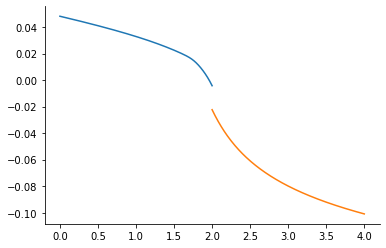

In [93]:
ϕ_bound = np.average(ϕ_list, axis=0, weights=πᵈ[:,-1])
plt.plot(y_grid[:numy_bar+1], ϕ)
plt.plot(y_grid[numy_bar:], ϕ_bound[numy_bar:])

In [94]:
yt, et, πᵈt, πᶜt, ιt, ht = simulate_jump(y_grid[:numy_bar+1], ems, πᶜ, πᵈ, ι, h, θ_list)

(0.0, 9.80082147966715)

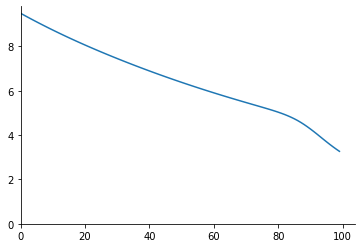

In [95]:
plt.plot(et[et>0])
plt.xlim(left=0)
plt.ylim(bottom=0)

In [91]:
ξₐ = 1/15_000
ξₘ = 0.002/η/10
ξ = 0.002
dmg_weight = np.array([0.475, 0.475, 0.05])
args = (δ, η, θ_list, γ1, γ2, γ3_list, dmg_weight, ς, ξₘ, ξₐ, ξ)
ϕ_avg, ems_avg, πᶜ_avg, ι_avg, πᵈ_avg, h_avg, ϕ_avg_list = solve_jump(y_grid, numy_bar, args, tol=3e-6)

episode: 1,	 ode error: 0.0017049711488100684,	 ft error: 0.0014433733128076528
episode: 2,	 ode error: 0.0014054245248626474,	 ft error: 0.0012754880675421994
episode: 3,	 ode error: 0.0013055882549496518,	 ft error: 0.001211747901989547
episode: 4,	 ode error: 0.0012388291908434286,	 ft error: 0.0011682626414294631
episode: 5,	 ode error: 0.0011873538699584383,	 ft error: 0.0011331590576324781
episode: 6,	 ode error: 0.0011454593854308285,	 ft error: 0.0011028833146214541
episode: 7,	 ode error: 0.0011102392010254977,	 ft error: 0.0010760623443626782
episode: 8,	 ode error: 0.001079996432309448,	 ft error: 0.0010518828400320867
episode: 9,	 ode error: 0.0010537810309676878,	 ft error: 0.0010301776224010187
episode: 10,	 ode error: 0.0010309035544245162,	 ft error: 0.0010104107882980618
episode: 11,	 ode error: 0.0010103383154710143,	 ft error: 0.0009924004703714285
episode: 12,	 ode error: 0.0009919608651092775,	 ft error: 0.0009758917915512685
episode: 13,	 ode error: 0.000974908467

episode: 105,	 ode error: 0.0004857967014038295,	 ft error: 0.0004844339312872389
episode: 106,	 ode error: 0.00048314118461390465,	 ft error: 0.00048245211416461886
episode: 107,	 ode error: 0.00048112004612650857,	 ft error: 0.00048008297892208435
episode: 108,	 ode error: 0.0004785269762224569,	 ft error: 0.000477007230989072
episode: 109,	 ode error: 0.00047577073434994395,	 ft error: 0.0004743816602572939
episode: 110,	 ode error: 0.000473109957781157,	 ft error: 0.0004718117200542179
episode: 111,	 ode error: 0.0004705474656842493,	 ft error: 0.00046991386509386696
episode: 112,	 ode error: 0.00046867453262806034,	 ft error: 0.000467582577253096
episode: 113,	 ode error: 0.00046618019580910706,	 ft error: 0.0004653851433297889
episode: 114,	 ode error: 0.00046373040017561333,	 ft error: 0.00046226471500180244
episode: 115,	 ode error: 0.00046113414591098596,	 ft error: 0.0004598010394142362
episode: 116,	 ode error: 0.0004585717761444324,	 ft error: 0.00045788419175117384
episode

episode: 218,	 ode error: 0.0002854909616008675,	 ft error: 0.00028472666659911755
episode: 219,	 ode error: 0.00028377529680445905,	 ft error: 0.00028349030691363075
episode: 220,	 ode error: 0.0002826604504894162,	 ft error: 0.00028201734304032777
episode: 221,	 ode error: 0.00028102890036814886,	 ft error: 0.0002805945012101611
episode: 222,	 ode error: 0.0002798436598977145,	 ft error: 0.0002790917648010094
episode: 223,	 ode error: 0.00027862618494668007,	 ft error: 0.0002776760608259182
episode: 224,	 ode error: 0.00027723711179793034,	 ft error: 0.00027631524580774836
episode: 225,	 ode error: 0.00027571101938864595,	 ft error: 0.00027514234199823206
episode: 226,	 ode error: 0.00027453862125636315,	 ft error: 0.00027425129530828096
episode: 227,	 ode error: 0.00027352046641642986,	 ft error: 0.0002736098039227373
episode: 228,	 ode error: 0.00027276239999889996,	 ft error: 0.0002729248518413182
episode: 229,	 ode error: 0.0002720712774380761,	 ft error: 0.0002722500385980246
ep

episode: 330,	 ode error: 0.00017917189644203562,	 ft error: 0.00017891189207898395
episode: 331,	 ode error: 0.0001784369151737313,	 ft error: 0.00017817117184140696
episode: 332,	 ode error: 0.00017768929332360214,	 ft error: 0.00017742090407055675
episode: 333,	 ode error: 0.0001769362871516403,	 ft error: 0.00017666891082579925
episode: 334,	 ode error: 0.00017618650070313384,	 ft error: 0.000175923672002809
episode: 335,	 ode error: 0.0001754482840778909,	 ft error: 0.0001751928207222725
episode: 336,	 ode error: 0.0001747282397507393,	 ft error: 0.00017448179960526575
episode: 337,	 ode error: 0.00017403007774010237,	 ft error: 0.00017379292047795908
episode: 338,	 ode error: 0.0001733540450916184,	 ft error: 0.0001731250142195338
episode: 339,	 ode error: 0.0001726970146044911,	 ft error: 0.0001724737585198875
episode: 340,	 ode error: 0.00017205320639715786,	 ft error: 0.00017183261557504142
episode: 341,	 ode error: 0.00017141537111980444,	 ft error: 0.00017119416691623962
epi

episode: 441,	 ode error: 0.00011663141044365472,	 ft error: 0.0001164674736630252
episode: 442,	 ode error: 0.00011619386136664739,	 ft error: 0.00011603042666998484
episode: 443,	 ode error: 0.0001157581053462687,	 ft error: 0.0001155951541683085
episode: 444,	 ode error: 0.00011532410265680242,	 ft error: 0.00011516162401347767
episode: 445,	 ode error: 0.00011489182944012682,	 ft error: 0.00011472982035395929
episode: 446,	 ode error: 0.00011446127841546554,	 ft error: 0.00011429974281440547
episode: 447,	 ode error: 0.00011403245645565303,	 ft error: 0.00011387140294775075
episode: 448,	 ode error: 0.00011360537988689312,	 ft error: 0.00011344481896826779
episode: 449,	 ode error: 0.00011318006867676658,	 ft error: 0.00011302000996103734
episode: 450,	 ode error: 0.00011275654072635387,	 ft error: 0.00011259699070625037
episode: 451,	 ode error: 0.00011233480730763281,	 ft error: 0.00011217576798979816
episode: 452,	 ode error: 0.00011191487033422902,	 ft error: 0.0001117563388852

episode: 557,	 ode error: 7.612379853598808e-05,	 ft error: 7.600246232128405e-05
episode: 558,	 ode error: 7.585025162589669e-05,	 ft error: 7.572917495394146e-05
episode: 559,	 ode error: 7.557779002881316e-05,	 ft error: 7.545697184310289e-05
episode: 560,	 ode error: 7.530640956590032e-05,	 ft error: 7.518584882887833e-05
episode: 561,	 ode error: 7.503610609200606e-05,	 ft error: 7.49158017833429e-05
episode: 562,	 ode error: 7.476687549318097e-05,	 ft error: 7.464682660875596e-05
episode: 563,	 ode error: 7.449871368463341e-05,	 ft error: 7.437891923529431e-05
episode: 564,	 ode error: 7.423161660847079e-05,	 ft error: 7.411207561938693e-05
episode: 565,	 ode error: 7.396558023280196e-05,	 ft error: 7.384629174195709e-05
episode: 566,	 ode error: 7.37006005492721e-05,	 ft error: 7.358156360761278e-05
episode: 567,	 ode error: 7.343667357322255e-05,	 ft error: 7.331788724305086e-05
episode: 568,	 ode error: 7.317379534157325e-05,	 ft error: 7.305525869684878e-05
episode: 569,	 ode

episode: 669,	 ode error: 5.133522529357027e-05,	 ft error: 5.1235753986689225e-05
episode: 670,	 ode error: 5.115858366107383e-05,	 ft error: 5.105922517734118e-05
episode: 671,	 ode error: 5.098258377006764e-05,	 ft error: 5.0883336880751716e-05
episode: 672,	 ode error: 5.080722232721853e-05,	 ft error: 5.070808582745279e-05
episode: 673,	 ode error: 5.0632496076747496e-05,	 ft error: 5.053346878491442e-05
episode: 674,	 ode error: 5.045840179957134e-05,	 ft error: 5.035948255835421e-05
episode: 675,	 ode error: 5.028493631413706e-05,	 ft error: 5.0186123989511465e-05
episode: 676,	 ode error: 5.011209647551925e-05,	 ft error: 5.00133899571098e-05
episode: 677,	 ode error: 4.9939879175503596e-05,	 ft error: 4.984127737620951e-05
episode: 678,	 ode error: 4.976828134213194e-05,	 ft error: 4.9669783198554494e-05
episode: 679,	 ode error: 4.959729993985265e-05,	 ft error: 4.949890441178588e-05
episode: 680,	 ode error: 4.942693196928374e-05,	 ft error: 4.932863803895626e-05
episode: 68

episode: 785,	 ode error: 3.4493308717531705e-05,	 ft error: 3.4402726464821676e-05
episode: 786,	 ode error: 3.437568308496599e-05,	 ft error: 3.428515811691735e-05
episode: 787,	 ode error: 3.425846436138811e-05,	 ft error: 3.4167996458903116e-05
episode: 788,	 ode error: 3.414165112292111e-05,	 ft error: 3.405124006858329e-05
episode: 789,	 ode error: 3.40252419517757e-05,	 ft error: 3.393488752794864e-05
episode: 790,	 ode error: 3.390923543377278e-05,	 ft error: 3.381893742368525e-05
episode: 791,	 ode error: 3.3793630159381226e-05,	 ft error: 3.370338834735957e-05
episode: 792,	 ode error: 3.367842472424252e-05,	 ft error: 3.358823889451634e-05
episode: 793,	 ode error: 3.356361772729609e-05,	 ft error: 3.347348766565006e-05
episode: 794,	 ode error: 3.344920777334341e-05,	 ft error: 3.335913326553419e-05
episode: 795,	 ode error: 3.333519347059361e-05,	 ft error: 3.324517430410012e-05
episode: 796,	 ode error: 3.3221573433195296e-05,	 ft error: 3.313160939576639e-05
episode: 797

episode: 899,	 ode error: 2.3393538183023237e-05,	 ft error: 2.3308257563331436e-05
episode: 900,	 ode error: 2.3314226330108274e-05,	 ft error: 2.3228982706582912e-05
episode: 901,	 ode error: 2.323518752885207e-05,	 ft error: 2.314998075979291e-05
episode: 902,	 ode error: 2.3156420827750773e-05,	 ft error: 2.3071250771615946e-05
episode: 903,	 ode error: 2.307792527815166e-05,	 ft error: 2.2992791794430405e-05
episode: 904,	 ode error: 2.299969993488349e-05,	 ft error: 2.291460288332085e-05
episode: 905,	 ode error: 2.292174385620869e-05,	 ft error: 2.2836683097280746e-05
episode: 906,	 ode error: 2.2844056103421767e-05,	 ft error: 2.2759031498241027e-05
episode: 907,	 ode error: 2.2766635741678395e-05,	 ft error: 2.26816471518565e-05
episode: 908,	 ode error: 2.2689481839014108e-05,	 ft error: 2.2604529126788824e-05
episode: 909,	 ode error: 2.2612593467039163e-05,	 ft error: 2.2527676495284754e-05
episode: 910,	 ode error: 2.2535969700708362e-05,	 ft error: 2.2451088332875457e-05


episode: 1013,	 ode error: 1.5902705901463948e-05,	 ft error: 1.5820848380023365e-05
episode: 1014,	 ode error: 1.5849127671093387e-05,	 ft error: 1.5767294041050633e-05
episode: 1015,	 ode error: 1.579573304527984e-05,	 ft error: 1.5713923214681163e-05
episode: 1016,	 ode error: 1.5742521386848205e-05,	 ft error: 1.566073526478029e-05
episode: 1017,	 ode error: 1.5689492061699267e-05,	 ft error: 1.560772955745693e-05
episode: 1018,	 ode error: 1.5636644437960322e-05,	 ft error: 1.5554905461156086e-05
episode: 1019,	 ode error: 1.5583977885899537e-05,	 ft error: 1.5502262346589468e-05
episode: 1020,	 ode error: 1.5531491778230278e-05,	 ft error: 1.544979958671237e-05
episode: 1021,	 ode error: 1.547918548983182e-05,	 ft error: 1.539751655681617e-05
episode: 1022,	 ode error: 1.5427058397703597e-05,	 ft error: 1.5345412634227656e-05
episode: 1023,	 ode error: 1.5375109881011497e-05,	 ft error: 1.529348719849407e-05
episode: 1024,	 ode error: 1.532333932125786e-05,	 ft error: 1.524173963

episode: 1128,	 ode error: 1.0801856883666514e-05,	 ft error: 1.0722224279719843e-05
episode: 1129,	 ode error: 1.0765720816207107e-05,	 ft error: 1.0686103562214852e-05
episode: 1130,	 ode error: 1.0729708003066668e-05,	 ft error: 1.0650106039983287e-05
episode: 1131,	 ode error: 1.0693818019082146e-05,	 ft error: 1.0614231288156677e-05
episode: 1132,	 ode error: 1.0658050440632985e-05,	 ft error: 1.0578478882976769e-05
episode: 1133,	 ode error: 1.0622404845232812e-05,	 ft error: 1.0542848402350646e-05
episode: 1134,	 ode error: 1.058688081176113e-05,	 ft error: 1.0507339425503786e-05
episode: 1135,	 ode error: 1.0551477920969212e-05,	 ft error: 1.0471951533141954e-05
episode: 1136,	 ode error: 1.0516195754634418e-05,	 ft error: 1.043668430710428e-05
episode: 1137,	 ode error: 1.0481033895797963e-05,	 ft error: 1.0401537331149643e-05
episode: 1138,	 ode error: 1.044599192942346e-05,	 ft error: 1.0366510189823338e-05
episode: 1139,	 ode error: 1.0411069441102058e-05,	 ft error: 1.0331

episode: 1240,	 ode error: 7.432351810918105e-06,	 ft error: 7.354117527169635e-06
episode: 1241,	 ode error: 7.407683752759021e-06,	 ft error: 7.329459425498008e-06
episode: 1242,	 ode error: 7.383099440764888e-06,	 ft error: 7.3048850314968074e-06
episode: 1243,	 ode error: 7.358598586806701e-06,	 ft error: 7.280394057271322e-06
episode: 1244,	 ode error: 7.3341809042016745e-06,	 ft error: 7.255986216152718e-06
episode: 1245,	 ode error: 7.309846106794593e-06,	 ft error: 7.231661222582379e-06
episode: 1246,	 ode error: 7.2855939103493896e-06,	 ft error: 7.207418791926878e-06
episode: 1247,	 ode error: 7.261424030591073e-06,	 ft error: 7.183258640593623e-06
episode: 1248,	 ode error: 7.237336185284362e-06,	 ft error: 7.159180485892073e-06
episode: 1249,	 ode error: 7.213330092278002e-06,	 ft error: 7.1351840466119904e-06
episode: 1250,	 ode error: 7.189405471518776e-06,	 ft error: 7.111269042028856e-06
episode: 1251,	 ode error: 7.165562042826617e-06,	 ft error: 7.087435192736543e-06


episode: 1352,	 ode error: 5.130273427283419e-06,	 ft error: 5.052945614286708e-06
episode: 1353,	 ode error: 5.1134038065852325e-06,	 ft error: 5.036082442617477e-06
episode: 1354,	 ode error: 5.096591189508596e-06,	 ft error: 5.019276249444242e-06
episode: 1355,	 ode error: 5.0798353808329325e-06,	 ft error: 5.002526839830343e-06
episode: 1356,	 ode error: 5.063136186121979e-06,	 ft error: 4.985834019232324e-06
episode: 1357,	 ode error: 5.0464934117387455e-06,	 ft error: 4.969197593962527e-06
episode: 1358,	 ode error: 5.029906863997452e-06,	 ft error: 4.952617370819016e-06
episode: 1359,	 ode error: 5.013376350514339e-06,	 ft error: 4.936093157178098e-06
episode: 1360,	 ode error: 4.99690167908302e-06,	 ft error: 4.919624760971186e-06
episode: 1361,	 ode error: 4.980482658220055e-06,	 ft error: 4.903211991170535e-06
episode: 1362,	 ode error: 4.9641190975116805e-06,	 ft error: 4.886854657141597e-06
episode: 1363,	 ode error: 4.947810806877413e-06,	 ft error: 4.870552569128754e-06
e

episode: 1468,	 ode error: 3.5086599092212832e-06,	 ft error: 3.43193541916161e-06
episode: 1469,	 ode error: 3.49725742090684e-06,	 ft error: 3.420537037085447e-06
episode: 1470,	 ode error: 3.485893272936317e-06,	 ft error: 3.4091769797924463e-06
episode: 1471,	 ode error: 3.4745673351371494e-06,	 ft error: 3.39785511692392e-06
episode: 1472,	 ode error: 3.4632794777994004e-06,	 ft error: 3.3865713187688127e-06
episode: 1473,	 ode error: 3.452029571360477e-06,	 ft error: 3.3753254561943078e-06
episode: 1474,	 ode error: 3.4408174874203754e-06,	 ft error: 3.3641174005070535e-06
episode: 1475,	 ode error: 3.4296430975935127e-06,	 ft error: 3.3529470233837717e-06
episode: 1476,	 ode error: 3.4185062737579833e-06,	 ft error: 3.341814196917518e-06
episode: 1477,	 ode error: 3.4074068887211513e-06,	 ft error: 3.3307187936639413e-06
episode: 1478,	 ode error: 3.3963448152250037e-06,	 ft error: 3.3196606866644127e-06
episode: 1479,	 ode error: 3.3853199267651563e-06,	 ft error: 3.30863974914

episode: 59,	 ode error: 0.0006362752361045831,	 ft error: 0.000633666035314053
episode: 60,	 ode error: 0.0006320791039853842,	 ft error: 0.0006295203298110029
episode: 61,	 ode error: 0.0006279402596332513,	 ft error: 0.0006254292447288359
episode: 62,	 ode error: 0.0006238562160119524,	 ft error: 0.000621325912500322
episode: 63,	 ode error: 0.0006198280486476649,	 ft error: 0.000617340425354956
episode: 64,	 ode error: 0.0006158632564548116,	 ft error: 0.0006134319114729492
episode: 65,	 ode error: 0.0006119260072621371,	 ft error: 0.0006095580071185588
episode: 66,	 ode error: 0.0006080798629629812,	 ft error: 0.000605702239180432
episode: 67,	 ode error: 0.0006042379414564379,	 ft error: 0.000601905692498711
episode: 68,	 ode error: 0.000600461435835488,	 ft error: 0.0005982829754206642
episode: 69,	 ode error: 0.0005967437790448456,	 ft error: 0.0005944975645134331
episode: 70,	 ode error: 0.0005930504088049878,	 ft error: 0.0005908468536360591
episode: 71,	 ode error: 0.0005894

episode: 165,	 ode error: 0.0003586944848696247,	 ft error: 0.00035780750542386647
episode: 166,	 ode error: 0.00035685724325177097,	 ft error: 0.00035597139042536224
episode: 167,	 ode error: 0.00035502419059668525,	 ft error: 0.0003541393843220844
episode: 168,	 ode error: 0.00035319523985385905,	 ft error: 0.0003523114119441858
episode: 169,	 ode error: 0.00035137031775100806,	 ft error: 0.0003504874116218651
episode: 170,	 ode error: 0.0003495493644911033,	 ft error: 0.00034866733484332596
episode: 171,	 ode error: 0.0003477323333926488,	 ft error: 0.00034685114585239024
episode: 172,	 ode error: 0.0003459191904793265,	 ft error: 0.00034503882119975987
episode: 173,	 ode error: 0.0003441099140233518,	 ft error: 0.0003432303492609141
episode: 174,	 ode error: 0.00034230449404871533,	 ft error: 0.00034142572970730783
episode: 175,	 ode error: 0.0003405029317993082,	 ft error: 0.0003396249729519426
episode: 176,	 ode error: 0.00033870523917798006,	 ft error: 0.00033782809957213133
epi

episode: 275,	 ode error: 0.00019094215675482054,	 ft error: 0.00019038267723680188
episode: 276,	 ode error: 0.00018980286763096196,	 ft error: 0.00018925195434641348
episode: 277,	 ode error: 0.00018867082213341099,	 ft error: 0.00018812600579456534
episode: 278,	 ode error: 0.00018754576741350103,	 ft error: 0.00018700727877546397
episode: 279,	 ode error: 0.0001864275309279539,	 ft error: 0.0001858948496785695
episode: 280,	 ode error: 0.00018531601894076067,	 ft error: 0.00018478883655139816
episode: 281,	 ode error: 0.00018421117850101962,	 ft error: 0.00018368938552155065
episode: 282,	 ode error: 0.00018311297276902238,	 ft error: 0.0001825965374718334
episode: 283,	 ode error: 0.00018202136937061904,	 ft error: 0.00018151027906733452
episode: 284,	 ode error: 0.00018093633625317974,	 ft error: 0.00018043057822198413
episode: 285,	 ode error: 0.00017985784069373832,	 ft error: 0.0001793573969058789
episode: 286,	 ode error: 0.00017878584934023756,	 ft error: 0.00017829069623722

episode: 387,	 ode error: 9.812712971742424e-05,	 ft error: 9.787275933685151e-05
episode: 388,	 ode error: 9.755506389503275e-05,	 ft error: 9.730333261207444e-05
episode: 389,	 ode error: 9.698728967148622e-05,	 ft error: 9.673777634701397e-05
episode: 390,	 ode error: 9.64233830134983e-05,	 ft error: 9.617582769387105e-05
episode: 391,	 ode error: 9.586307145715233e-05,	 ft error: 9.56173187906482e-05
episode: 392,	 ode error: 9.530618468908344e-05,	 ft error: 9.506214128885324e-05
episode: 393,	 ode error: 9.475261558623989e-05,	 ft error: 9.451022378819304e-05
episode: 394,	 ode error: 9.420229455548627e-05,	 ft error: 9.396151713104521e-05
episode: 395,	 ode error: 9.365517386097401e-05,	 ft error: 9.341598524508407e-05
episode: 396,	 ode error: 9.311121839537329e-05,	 ft error: 9.287359967735202e-05
episode: 397,	 ode error: 9.257040034226904e-05,	 ft error: 9.233433641374819e-05
episode: 398,	 ode error: 9.203269611313776e-05,	 ft error: 9.179817405153187e-05
episode: 399,	 ode

episode: 498,	 ode error: 5.1486259973375944e-05,	 ft error: 5.119164282849087e-05
episode: 499,	 ode error: 5.118476449930622e-05,	 ft error: 5.0891190314303336e-05
episode: 500,	 ode error: 5.088492380817043e-05,	 ft error: 5.059238590207164e-05
episode: 501,	 ode error: 5.058672945105981e-05,	 ft error: 5.029522119076128e-05
episode: 502,	 ode error: 5.029017301368382e-05,	 ft error: 4.9999687813060786e-05
episode: 503,	 ode error: 4.9995246116111484e-05,	 ft error: 4.9705777435358575e-05
episode: 504,	 ode error: 4.970194041220891e-05,	 ft error: 4.941348175697968e-05
episode: 505,	 ode error: 4.941024758918836e-05,	 ft error: 4.9122792510185774e-05
episode: 506,	 ode error: 4.9120159367368414e-05,	 ft error: 4.8833701458856724e-05
episode: 507,	 ode error: 4.88316674995392e-05,	 ft error: 4.854620039936956e-05
episode: 508,	 ode error: 4.8544763770640674e-05,	 ft error: 4.826028115914131e-05
episode: 509,	 ode error: 4.825943999746136e-05,	 ft error: 4.797593559676776e-05
episode:

episode: 609,	 ode error: 2.7949592950906433e-05,	 ft error: 2.8900129729510227e-05
episode: 610,	 ode error: 2.787678999272532e-05,	 ft error: 2.88262408672015e-05
episode: 611,	 ode error: 2.780416115995903e-05,	 ft error: 2.875253415440815e-05
episode: 612,	 ode error: 2.77317060732401e-05,	 ft error: 2.8679009133174747e-05
episode: 613,	 ode error: 2.7659424353942936e-05,	 ft error: 2.860566534874931e-05
episode: 614,	 ode error: 2.7587315624184264e-05,	 ft error: 2.8532502346830895e-05
episode: 615,	 ode error: 2.7515379506826094e-05,	 ft error: 2.8459519673650534e-05
episode: 616,	 ode error: 2.7443615625467773e-05,	 ft error: 2.8386716877902562e-05
episode: 617,	 ode error: 2.7372023604447127e-05,	 ft error: 2.8314093510108572e-05
episode: 618,	 ode error: 2.7300603068841758e-05,	 ft error: 2.8241649120639794e-05
episode: 619,	 ode error: 2.7229353644459128e-05,	 ft error: 2.8169383263545088e-05
episode: 620,	 ode error: 2.715827495784222e-05,	 ft error: 2.80972954924801e-05
epi

episode: 715,	 ode error: 2.1057037247731373e-05,	 ft error: 2.2481378320615697e-05
episode: 716,	 ode error: 2.0999466186199866e-05,	 ft error: 2.242285627181151e-05
episode: 717,	 ode error: 2.0942036985414762e-05,	 ft error: 2.2364480268174024e-05
episode: 718,	 ode error: 2.0884749324175285e-05,	 ft error: 2.230624994153709e-05
episode: 719,	 ode error: 2.082760288196509e-05,	 ft error: 2.224816491899299e-05
episode: 720,	 ode error: 2.0770597338945972e-05,	 ft error: 2.2190224831485084e-05
episode: 721,	 ode error: 2.0713732375956596e-05,	 ft error: 2.2132429307250567e-05
episode: 722,	 ode error: 2.0657007674510457e-05,	 ft error: 2.207477798010088e-05
episode: 723,	 ode error: 2.0600422916800632e-05,	 ft error: 2.2017270481395717e-05
episode: 724,	 ode error: 2.0543977785684677e-05,	 ft error: 2.1959906447872417e-05
episode: 725,	 ode error: 2.0487671964693275e-05,	 ft error: 2.1902685516395536e-05
episode: 726,	 ode error: 2.043150513801202e-05,	 ft error: 2.1845607328871884e-0

episode: 829,	 ode error: 1.5333974769851666e-05,	 ft error: 1.6680476683262706e-05
episode: 830,	 ode error: 1.5290627672335708e-05,	 ft error: 1.663682981717605e-05
episode: 831,	 ode error: 1.524738886522775e-05,	 ft error: 1.6593298042740883e-05
episode: 832,	 ode error: 1.5204258082987922e-05,	 ft error: 1.6549880959293904e-05
episode: 833,	 ode error: 1.5161235060974347e-05,	 ft error: 1.650657816072478e-05
episode: 834,	 ode error: 1.5118319535445494e-05,	 ft error: 1.646338923820545e-05
episode: 835,	 ode error: 1.5075511243577068e-05,	 ft error: 1.642031377770368e-05
episode: 836,	 ode error: 1.5032809923464424e-05,	 ft error: 1.6377351363244346e-05
episode: 837,	 ode error: 1.4990215314151183e-05,	 ft error: 1.6334501572676706e-05
episode: 838,	 ode error: 1.4947727155605034e-05,	 ft error: 1.6291763985156842e-05
episode: 839,	 ode error: 1.4905345188756899e-05,	 ft error: 1.6249138173884958e-05
episode: 840,	 ode error: 1.4863069155488055e-05,	 ft error: 1.6206623711459887e-

KeyboardInterrupt: 

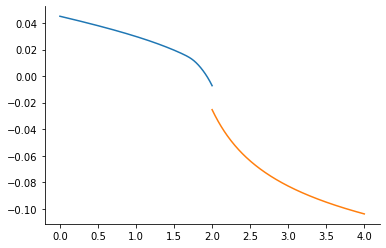

In [96]:
ϕ_bound = np.average(ϕ_avg_list, axis=0, weights=πᵈ_avg[:,-1])
plt.plot(y_grid[:numy_bar+1], ϕ_avg)
plt.plot(y_grid[numy_bar:], ϕ_bound[numy_bar:])

In [97]:
yt_avg, et_avg, πᵈt_avg, πᶜt_avg, ιt_avg, ht_avg = simulate_jump(y_grid[:numy_bar+1], ems_avg, πᶜ_avg, πᵈ_avg, ι_avg, h_avg, θ_list)

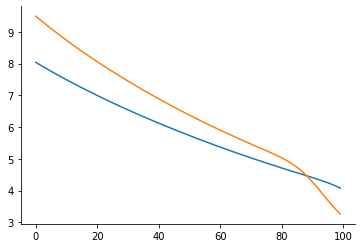

In [98]:
plt.plot(et_avg)
plt.plot(et[et>0])

(0.0, 100.0)

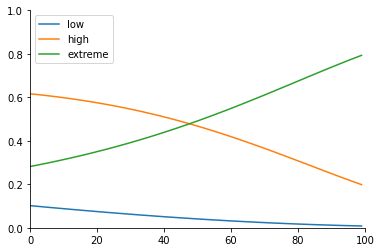

In [99]:
plt.plot(πᵈt_avg[:,0],label='low')
plt.plot(πᵈt_avg[:,1], label="high")
plt.plot(πᵈt_avg[:,2], label="extreme")
plt.legend()
plt.ylim(0,1)
plt.xlim(0,100)

In [100]:
πᵈt_avg[0,2]

0.2817533876076594

# partition: carbon and temp

In [71]:
ξₐ = 1/15_000
ξₘ = 0.002/η/10
dmg_weight = np.array([0.475, 0.475, 0.05])
args = (δ, η, θtemp_list, γ1, γ2, γ3_list, dmg_weight, ς, ξₘ, ξₐ, ξ)
ϕ_temp, ems_temp, πᶜ_temp, ι_temp, πᵈ_temp, h_temp, ϕ_temp_list = solve_jump(y_grid, numy_bar, args, tol=2e-6)

episode: 1,	 ode error: 0.0017021411232569473,	 ft error: 0.0014383713363495634
episode: 2,	 ode error: 0.0014158686615702877,	 ft error: 0.001287653186884599
episode: 3,	 ode error: 0.0013096579044613093,	 ft error: 0.0012207845458497336
episode: 4,	 ode error: 0.0012432903514678368,	 ft error: 0.001176078741066634
episode: 5,	 ode error: 0.0011933232164357572,	 ft error: 0.0011409228034786562
episode: 6,	 ode error: 0.00115206753531346,	 ft error: 0.0011106154925161205
episode: 7,	 ode error: 0.001117693700571011,	 ft error: 0.0010839129216590137
episode: 8,	 ode error: 0.0010880589882688047,	 ft error: 0.0010600729415743524
episode: 9,	 ode error: 0.001062260310276432,	 ft error: 0.0010384883552145932
episode: 10,	 ode error: 0.0010394967294529553,	 ft error: 0.0010188816606710343
episode: 11,	 ode error: 0.001018893889510848,	 ft error: 0.0010008815985565293
episode: 12,	 ode error: 0.001000397948536954,	 ft error: 0.0009844212686748507
episode: 13,	 ode error: 0.000983113374607831

episode: 190,	 ode error: 0.0003281302309381662,	 ft error: 0.0003267420205538737
episode: 191,	 ode error: 0.00032555293567496525,	 ft error: 0.00032479223453947087
episode: 192,	 ode error: 0.00032389445218346214,	 ft error: 0.00032331492109465476
episode: 193,	 ode error: 0.00032248557835662644,	 ft error: 0.00032195690996943604
episode: 194,	 ode error: 0.00032113720949291356,	 ft error: 0.00032274927312767043
episode: 195,	 ode error: 0.0003210851845020826,	 ft error: 0.00032009031727652426
episode: 196,	 ode error: 0.0003191218571216433,	 ft error: 0.00031938187861543327
episode: 197,	 ode error: 0.00031839347659786657,	 ft error: 0.00031766344179705774
episode: 198,	 ode error: 0.0003167105995403093,	 ft error: 0.0003163551515041052
episode: 199,	 ode error: 0.0003154543495751662,	 ft error: 0.0003149360440724003
episode: 200,	 ode error: 0.00031370271799108934,	 ft error: 0.00031342351356385134
episode: 201,	 ode error: 0.0003134578808185323,	 ft error: 0.0003118108139099398
ep

episode: 294,	 ode error: 0.00021024012843582967,	 ft error: 0.00020949722297244439
episode: 295,	 ode error: 0.00020924317400326266,	 ft error: 0.00020877318832819108
episode: 296,	 ode error: 0.00020828527491255442,	 ft error: 0.00020804662924365133
episode: 297,	 ode error: 0.00020757158923940579,	 ft error: 0.00021048733203010245
episode: 298,	 ode error: 0.00020848936838004778,	 ft error: 0.00020763463482511663
episode: 299,	 ode error: 0.00020691550490867282,	 ft error: 0.0002077019204664114
episode: 300,	 ode error: 0.00020679341116832024,	 ft error: 0.00020627500483145583
episode: 301,	 ode error: 0.0002056219632819644,	 ft error: 0.00020543361652629322
episode: 302,	 ode error: 0.0002048965272017834,	 ft error: 0.00020448769184088408
episode: 303,	 ode error: 0.0002037484656113688,	 ft error: 0.00020348067025529698
episode: 304,	 ode error: 0.0002029195386920663,	 ft error: 0.000202421591210325
episode: 305,	 ode error: 0.00020237074500406376,	 ft error: 0.00020133895825884263

episode: 399,	 ode error: 0.00014002733232394097,	 ft error: 0.00013870708091529016
episode: 400,	 ode error: 0.00013992401239268175,	 ft error: 0.0001401103573644517
episode: 401,	 ode error: 0.0001388272867881901,	 ft error: 0.00013762228652840214
episode: 402,	 ode error: 0.00013862861523136652,	 ft error: 0.00013786286534651915
episode: 403,	 ode error: 0.00013783326745412446,	 ft error: 0.0001365616911167683
episode: 404,	 ode error: 0.00013746466839495918,	 ft error: 0.0001363447466769252
episode: 405,	 ode error: 0.0001368197243979566,	 ft error: 0.00013553451014856888
episode: 406,	 ode error: 0.00013636498299965112,	 ft error: 0.00013513225475041135
episode: 407,	 ode error: 0.00013577414356088797,	 ft error: 0.00013452713507585795
episode: 408,	 ode error: 0.00013525709394478377,	 ft error: 0.00013408407782305085
episode: 409,	 ode error: 0.00013466287594471479,	 ft error: 0.00013355141567685433
episode: 410,	 ode error: 0.0001340850683469011,	 ft error: 0.0001331607581736329

episode: 503,	 ode error: 9.471551157431751e-05,	 ft error: 9.4546800449453e-05
episode: 504,	 ode error: 9.437259000279056e-05,	 ft error: 9.420344394541388e-05
episode: 505,	 ode error: 9.402961780158661e-05,	 ft error: 9.386018655466177e-05
episode: 506,	 ode error: 9.368663569430736e-05,	 ft error: 9.351707891779952e-05
episode: 507,	 ode error: 9.334373457704889e-05,	 ft error: 9.317421538120967e-05
episode: 508,	 ode error: 9.300104680236038e-05,	 ft error: 9.283172537048283e-05
episode: 509,	 ode error: 9.26587356941392e-05,	 ft error: 9.248976340049213e-05
episode: 510,	 ode error: 9.231698411265319e-05,	 ft error: 9.214849849346433e-05
episode: 511,	 ode error: 9.197598287809846e-05,	 ft error: 9.180810372104906e-05
episode: 512,	 ode error: 9.16359197655368e-05,	 ft error: 9.146874648993664e-05
episode: 513,	 ode error: 9.129696967455402e-05,	 ft error: 9.113058006484284e-05
episode: 514,	 ode error: 9.095928642520077e-05,	 ft error: 9.079373668202662e-05
episode: 515,	 ode e

episode: 609,	 ode error: 6.470981824542967e-05,	 ft error: 6.457647107806219e-05
episode: 610,	 ode error: 6.448375569687687e-05,	 ft error: 6.435038140876112e-05
episode: 611,	 ode error: 6.425809294261918e-05,	 ft error: 6.412475474511237e-05
episode: 612,	 ode error: 6.403285101889045e-05,	 ft error: 6.389961112377349e-05
episode: 613,	 ode error: 6.380805704208302e-05,	 ft error: 6.367497575892704e-05
episode: 614,	 ode error: 6.358374344368615e-05,	 ft error: 6.345087834006466e-05
episode: 615,	 ode error: 6.335994714288585e-05,	 ft error: 6.322735227668834e-05
episode: 616,	 ode error: 6.313670866053768e-05,	 ft error: 6.300443389409272e-05
episode: 617,	 ode error: 6.291407118359609e-05,	 ft error: 6.278216159246361e-05
episode: 618,	 ode error: 6.269207959511971e-05,	 ft error: 6.256057497701825e-05
episode: 619,	 ode error: 6.24707794811744e-05,	 ft error: 6.233971397954138e-05
episode: 620,	 ode error: 6.225021614074866e-05,	 ft error: 6.211961798547236e-05
episode: 621,	 od

episode: 715,	 ode error: 4.483335313452128e-05,	 ft error: 4.4723330573671435e-05
episode: 716,	 ode error: 4.468053201711641e-05,	 ft error: 4.457059161667998e-05
episode: 717,	 ode error: 4.452825852104946e-05,	 ft error: 4.4418396279698645e-05
episode: 718,	 ode error: 4.437652381818582e-05,	 ft error: 4.4266736640060277e-05
episode: 719,	 ode error: 4.422531946383901e-05,	 ft error: 4.41156051457503e-05
episode: 720,	 ode error: 4.407463750717266e-05,	 ft error: 4.3964994707023274e-05
episode: 721,	 ode error: 4.3924470584913574e-05,	 ft error: 4.381489877247624e-05
episode: 722,	 ode error: 4.377481199560498e-05,	 ft error: 4.3665311389324654e-05
episode: 723,	 ode error: 4.362565575829862e-05,	 ft error: 4.351622725091061e-05
episode: 724,	 ode error: 4.347699665679884e-05,	 ft error: 4.336764173005585e-05
episode: 725,	 ode error: 4.332883026955626e-05,	 ft error: 4.3219550901543724e-05
episode: 726,	 ode error: 4.3181152984917586e-05,	 ft error: 4.307195155333714e-05
episode: 

episode: 820,	 ode error: 3.135314004968368e-05,	 ft error: 3.1250151125405044e-05
episode: 821,	 ode error: 3.124689518220719e-05,	 ft error: 3.1143948546382326e-05
episode: 822,	 ode error: 3.114101391576399e-05,	 ft error: 3.103810929496835e-05
episode: 823,	 ode error: 3.103549461755341e-05,	 ft error: 3.0932631890750094e-05
episode: 824,	 ode error: 3.093033603727947e-05,	 ft error: 3.082751518073783e-05
episode: 825,	 ode error: 3.082553722891278e-05,	 ft error: 3.072275826567402e-05
episode: 826,	 ode error: 3.0721097459940555e-05,	 ft error: 3.061836041623467e-05
episode: 827,	 ode error: 3.06170161154546e-05,	 ft error: 3.0514320986570663e-05
episode: 828,	 ode error: 3.0513292602953935e-05,	 ft error: 3.0410639330994787e-05
episode: 829,	 ode error: 3.0409926267075966e-05,	 ft error: 3.0307314728023987e-05
episode: 830,	 ode error: 3.030691631428933e-05,	 ft error: 3.0204346317929308e-05
episode: 831,	 ode error: 3.0204261757142475e-05,	 ft error: 3.010173305599088e-05
episod

episode: 926,	 ode error: 2.189532601555371e-05,	 ft error: 2.1796715653892483e-05
episode: 927,	 ode error: 2.1821478220889097e-05,	 ft error: 2.1722907635422322e-05
episode: 928,	 ode error: 2.1747891298300377e-05,	 ft error: 2.164935940946374e-05
episode: 929,	 ode error: 2.1674564230512636e-05,	 ft error: 2.1576069923849122e-05
episode: 930,	 ode error: 2.1601495816836696e-05,	 ft error: 2.1503037971002763e-05
episode: 931,	 ode error: 2.1528684699682193e-05,	 ft error: 2.143026221236577e-05
episode: 932,	 ode error: 2.1456129395139127e-05,	 ft error: 2.135774120531897e-05
episode: 933,	 ode error: 2.1383828323306032e-05,	 ft error: 2.12854734323494e-05
episode: 934,	 ode error: 2.1311779843109454e-05,	 ft error: 2.1213457330239903e-05
episode: 935,	 ode error: 2.1239982281841632e-05,	 ft error: 2.114169131662199e-05
episode: 936,	 ode error: 2.1168433964146964e-05,	 ft error: 2.1070173814955833e-05
episode: 937,	 ode error: 2.109713323767174e-05,	 ft error: 2.0998903275370094e-05


episode: 1033,	 ode error: 1.5272749147739813e-05,	 ft error: 1.5177093685333118e-05
episode: 1034,	 ode error: 1.5221577786087904e-05,	 ft error: 1.5125945836807117e-05
episode: 1035,	 ode error: 1.5170578950310333e-05,	 ft error: 1.5074970751705052e-05
episode: 1036,	 ode error: 1.511975225483369e-05,	 ft error: 1.502416802225126e-05
episode: 1037,	 ode error: 1.506909733066115e-05,	 ft error: 1.4973537253784586e-05
episode: 1038,	 ode error: 1.5018613820512862e-05,	 ft error: 1.4923078061959694e-05
episode: 1039,	 ode error: 1.4968301375722633e-05,	 ft error: 1.4872790068676256e-05
episode: 1040,	 ode error: 1.4918159651054579e-05,	 ft error: 1.482267289805439e-05
episode: 1041,	 ode error: 1.486818830023686e-05,	 ft error: 1.4772726172178804e-05
episode: 1042,	 ode error: 1.481838697104461e-05,	 ft error: 1.472294950702798e-05
episode: 1043,	 ode error: 1.476875530132839e-05,	 ft error: 1.467334250863465e-05
episode: 1044,	 ode error: 1.4719292915499425e-05,	 ft error: 1.4623904770

episode: 1139,	 ode error: 1.0714417283198439e-05,	 ft error: 1.0620728544269431e-05
episode: 1140,	 ode error: 1.0678779472510702e-05,	 ft error: 1.0585104180278287e-05
episode: 1141,	 ode error: 1.0643259895211647e-05,	 ft error: 1.0549598318647843e-05
episode: 1142,	 ode error: 1.0607857999787363e-05,	 ft error: 1.0514210440395097e-05
episode: 1143,	 ode error: 1.0572573297279691e-05,	 ft error: 1.0478940081770638e-05
episode: 1144,	 ode error: 1.0537405361385759e-05,	 ft error: 1.0443786834628729e-05
episode: 1145,	 ode error: 1.0502353827361957e-05,	 ft error: 1.0408750344091205e-05
episode: 1146,	 ode error: 1.046741838748764e-05,	 ft error: 1.037383030498551e-05
episode: 1147,	 ode error: 1.0432598786317294e-05,	 ft error: 1.0339026456108551e-05
episode: 1148,	 ode error: 1.0397894812380214e-05,	 ft error: 1.0304338573958554e-05
episode: 1149,	 ode error: 1.0363306291475143e-05,	 ft error: 1.0269766465495489e-05
episode: 1150,	 ode error: 1.0328833076760665e-05,	 ft error: 1.023

episode: 1246,	 ode error: 7.511182628612946e-06,	 ft error: 7.41882810196178e-06
episode: 1247,	 ode error: 7.486360543905077e-06,	 ft error: 7.394020746440133e-06
episode: 1248,	 ode error: 7.461625360007324e-06,	 ft error: 7.369299983225885e-06
episode: 1249,	 ode error: 7.4369772103710955e-06,	 ft error: 7.34466587291871e-06
episode: 1250,	 ode error: 7.412416152177107e-06,	 ft error: 7.320118407862694e-06
episode: 1251,	 ode error: 7.3879421615311676e-06,	 ft error: 7.295657510018409e-06
episode: 1252,	 ode error: 7.363555132614496e-06,	 ft error: 7.2712830292744526e-06
episode: 1253,	 ode error: 7.339254876027163e-06,	 ft error: 7.2469947433780515e-06
episode: 1254,	 ode error: 7.315041119868395e-06,	 ft error: 7.222792358235752e-06
episode: 1255,	 ode error: 7.290913510337653e-06,	 ft error: 7.1986755098100525e-06
episode: 1256,	 ode error: 7.266871615204296e-06,	 ft error: 7.174643766177935e-06
episode: 1257,	 ode error: 7.242914926211693e-06,	 ft error: 7.150696631115968e-06
e

episode: 1353,	 ode error: 5.281523200981989e-06,	 ft error: 5.190127585023389e-06
episode: 1354,	 ode error: 5.264294185195785e-06,	 ft error: 5.17290144603592e-06
episode: 1355,	 ode error: 5.247127358048043e-06,	 ft error: 5.155736816595906e-06
episode: 1356,	 ode error: 5.230022063853297e-06,	 ft error: 5.138633083212607e-06
episode: 1357,	 ode error: 5.212977568464752e-06,	 ft error: 5.121589566337015e-06
episode: 1358,	 ode error: 5.1959930677460305e-06,	 ft error: 5.104605527046317e-06
episode: 1359,	 ode error: 5.1790676953428335e-06,	 ft error: 5.087680174977368e-06
episode: 1360,	 ode error: 5.1622005337540605e-06,	 ft error: 5.070812677647937e-06
episode: 1361,	 ode error: 5.145390625896991e-06,	 ft error: 5.0540021716051955e-06
episode: 1362,	 ode error: 5.128636989236825e-06,	 ft error: 5.037247773458561e-06
episode: 1363,	 ode error: 5.1119386294384145e-06,	 ft error: 5.020548593850002e-06
episode: 1364,	 ode error: 5.095294557394634e-06,	 ft error: 5.003903750753584e-06


episode: 1459,	 ode error: 3.7399468525408167e-06,	 ft error: 3.6491042001059646e-06
episode: 1460,	 ode error: 3.7278656585654733e-06,	 ft error: 3.6370276425510646e-06
episode: 1461,	 ode error: 3.7158283300176963e-06,	 ft error: 3.624994507067658e-06
episode: 1462,	 ode error: 3.703834537084486e-06,	 ft error: 3.6130044598255604e-06
episode: 1463,	 ode error: 3.6918838119002952e-06,	 ft error: 3.601057046211572e-06
episode: 1464,	 ode error: 3.6799755592239287e-06,	 ft error: 3.5891517019317107e-06
episode: 1465,	 ode error: 3.668109073795751e-06,	 ft error: 3.577287769641428e-06
episode: 1466,	 ode error: 3.6562835634774884e-06,	 ft error: 3.5654645198085477e-06
episode: 1467,	 ode error: 3.6444981759032203e-06,	 ft error: 3.553681176549084e-06
episode: 1468,	 ode error: 3.6327520312036355e-06,	 ft error: 3.541936944943351e-06
episode: 1469,	 ode error: 3.621044252572511e-06,	 ft error: 3.5302310407806887e-06
episode: 1470,	 ode error: 3.6093740008733607e-06,	 ft error: 3.518562718

episode: 1565,	 ode error: 2.6602400179169235e-06,	 ft error: 2.5697528007832355e-06
episode: 1566,	 ode error: 2.6517815648741247e-06,	 ft error: 2.5612951591128903e-06
episode: 1567,	 ode error: 2.6433508650881583e-06,	 ft error: 2.552865255670926e-06
episode: 1568,	 ode error: 2.634947417780786e-06,	 ft error: 2.5444626390360345e-06
episode: 1569,	 ode error: 2.6265707136633246e-06,	 ft error: 2.5360868527677756e-06
episode: 1570,	 ode error: 2.6182202481451556e-06,	 ft error: 2.5277374459536928e-06
episode: 1571,	 ode error: 2.6098955343276716e-06,	 ft error: 2.519413986231308e-06
episode: 1572,	 ode error: 2.6015961179376434e-06,	 ft error: 2.511116072463164e-06
episode: 1573,	 ode error: 2.5933215929613068e-06,	 ft error: 2.502843347504391e-06
episode: 1574,	 ode error: 2.5850716138152907e-06,	 ft error: 2.4945955109934026e-06
episode: 1575,	 ode error: 2.57684591009979e-06,	 ft error: 2.4863723297139746e-06
episode: 1576,	 ode error: 2.5686442957226696e-06,	 ft error: 2.47817364

episode: 106,	 ode error: 0.000489720661285072,	 ft error: 0.0004883970540272657
episode: 107,	 ode error: 0.0004871473977826823,	 ft error: 0.0004858391749067275
episode: 108,	 ode error: 0.0004845952102912898,	 ft error: 0.00048330187801812663
episode: 109,	 ode error: 0.00048206382479882106,	 ft error: 0.0004807850908000964
episode: 110,	 ode error: 0.00047955295929524074,	 ft error: 0.0004782885726757266
episode: 111,	 ode error: 0.00047706231624787456,	 ft error: 0.000475812010390086
episode: 112,	 ode error: 0.0004745915900594141,	 ft error: 0.00047335508656206476
episode: 113,	 ode error: 0.00047214074736082244,	 ft error: 0.0004708260177878921
episode: 114,	 ode error: 0.00046971128378500574,	 ft error: 0.0004684086327529554
episode: 115,	 ode error: 0.0004673020774209113,	 ft error: 0.00046601362422940323
episode: 116,	 ode error: 0.00046491304293970665,	 ft error: 0.00046364179299007485
episode: 117,	 ode error: 0.0004625433504640359,	 ft error: 0.0004612891514778802
episode:

episode: 300,	 ode error: 0.00016804856154348908,	 ft error: 0.00016762790762856844
episode: 301,	 ode error: 0.0001670586858968701,	 ft error: 0.0001666430296929968
episode: 302,	 ode error: 0.00016607478397041983,	 ft error: 0.00016566410381455937
episode: 303,	 ode error: 0.00016509682102586838,	 ft error: 0.00016469109578571192
episode: 304,	 ode error: 0.0001641247623229376,	 ft error: 0.00016372397139007475
episode: 305,	 ode error: 0.00016315857312989624,	 ft error: 0.00016276269640624896
episode: 306,	 ode error: 0.00016219821873329787,	 ft error: 0.0001618072366482935
episode: 307,	 ode error: 0.0001612436644474667,	 ft error: 0.00016085755791907241
episode: 308,	 ode error: 0.00016029487562361556,	 ft error: 0.00015991362606955958
episode: 309,	 ode error: 0.00015935181765844362,	 ft error: 0.0001589754069759632
episode: 310,	 ode error: 0.0001584144560026298,	 ft error: 0.00015804286654960237
episode: 311,	 ode error: 0.00015748275616900862,	 ft error: 0.00015711597075103909

episode: 399,	 ode error: 9.426645996219341e-05,	 ft error: 9.403476639050409e-05
episode: 400,	 ode error: 9.372450756860672e-05,	 ft error: 9.34943693884499e-05
episode: 401,	 ode error: 9.31856816474444e-05,	 ft error: 9.29570886971931e-05
episode: 402,	 ode error: 9.26499635373752e-05,	 ft error: 9.242290572514708e-05
episode: 403,	 ode error: 9.211733468863603e-05,	 ft error: 9.189180199295026e-05
episode: 404,	 ode error: 9.158777666185382e-05,	 ft error: 9.136375912888647e-05
episode: 405,	 ode error: 9.106127112711168e-05,	 ft error: 9.083875887103596e-05
episode: 406,	 ode error: 9.053779986314611e-05,	 ft error: 9.031678306475426e-05
episode: 407,	 ode error: 9.001734475613539e-05,	 ft error: 8.979781366290351e-05
episode: 408,	 ode error: 8.949988779863955e-05,	 ft error: 8.928183272305379e-05
episode: 409,	 ode error: 8.898541108877519e-05,	 ft error: 8.876882240857013e-05
episode: 410,	 ode error: 8.847389682909346e-05,	 ft error: 8.825876498521254e-05
episode: 411,	 ode e

episode: 500,	 ode error: 5.2862218476147855e-05,	 ft error: 5.259012547482086e-05
episode: 501,	 ode error: 5.25573679672662e-05,	 ft error: 5.228629381020163e-05
episode: 502,	 ode error: 5.225418494453566e-05,	 ft error: 5.198412308074496e-05
episode: 503,	 ode error: 5.1952660727980866e-05,	 ft error: 5.1683604656571625e-05
episode: 504,	 ode error: 5.1652786680243096e-05,	 ft error: 5.138472994975959e-05
episode: 505,	 ode error: 5.135455420583702e-05,	 ft error: 5.108749041330315e-05
episode: 506,	 ode error: 5.105795475089637e-05,	 ft error: 5.079187754134425e-05
episode: 507,	 ode error: 5.076297980229766e-05,	 ft error: 5.0497882867345245e-05
episode: 508,	 ode error: 5.046962088736792e-05,	 ft error: 5.020549796517597e-05
episode: 509,	 ode error: 5.0177869573230145e-05,	 ft error: 4.991471444714772e-05
episode: 510,	 ode error: 4.988771746616838e-05,	 ft error: 4.962552396424458e-05
episode: 511,	 ode error: 4.959915621130344e-05,	 ft error: 4.93379182054989e-05
episode: 512

episode: 603,	 ode error: 2.884155318499113e-05,	 ft error: 2.8662867034197813e-05
episode: 604,	 ode error: 2.867994890200828e-05,	 ft error: 2.839474399827143e-05
episode: 605,	 ode error: 2.8501471471300047e-05,	 ft error: 2.8322654937161983e-05
episode: 606,	 ode error: 2.834172801971361e-05,	 ft error: 2.810843991423127e-05
episode: 607,	 ode error: 2.816507529794358e-05,	 ft error: 2.7986128569394236e-05
episode: 608,	 ode error: 2.8007172568450555e-05,	 ft error: 2.7966366494003768e-05
episode: 609,	 ode error: 2.7832324734012562e-05,	 ft error: 2.7653247038790057e-05
episode: 610,	 ode error: 2.7676242886201735e-05,	 ft error: 2.782499726713498e-05
episode: 611,	 ode error: 2.7503180719673178e-05,	 ft error: 2.7323970899934918e-05
episode: 612,	 ode error: 2.7348900208658657e-05,	 ft error: 2.7684328485592935e-05
episode: 613,	 ode error: 2.7177604796102387e-05,	 ft error: 2.7029434304647975e-05
episode: 614,	 ode error: 2.7025106339652436e-05,	 ft error: 2.754435635071486e-05


episode: 709,	 ode error: 2.0259706315250493e-05,	 ft error: 2.1630317679823912e-05
episode: 710,	 ode error: 2.0204824965236787e-05,	 ft error: 2.1574433514126117e-05
episode: 711,	 ode error: 2.0150077061509953e-05,	 ft error: 2.1518687603657348e-05
episode: 712,	 ode error: 2.0095462308005547e-05,	 ft error: 2.146307966943937e-05
episode: 713,	 ode error: 2.0040980409077224e-05,	 ft error: 2.1407609436726687e-05
episode: 714,	 ode error: 1.9986631069487243e-05,	 ft error: 2.135227663423167e-05
episode: 715,	 ode error: 1.9932413994400378e-05,	 ft error: 2.1297080993974243e-05
episode: 716,	 ode error: 1.987832888937315e-05,	 ft error: 2.124202225203357e-05
episode: 717,	 ode error: 1.982437546035472e-05,	 ft error: 2.1187100147160298e-05
episode: 718,	 ode error: 1.977055341366874e-05,	 ft error: 2.1132314421343223e-05
episode: 719,	 ode error: 1.971686245602142e-05,	 ft error: 2.107766481956643e-05
episode: 720,	 ode error: 1.9663302294484317e-05,	 ft error: 2.1023151088317427e-05


episode: 815,	 ode error: 1.512980076339549e-05,	 ft error: 1.6425605776070978e-05
episode: 816,	 ode error: 1.5087496794971399e-05,	 ft error: 1.638292519968304e-05
episode: 817,	 ode error: 1.5045297240196394e-05,	 ft error: 1.6340355543861818e-05
episode: 818,	 ode error: 1.5003201849140543e-05,	 ft error: 1.6297896507031416e-05
episode: 819,	 ode error: 1.4961210372490364e-05,	 ft error: 1.6255547782261424e-05
episode: 820,	 ode error: 1.491932256156704e-05,	 ft error: 1.621330905624922e-05
episode: 821,	 ode error: 1.4877538168338994e-05,	 ft error: 1.6171180011170332e-05
episode: 822,	 ode error: 1.4835856945440406e-05,	 ft error: 1.6129160322087926e-05
episode: 823,	 ode error: 1.479427864618533e-05,	 ft error: 1.6087249659797742e-05
episode: 824,	 ode error: 1.4752803024572873e-05,	 ft error: 1.604544769049273e-05
episode: 825,	 ode error: 1.4711429835316471e-05,	 ft error: 1.6003754073484755e-05
episode: 826,	 ode error: 1.4670158833845809e-05,	 ft error: 1.59621684647319e-05


episode: 922,	 ode error: 1.1149567513505737e-05,	 ft error: 1.2421176222657723e-05
episode: 923,	 ode error: 1.1117159717995064e-05,	 ft error: 1.2388563035483729e-05
episode: 924,	 ode error: 1.1084833383092778e-05,	 ft error: 1.2356031092210229e-05
episode: 925,	 ode error: 1.1052588320256663e-05,	 ft error: 1.2323580205302054e-05
episode: 926,	 ode error: 1.1020424341319474e-05,	 ft error: 1.2291210187351242e-05
episode: 927,	 ode error: 1.098834125848913e-05,	 ft error: 1.2258920851273652e-05
episode: 928,	 ode error: 1.095633888434716e-05,	 ft error: 1.222671201129196e-05
episode: 929,	 ode error: 1.0924417031847903e-05,	 ft error: 1.2194583481189385e-05
episode: 930,	 ode error: 1.0892575514316111e-05,	 ft error: 1.2162535075581812e-05
episode: 931,	 ode error: 1.0860814145446847e-05,	 ft error: 1.2130566610391951e-05
episode: 932,	 ode error: 1.0829132739306296e-05,	 ft error: 1.2098677901796936e-05
episode: 933,	 ode error: 1.079753111032423e-05,	 ft error: 1.2066868767026303e

episode: 1028,	 ode error: 8.132885667452893e-06,	 ft error: 9.385942864661989e-06
episode: 1029,	 ode error: 8.10812243057845e-06,	 ft error: 9.361109138718293e-06
episode: 1030,	 ode error: 8.083422282543714e-06,	 ft error: 9.336341158829031e-06
episode: 1031,	 ode error: 8.058785065652023e-06,	 ft error: 9.311638722274418e-06
episode: 1032,	 ode error: 8.034210622678096e-06,	 ft error: 9.287001623859797e-06
episode: 1033,	 ode error: 8.009698796862725e-06,	 ft error: 9.262429656054413e-06
episode: 1034,	 ode error: 7.985249431925322e-06,	 ft error: 9.237922609280544e-06
episode: 1035,	 ode error: 7.960862372070318e-06,	 ft error: 9.213480272422341e-06
episode: 1036,	 ode error: 7.93653746198811e-06,	 ft error: 9.189102432016299e-06
episode: 1037,	 ode error: 7.912274546857364e-06,	 ft error: 9.16478887457578e-06
episode: 1038,	 ode error: 7.88807347235689e-06,	 ft error: 9.140539382161694e-06
episode: 1039,	 ode error: 7.863934084661632e-06,	 ft error: 9.116353739251997e-06
episode:

episode: 1134,	 ode error: 5.830975663207659e-06,	 ft error: 7.081371407209602e-06
episode: 1135,	 ode error: 5.812109221431356e-06,	 ft error: 7.062479058204951e-06
episode: 1136,	 ode error: 5.793291485961673e-06,	 ft error: 7.0436354538544466e-06
episode: 1137,	 ode error: 5.77452233729801e-06,	 ft error: 7.02484048417662e-06
episode: 1138,	 ode error: 5.7558016561884006e-06,	 ft error: 7.0060940390165305e-06
episode: 1139,	 ode error: 5.737129323619267e-06,	 ft error: 6.987396009907702e-06
episode: 1140,	 ode error: 5.718505220826209e-06,	 ft error: 6.968746285052989e-06
episode: 1141,	 ode error: 5.699929229288121e-06,	 ft error: 6.950144754864126e-06
episode: 1142,	 ode error: 5.681401230729253e-06,	 ft error: 6.931591310238572e-06
episode: 1143,	 ode error: 5.662921107120347e-06,	 ft error: 6.9130858397723855e-06
episode: 1144,	 ode error: 5.644488740678478e-06,	 ft error: 6.894628234548061e-06
episode: 1145,	 ode error: 5.626104013868106e-06,	 ft error: 6.876218382918797e-06
ep

episode: 1240,	 ode error: 4.080355779286865e-06,	 ft error: 5.329002573708127e-06
episode: 1241,	 ode error: 4.066034727877798e-06,	 ft error: 5.314676026988338e-06
episode: 1242,	 ode error: 4.051751079456176e-06,	 ft error: 5.300387060797515e-06
episode: 1243,	 ode error: 4.037504740039317e-06,	 ft error: 5.286135581171469e-06
episode: 1244,	 ode error: 4.0232956158570414e-06,	 ft error: 5.2719214925385045e-06
episode: 1245,	 ode error: 4.009123613377369e-06,	 ft error: 5.257744699488828e-06
episode: 1246,	 ode error: 3.994988639273938e-06,	 ft error: 5.243605107803825e-06
episode: 1247,	 ode error: 3.980890600448504e-06,	 ft error: 5.2295026238662525e-06
episode: 1248,	 ode error: 3.966829404026249e-06,	 ft error: 5.2154371525554395e-06
episode: 1249,	 ode error: 3.952804957346457e-06,	 ft error: 5.2014086003466615e-06
episode: 1250,	 ode error: 3.938817167968941e-06,	 ft error: 5.187416873241035e-06
episode: 1251,	 ode error: 3.924865943673089e-06,	 ft error: 5.17346187848868e-06


episode: 1346,	 ode error: 2.7533988862467654e-06,	 ft error: 4.00222385546258e-06
episode: 1347,	 ode error: 2.742560175962225e-06,	 ft error: 3.991392164235756e-06
episode: 1348,	 ode error: 2.7317500570526933e-06,	 ft error: 3.980589134156462e-06
episode: 1349,	 ode error: 2.7209684566335466e-06,	 ft error: 3.96981469174181e-06
episode: 1350,	 ode error: 2.710215301989378e-06,	 ft error: 3.9590687636245625e-06
episode: 1351,	 ode error: 2.699490520585788e-06,	 ft error: 3.9483512769578994e-06
episode: 1352,	 ode error: 2.688794040064588e-06,	 ft error: 3.937662158536489e-06
episode: 1353,	 ode error: 2.678125788241521e-06,	 ft error: 3.927001334981528e-06
episode: 1354,	 ode error: 2.6674856931005995e-06,	 ft error: 3.916368735354392e-06
episode: 1355,	 ode error: 2.6568736828111526e-06,	 ft error: 3.905764285767425e-06
episode: 1356,	 ode error: 2.6462896857110216e-06,	 ft error: 3.895187914564983e-06
episode: 1357,	 ode error: 2.63573363030881e-06,	 ft error: 3.884639549617264e-06

episode: 1452,	 ode error: 1.750381694464191e-06,	 ft error: 3.0002540707974963e-06
episode: 1453,	 ode error: 1.7422001577303945e-06,	 ft error: 2.992084683940688e-06
episode: 1454,	 ode error: 1.7340403945019056e-06,	 ft error: 2.9839371008116844e-06
episode: 1455,	 ode error: 1.7259023485274156e-06,	 ft error: 2.975811265471436e-06
episode: 1456,	 ode error: 1.7177859636942848e-06,	 ft error: 2.967707121645513e-06
episode: 1457,	 ode error: 1.7096911840252637e-06,	 ft error: 2.959624612631588e-06
episode: 1458,	 ode error: 1.7016179536897137e-06,	 ft error: 2.9515636817388966e-06
episode: 1459,	 ode error: 1.693566216981842e-06,	 ft error: 2.9435242740692242e-06
episode: 1460,	 ode error: 1.6855359183460725e-06,	 ft error: 2.9355063331515385e-06
episode: 1461,	 ode error: 1.6775270023579628e-06,	 ft error: 2.9275098022603827e-06
episode: 1462,	 ode error: 1.6695394137311982e-06,	 ft error: 2.919534627642458e-06
episode: 1463,	 ode error: 1.6615730973215486e-06,	 ft error: 2.91158075

episode: 1558,	 ode error: 1.1270837065805307e-06,	 ft error: 2.245378501313881e-06
episode: 1559,	 ode error: 1.1297275700401267e-06,	 ft error: 2.2392307440453436e-06
episode: 1560,	 ode error: 1.1323667430512808e-06,	 ft error: 2.2330995119029806e-06
episode: 1561,	 ode error: 1.1350012280205964e-06,	 ft error: 2.2269847622010306e-06
episode: 1562,	 ode error: 1.1376310273995631e-06,	 ft error: 2.2208864505421366e-06
episode: 1563,	 ode error: 1.1402561436868876e-06,	 ft error: 2.2148045360446495e-06
episode: 1564,	 ode error: 1.1428765794210664e-06,	 ft error: 2.2087389737676655e-06
episode: 1565,	 ode error: 1.1454923371903613e-06,	 ft error: 2.2026897211063767e-06
episode: 1566,	 ode error: 1.148103419631823e-06,	 ft error: 2.196656735895438e-06
episode: 1567,	 ode error: 1.1507098294110166e-06,	 ft error: 2.190639975009623e-06
episode: 1568,	 ode error: 1.1533115692492356e-06,	 ft error: 2.1846393964570594e-06
episode: 1569,	 ode error: 1.1559086419060997e-06,	 ft error: 2.17865

episode: 137,	 ode error: 0.0006573187293092387,	 ft error: 0.000657798743136026
episode: 138,	 ode error: 0.0006553568531722751,	 ft error: 0.0006558233400817913
episode: 139,	 ode error: 0.0006534008676829328,	 ft error: 0.0006538540703436337
episode: 140,	 ode error: 0.0006514507545606708,	 ft error: 0.0006518909126828945
episode: 141,	 ode error: 0.0006495064955916452,	 ft error: 0.0006499338447915615
episode: 142,	 ode error: 0.0006475680726302951,	 ft error: 0.0006479828438296642
episode: 143,	 ode error: 0.0006456354675994884,	 ft error: 0.0006460378869065319
episode: 144,	 ode error: 0.0006437086624899229,	 ft error: 0.0006440989513318656
episode: 145,	 ode error: 0.0006417876393586163,	 ft error: 0.0006421660149189684
episode: 146,	 ode error: 0.0006398723803271267,	 ft error: 0.0006402390560771021
episode: 147,	 ode error: 0.0006379628675793431,	 ft error: 0.0006383180539533638
episode: 148,	 ode error: 0.0006360590833592559,	 ft error: 0.000636402988442401
episode: 149,	 ode

episode: 330,	 ode error: 0.00036935290366616174,	 ft error: 0.0003691704026537179
episode: 331,	 ode error: 0.0003682518006493607,	 ft error: 0.00036806986933752656
episode: 332,	 ode error: 0.00036715397996633654,	 ft error: 0.00036697262058460467
episode: 333,	 ode error: 0.00036605943182192106,	 ft error: 0.00036587864643495654
episode: 334,	 ode error: 0.0003649681464506792,	 ft error: 0.0003647879369486166
episode: 335,	 ode error: 0.0003638801141167354,	 ft error: 0.0003637004822424258
episode: 336,	 ode error: 0.00036279532511372496,	 ft error: 0.0003626162724494157
episode: 337,	 ode error: 0.0003617137697646569,	 ft error: 0.0003615352977500338
episode: 338,	 ode error: 0.00036063543842183507,	 ft error: 0.0003604575483491061
episode: 339,	 ode error: 0.00035956032146674155,	 ft error: 0.0003593830144916118
episode: 340,	 ode error: 0.0003584884093099232,	 ft error: 0.0003583116864598612
episode: 341,	 ode error: 0.0003574196923909244,	 ft error: 0.0003572435545597108
episode

episode: 429,	 ode error: 0.0002749517439439293,	 ft error: 0.00027416251120066887
episode: 430,	 ode error: 0.00027413400025028643,	 ft error: 0.0002733465379577138
episode: 431,	 ode error: 0.00027331869025707485,	 ft error: 0.00027253299239688816
episode: 432,	 ode error: 0.0002725058067239172,	 ft error: 0.00027172186729142644
episode: 433,	 ode error: 0.00027169534243199635,	 ft error: 0.00027091315543371447
episode: 434,	 ode error: 0.00027088729018398766,	 ft error: 0.0002701068496387127
episode: 435,	 ode error: 0.00027008164280399084,	 ft error: 0.00026930294274284583
episode: 436,	 ode error: 0.00026927839313746417,	 ft error: 0.0002685014276065471
episode: 437,	 ode error: 0.00026847753405116347,	 ft error: 0.00026770229710889237
episode: 438,	 ode error: 0.0002676790584330844,	 ft error: 0.000266905544149589
episode: 439,	 ode error: 0.00026688295919238326,	 ft error: 0.00026611116165364823
episode: 440,	 ode error: 0.0002660892292593286,	 ft error: 0.0002653191425632436
ep

episode: 529,	 ode error: 0.0002041333348236264,	 ft error: 0.0002035390417895929
episode: 530,	 ode error: 0.00020352684561799575,	 ft error: 0.00020272873510016054
episode: 531,	 ode error: 0.00020292131361402657,	 ft error: 0.00020240738339667258
episode: 532,	 ode error: 0.00020231782115199745,	 ft error: 0.00020172663625611653
episode: 533,	 ode error: 0.00020171671497607444,	 ft error: 0.00020092928173962948
episode: 534,	 ode error: 0.00020111657538335543,	 ft error: 0.00020060484081083074
episode: 535,	 ode error: 0.00020051845540154667,	 ft error: 0.00019993072739097711
episode: 536,	 ode error: 0.00019992267948408385,	 ft error: 0.00019914746606915687
episode: 537,	 ode error: 0.0001993278833619963,	 ft error: 0.00019881866230743914
episode: 538,	 ode error: 0.0001987350879825296,	 ft error: 0.00019815082471142759
episode: 539,	 ode error: 0.00019814459312919954,	 ft error: 0.00019738209435464968
episode: 540,	 ode error: 0.00019755509284115303,	 ft error: 0.00019704840973096

episode: 632,	 ode error: 0.00015022668304047178,	 ft error: 0.00014961734401551982
episode: 633,	 ode error: 0.00014977991357614242,	 ft error: 0.0001493371452387001
episode: 634,	 ode error: 0.0001493349620697189,	 ft error: 0.00014873035758737146
episode: 635,	 ode error: 0.00014889084839591444,	 ft error: 0.00014844939303880017
episode: 636,	 ode error: 0.0001484485346807591,	 ft error: 0.00014784860282062348
episode: 637,	 ode error: 0.00014800706103559934,	 ft error: 0.00014756690969434477
episode: 638,	 ode error: 0.00014756736955337546,	 ft error: 0.00014697204917683376
episode: 639,	 ode error: 0.0001471285202682567,	 ft error: 0.00014668966402541414
episode: 640,	 ode error: 0.0001466914355514518,	 ft error: 0.000146100666291125
episode: 641,	 ode error: 0.00014625519505050805,	 ft error: 0.0001458176250318984
episode: 642,	 ode error: 0.0001458207017219097,	 ft error: 0.00014523442397412767
episode: 643,	 ode error: 0.00014538705452143887,	 ft error: 0.00014495076190441475
e

episode: 735,	 ode error: 0.00011055996916516314,	 ft error: 0.00011017371130660666
episode: 736,	 ode error: 0.0001102314750381563,	 ft error: 0.00010980157489390296
episode: 737,	 ode error: 0.0001099038271188354,	 ft error: 0.0001095184849625915
episode: 738,	 ode error: 0.00010957728288336498,	 ft error: 0.00010914978090849811
episode: 739,	 ode error: 0.00010925158350599893,	 ft error: 0.00010886715046847426
episode: 740,	 ode error: 0.00010892697762491512,	 ft error: 0.00010850184367051467
episode: 741,	 ode error: 0.00010860321521592828,	 ft error: 0.00010821968476145324
episode: 742,	 ode error: 0.00010828053621966859,	 ft error: 0.00010785774058561885
episode: 743,	 ode error: 0.00010795869927409253,	 ft error: 0.00010757606490834534
episode: 744,	 ode error: 0.00010763793576028843,	 ft error: 0.0001072174491881702
episode: 745,	 ode error: 0.00010731801284132644,	 ft error: 0.00010693626812029641
episode: 746,	 ode error: 0.00010699915347442402,	 ft error: 0.00010658094714163

episode: 840,	 ode error: 8.094498835174214e-05,	 ft error: 8.023639405269993e-05
episode: 841,	 ode error: 8.070565504654905e-05,	 ft error: 7.999791320258595e-05
episode: 842,	 ode error: 8.046703306854245e-05,	 ft error: 7.976014109734031e-05
episode: 843,	 ode error: 8.022912030489161e-05,	 ft error: 7.952307526741069e-05
episode: 844,	 ode error: 7.999191464989007e-05,	 ft error: 7.928671333002717e-05
episode: 845,	 ode error: 7.975541400473559e-05,	 ft error: 7.905105297819257e-05
episode: 846,	 ode error: 7.951961627735858e-05,	 ft error: 7.881609196014328e-05
episode: 847,	 ode error: 7.928451938228316e-05,	 ft error: 7.858182807227165e-05
episode: 848,	 ode error: 7.905012124050982e-05,	 ft error: 7.834825914885639e-05
episode: 849,	 ode error: 7.881641977942595e-05,	 ft error: 7.811538305516989e-05
episode: 850,	 ode error: 7.85834129327182e-05,	 ft error: 7.788319768502658e-05
episode: 851,	 ode error: 7.835109864031526e-05,	 ft error: 7.76517009525024e-05
episode: 852,	 ode

episode: 947,	 ode error: 5.898182244467448e-05,	 ft error: 5.834537659496486e-05
episode: 948,	 ode error: 5.880778508408121e-05,	 ft error: 5.81718617495101e-05
episode: 949,	 ode error: 5.863426528109842e-05,	 ft error: 5.799886225561306e-05
episode: 950,	 ode error: 5.846126149857268e-05,	 ft error: 5.7826376592684525e-05
episode: 951,	 ode error: 5.828877220388968e-05,	 ft error: 5.7654403242910865e-05
episode: 952,	 ode error: 5.811679586895774e-05,	 ft error: 5.7482940694538374e-05
episode: 953,	 ode error: 5.7945330970193745e-05,	 ft error: 5.7311987440485566e-05
episode: 954,	 ode error: 5.7774375988513564e-05,	 ft error: 5.71415419762152e-05
episode: 955,	 ode error: 5.760392940931452e-05,	 ft error: 5.697160280422146e-05
episode: 956,	 ode error: 5.7433989722467356e-05,	 ft error: 5.680216842908019e-05
episode: 957,	 ode error: 5.7264555422294975e-05,	 ft error: 5.663323736207482e-05
episode: 958,	 ode error: 5.709562500757115e-05,	 ft error: 5.646480811564529e-05
episode: 9

episode: 1054,	 ode error: 4.30118635299211e-05,	 ft error: 4.242150729416583e-05
episode: 1055,	 ode error: 4.2885323820632737e-05,	 ft error: 4.2295323532346815e-05
episode: 1056,	 ode error: 4.275916049376483e-05,	 ft error: 4.216951495499462e-05
episode: 1057,	 ode error: 4.263337243025594e-05,	 ft error: 4.2044080445918786e-05
episode: 1058,	 ode error: 4.250795851438115e-05,	 ft error: 4.191901888985402e-05
episode: 1059,	 ode error: 4.2382917633742526e-05,	 ft error: 4.179432917472692e-05
episode: 1060,	 ode error: 4.225824867925155e-05,	 ft error: 4.167001019415399e-05
episode: 1061,	 ode error: 4.2133950545129775e-05,	 ft error: 4.15460608418905e-05
episode: 1062,	 ode error: 4.201002212888953e-05,	 ft error: 4.14224800175204e-05
episode: 1063,	 ode error: 4.1886462331332166e-05,	 ft error: 4.129926662187663e-05
episode: 1064,	 ode error: 4.176327005653291e-05,	 ft error: 4.117641956014051e-05
episode: 1065,	 ode error: 4.164044421183606e-05,	 ft error: 4.1053937740407706e-05


episode: 1161,	 ode error: 3.140065817549501e-05,	 ft error: 3.084196859422702e-05
episode: 1162,	 ode error: 3.130865825384365e-05,	 ft error: 3.075021073564721e-05
episode: 1163,	 ode error: 3.121693203161891e-05,	 ft error: 3.0658725775761786e-05
episode: 1164,	 ode error: 3.112547869482565e-05,	 ft error: 3.0567512906328385e-05
episode: 1165,	 ode error: 3.103429743188629e-05,	 ft error: 3.047657131965975e-05
episode: 1166,	 ode error: 3.09433874336241e-05,	 ft error: 3.0385900212972126e-05
episode: 1167,	 ode error: 3.085274789326408e-05,	 ft error: 3.0295498783111663e-05
episode: 1168,	 ode error: 3.076237800641885e-05,	 ft error: 3.020536623196679e-05
episode: 1169,	 ode error: 3.067227697109041e-05,	 ft error: 3.0115501761102115e-05
episode: 1170,	 ode error: 3.0582443987659056e-05,	 ft error: 3.0025904575968026e-05
episode: 1171,	 ode error: 3.0492878258872765e-05,	 ft error: 2.9936573883217653e-05
episode: 1172,	 ode error: 3.0403578989846112e-05,	 ft error: 2.984750889385249

episode: 1268,	 ode error: 2.2959013166538953e-05,	 ft error: 2.2422053337448993e-05
episode: 1269,	 ode error: 2.2892128698597837e-05,	 ft error: 2.2355330906997928e-05
episode: 1270,	 ode error: 2.2825443256245482e-05,	 ft error: 2.228880669979024e-05
episode: 1271,	 ode error: 2.2758956248229798e-05,	 ft error: 2.222248012620498e-05
episode: 1272,	 ode error: 2.2692667085056403e-05,	 ft error: 2.215635059699128e-05
episode: 1273,	 ode error: 2.262657517898819e-05,	 ft error: 2.2090417526599015e-05
episode: 1274,	 ode error: 2.2560679944034047e-05,	 ft error: 2.2024680330079427e-05
episode: 1275,	 ode error: 2.2494980795949087e-05,	 ft error: 2.1959138424241614e-05
episode: 1276,	 ode error: 2.242947715222379e-05,	 ft error: 2.189379122862397e-05
episode: 1277,	 ode error: 2.2364168432081845e-05,	 ft error: 2.1828638164430224e-05
episode: 1278,	 ode error: 2.2299054056474504e-05,	 ft error: 2.1763678653743033e-05
episode: 1279,	 ode error: 2.2234133448068667e-05,	 ft error: 2.1698912

episode: 1374,	 ode error: 1.6870973613018325e-05,	 ft error: 1.6347512658230572e-05
episode: 1375,	 ode error: 1.682220887734543e-05,	 ft error: 1.6298851369759653e-05
episode: 1376,	 ode error: 1.677358929338458e-05,	 ft error: 1.6250335026455714e-05
episode: 1377,	 ode error: 1.6725114428776987e-05,	 ft error: 1.6201963203010816e-05
episode: 1378,	 ode error: 1.6676783852435624e-05,	 ft error: 1.6153735473099323e-05
episode: 1379,	 ode error: 1.6628597134540684e-05,	 ft error: 1.6105651413865035e-05
episode: 1380,	 ode error: 1.658055384653784e-05,	 ft error: 1.6057710601942908e-05
episode: 1381,	 ode error: 1.653265356113304e-05,	 ft error: 1.600991261604956e-05
episode: 1382,	 ode error: 1.648489585228752e-05,	 ft error: 1.5962257036613213e-05
episode: 1383,	 ode error: 1.6437280295220416e-05,	 ft error: 1.5914743443460704e-05
episode: 1384,	 ode error: 1.6389806466396168e-05,	 ft error: 1.5867371419425735e-05
episode: 1385,	 ode error: 1.634247394353039e-05,	 ft error: 1.58201405

episode: 1481,	 ode error: 1.239668762972575e-05,	 ft error: 1.1883916107754041e-05
episode: 1482,	 ode error: 1.2361237378745579e-05,	 ft error: 1.1848564434036035e-05
episode: 1483,	 ode error: 1.2325892579250841e-05,	 ft error: 1.1813318110861134e-05
episode: 1484,	 ode error: 1.2290652917018065e-05,	 ft error: 1.1778176817744956e-05
episode: 1485,	 ode error: 1.2255518078779608e-05,	 ft error: 1.1743140235544644e-05
episode: 1486,	 ode error: 1.2220487752215205e-05,	 ft error: 1.1708208047245261e-05
episode: 1487,	 ode error: 1.2185561625954354e-05,	 ft error: 1.1673379935739359e-05
episode: 1488,	 ode error: 1.2150739389574358e-05,	 ft error: 1.1638655584335819e-05
episode: 1489,	 ode error: 1.2116020733591876e-05,	 ft error: 1.160403467847145e-05
episode: 1490,	 ode error: 1.208140534946769e-05,	 ft error: 1.1569516903166729e-05
episode: 1491,	 ode error: 1.2046892929598249e-05,	 ft error: 1.1535101945061207e-05
episode: 1492,	 ode error: 1.2012483167315666e-05,	 ft error: 1.1500

episode: 1588,	 ode error: 9.571904146163954e-06,	 ft error: 8.639935338653853e-06
episode: 1589,	 ode error: 9.557196307471445e-06,	 ft error: 8.614223207248362e-06
episode: 1590,	 ode error: 9.542529047144932e-06,	 ft error: 8.588587369397679e-06
episode: 1591,	 ode error: 9.52790226281697e-06,	 ft error: 8.563027601021789e-06
episode: 1592,	 ode error: 9.513315852283522e-06,	 ft error: 8.537543677022974e-06
episode: 1593,	 ode error: 9.498769713480278e-06,	 ft error: 8.512135376698149e-06
episode: 1594,	 ode error: 9.48426374447482e-06,	 ft error: 8.486802476337374e-06
episode: 1595,	 ode error: 9.469797843486873e-06,	 ft error: 8.461544755838935e-06
episode: 1596,	 ode error: 9.455371908862868e-06,	 ft error: 8.436361993852115e-06
episode: 1597,	 ode error: 9.440985839097918e-06,	 ft error: 8.411253970599017e-06
episode: 1598,	 ode error: 9.426639532814528e-06,	 ft error: 8.386220467411961e-06
episode: 1599,	 ode error: 9.412332888767601e-06,	 ft error: 8.361261265299458e-06
episod

episode: 1695,	 ode error: 8.20867495085718e-06,	 ft error: 6.28022309827799e-06
episode: 1696,	 ode error: 8.197756381971782e-06,	 ft error: 6.261526958826573e-06
episode: 1697,	 ode error: 8.186868279838227e-06,	 ft error: 6.242886503906217e-06
episode: 1698,	 ode error: 8.176010560002638e-06,	 ft error: 6.2243015663820955e-06
episode: 1699,	 ode error: 8.165183138238988e-06,	 ft error: 6.205771983097685e-06
episode: 1700,	 ode error: 8.154385930537453e-06,	 ft error: 6.187297588490978e-06
episode: 1701,	 ode error: 8.143618853123745e-06,	 ft error: 6.168878218711557e-06
episode: 1702,	 ode error: 8.132881822444868e-06,	 ft error: 6.150513709955267e-06
episode: 1703,	 ode error: 8.122174755173927e-06,	 ft error: 6.132203899574437e-06
episode: 1704,	 ode error: 8.111497568200957e-06,	 ft error: 6.1139486251526876e-06
episode: 1705,	 ode error: 8.100850178645478e-06,	 ft error: 6.0957477235797554e-06
episode: 1706,	 ode error: 8.090232503865736e-06,	 ft error: 6.0776010336882624e-06
ep

episode: 1801,	 ode error: 7.205668481631548e-06,	 ft error: 4.578621469603084e-06
episode: 1802,	 ode error: 7.197552003267041e-06,	 ft error: 4.564992727070413e-06
episode: 1803,	 ode error: 7.189458245366805e-06,	 ft error: 4.5514045585171026e-06
episode: 1804,	 ode error: 7.181387145397271e-06,	 ft error: 4.537856842512511e-06
episode: 1805,	 ode error: 7.1733386410043464e-06,	 ft error: 4.52434945859744e-06
episode: 1806,	 ode error: 7.1653126700130835e-06,	 ft error: 4.510882286127653e-06
episode: 1807,	 ode error: 7.1573091704234285e-06,	 ft error: 4.4974552051990635e-06
episode: 1808,	 ode error: 7.149328080390812e-06,	 ft error: 4.484068097526661e-06
episode: 1809,	 ode error: 7.141369338251614e-06,	 ft error: 4.470720842049877e-06
episode: 1810,	 ode error: 7.133432882518401e-06,	 ft error: 4.457413321408884e-06
episode: 1811,	 ode error: 7.125518651865476e-06,	 ft error: 4.444145416069671e-06
episode: 1812,	 ode error: 7.117626585135954e-06,	 ft error: 4.43091700945882e-06
e

episode: 1908,	 ode error: 6.454479097024537e-06,	 ft error: 3.328192829804566e-06
episode: 1909,	 ode error: 6.448470770352898e-06,	 ft error: 3.3182862284782586e-06
episode: 1910,	 ode error: 6.442479354098236e-06,	 ft error: 3.3084091143979295e-06
episode: 1911,	 ode error: 6.436504801490099e-06,	 ft error: 3.2985614001797745e-06
episode: 1912,	 ode error: 6.430547065888834e-06,	 ft error: 3.2887429978386193e-06
episode: 1913,	 ode error: 6.424606100778011e-06,	 ft error: 3.2789538204995123e-06
episode: 1914,	 ode error: 6.418681859771828e-06,	 ft error: 3.2691937806398714e-06
episode: 1915,	 ode error: 6.412774296611751e-06,	 ft error: 3.259462791893597e-06
episode: 1916,	 ode error: 6.4068833651488425e-06,	 ft error: 3.2497607680796276e-06
episode: 1917,	 ode error: 6.401009019370029e-06,	 ft error: 3.2400876222767514e-06
episode: 1918,	 ode error: 6.395151213382965e-06,	 ft error: 3.2304432694141294e-06
episode: 1919,	 ode error: 6.389309901419301e-06,	 ft error: 3.22082762275558

episode: 2014,	 ode error: 5.9032738245601105e-06,	 ft error: 2.426481164839271e-06
episode: 2015,	 ode error: 5.898820466646419e-06,	 ft error: 2.4192585711124703e-06
episode: 2016,	 ode error: 5.894379702623955e-06,	 ft error: 2.4120574756980595e-06
episode: 2017,	 ode error: 5.889951497399785e-06,	 ft error: 2.4048778154058445e-06
episode: 2018,	 ode error: 5.8855358159631525e-06,	 ft error: 2.3977195264442606e-06
episode: 2019,	 ode error: 5.881132623399728e-06,	 ft error: 2.390582544882965e-06
episode: 2020,	 ode error: 5.8767418848992245e-06,	 ft error: 2.3834668075317644e-06
episode: 2021,	 ode error: 5.872363565732977e-06,	 ft error: 2.3763722515705394e-06
episode: 2022,	 ode error: 5.867997631273248e-06,	 ft error: 2.3692988128839096e-06
episode: 2023,	 ode error: 5.863644046995088e-06,	 ft error: 2.362246429391905e-06
episode: 2024,	 ode error: 5.859302778459757e-06,	 ft error: 2.3552150382744053e-06
episode: 2025,	 ode error: 5.85497379131379e-06,	 ft error: 2.34820457731266

episode: 130,	 ode error: 0.0005067682271312677,	 ft error: 0.0005048441350887871
episode: 131,	 ode error: 0.0005037630067831955,	 ft error: 0.0005018692074131026
episode: 132,	 ode error: 0.0005007927412917383,	 ft error: 0.0004989288447817056
episode: 133,	 ode error: 0.0004978569977262104,	 ft error: 0.000496022723130198
episode: 134,	 ode error: 0.0004949556511331724,	 ft error: 0.0004931506503414706
episode: 135,	 ode error: 0.0004920884054747665,	 ft error: 0.00049031225629956
episode: 136,	 ode error: 0.0004892549162202484,	 ft error: 0.0004875071058593981
episode: 137,	 ode error: 0.0004864547381729224,	 ft error: 0.00048473466455032277
episode: 138,	 ode error: 0.0004836873345975724,	 ft error: 0.000481994304198409
episode: 139,	 ode error: 0.00048095206962592675,	 ft error: 0.00047928529348395304
episode: 140,	 ode error: 0.0004782482022558756,	 ft error: 0.0004766067898267362
episode: 141,	 ode error: 0.00047557487875163275,	 ft error: 0.0004739578305709008
episode: 142,	 o

episode: 268,	 ode error: 0.0001860319228852706,	 ft error: 0.00018497127387250475
episode: 269,	 ode error: 0.0001844126791522479,	 ft error: 0.00018349308492676686
episode: 270,	 ode error: 0.00018279959084117122,	 ft error: 0.00018186445127019632
episode: 271,	 ode error: 0.00018119269027815326,	 ft error: 0.00018024513230061046
episode: 272,	 ode error: 0.00017959418455889403,	 ft error: 0.00017854898068536223
episode: 273,	 ode error: 0.0001780096432954459,	 ft error: 0.0001769748606691296
episode: 274,	 ode error: 0.00017644044387618866,	 ft error: 0.0001752045518951112
episode: 275,	 ode error: 0.00017455247973476495,	 ft error: 0.00017369141008118094
episode: 276,	 ode error: 0.00017320238399056603,	 ft error: 0.0001722683154808021
episode: 277,	 ode error: 0.0001717525814273884,	 ft error: 0.00017079157656173702
episode: 278,	 ode error: 0.00017026828262958207,	 ft error: 0.00016909927911069877
episode: 279,	 ode error: 0.00016849824012062,	 ft error: 0.0001676476646532421
epi

episode: 432,	 ode error: 2.869443199671987e-05,	 ft error: 2.8076906839179704e-05
episode: 433,	 ode error: 2.810382460896317e-05,	 ft error: 2.7802167263714837e-05
episode: 434,	 ode error: 2.7741751790887536e-05,	 ft error: 2.7139853703515387e-05
episode: 435,	 ode error: 2.7159810347473167e-05,	 ft error: 2.6809530442572137e-05
episode: 436,	 ode error: 2.680586755977269e-05,	 ft error: 2.6220670278469714e-05
episode: 437,	 ode error: 2.6232894057333974e-05,	 ft error: 2.5832238282850566e-05
episode: 438,	 ode error: 2.5887582117014793e-05,	 ft error: 2.531947219802655e-05
episode: 439,	 ode error: 2.5324039711514205e-05,	 ft error: 2.487332022800548e-05
episode: 440,	 ode error: 2.4987605322475924e-05,	 ft error: 2.4436369392514628e-05
episode: 441,	 ode error: 2.4434064936560188e-05,	 ft error: 2.3937817373587134e-05
episode: 442,	 ode error: 2.4106517414860715e-05,	 ft error: 2.357145177181904e-05
episode: 443,	 ode error: 2.3563608132748902e-05,	 ft error: 2.3091263492031982e-0

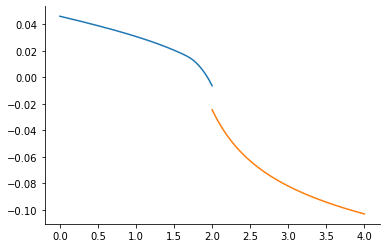

In [72]:
ϕ_bound = np.average(ϕ_temp_list, axis=0, weights=πᵈ_temp[:,-1])
plt.plot(y_grid[:numy_bar+1], ϕ_temp)
plt.plot(y_grid[numy_bar:], ϕ_bound[numy_bar:])

In [73]:
yt_temp, et_temp, πᵈt_temp, πᶜt_temp, ιt_temp, ht_temp = simulate_jump(y_grid[:numy_bar+1], ems_temp, πᶜ_temp, πᵈ_temp, ι_temp, h_temp, θtemp_list)

In [74]:
ξₐ = 1/15_000
ξₘ = 0.002/η/10
dmg_weight = np.array([0.475, 0.475, 0.05])
args = (δ, η, θcarb_list, γ1, γ2, γ3_list, dmg_weight, ς, ξₘ, ξₐ, ξ)
ϕ_carb, ems_carb, πᶜ_carb, ι_carb, πᵈ_carb, h_carb, ϕ_carb_list = solve_jump(y_grid, numy_bar, args, tol=2e-6)

episode: 1,	 ode error: 0.0017049709683354603,	 ft error: 0.0014434370169589354
episode: 2,	 ode error: 0.0014291431559060822,	 ft error: 0.001301959405200656
episode: 3,	 ode error: 0.0013208957317948447,	 ft error: 0.0012338294308831366
episode: 4,	 ode error: 0.0012544522124182532,	 ft error: 0.001188576281111681
episode: 5,	 ode error: 0.0012046018024064742,	 ft error: 0.0011531142573051115
episode: 6,	 ode error: 0.0011638088093069016,	 ft error: 0.0011227913801736809
episode: 7,	 ode error: 0.0011295455954586284,	 ft error: 0.0010961152183299946
episode: 8,	 ode error: 0.0011000623304738039,	 ft error: 0.0010722540559880253
episode: 9,	 ode error: 0.0010744279332413772,	 ft error: 0.001050611673143382
episode: 10,	 ode error: 0.0010517101452761054,	 ft error: 0.001031156638141038
episode: 11,	 ode error: 0.0010311706396554233,	 ft error: 0.0010131157866096108
episode: 12,	 ode error: 0.0010126345057604811,	 ft error: 0.000996641099500546
episode: 13,	 ode error: 0.000995397996078

episode: 146,	 ode error: 0.0004083942005618735,	 ft error: 0.00040738567401042475
episode: 147,	 ode error: 0.000406517830947309,	 ft error: 0.00040556998241524783
episode: 148,	 ode error: 0.0004046782924357631,	 ft error: 0.0004037959630260694
episode: 149,	 ode error: 0.00040287058361696275,	 ft error: 0.0004020511060425063
episode: 150,	 ode error: 0.0004010900083873905,	 ft error: 0.0004003189516804789
episode: 151,	 ode error: 0.00039933162266119675,	 ft error: 0.00039858546725684657
episode: 152,	 ode error: 0.00039758551099663736,	 ft error: 0.00039887814862474974
episode: 153,	 ode error: 0.0003972356531116649,	 ft error: 0.0003959718113850352
episode: 154,	 ode error: 0.0003949354591587924,	 ft error: 0.0003935257269947294
episode: 155,	 ode error: 0.000392393878567723,	 ft error: 0.00039141788313971454
episode: 156,	 ode error: 0.00039038769601783176,	 ft error: 0.0003896270884664923
episode: 157,	 ode error: 0.0003885302019262237,	 ft error: 0.0003898817560783174
episode: 

episode: 253,	 ode error: 0.0002576170793366045,	 ft error: 0.0002559033306416316
episode: 254,	 ode error: 0.00025699705215653454,	 ft error: 0.0002550348660126702
episode: 255,	 ode error: 0.00025615167659085944,	 ft error: 0.0002540573235832363
episode: 256,	 ode error: 0.0002550889718761222,	 ft error: 0.00025308275260681656
episode: 257,	 ode error: 0.00025380390902870944,	 ft error: 0.0002520363995419985
episode: 258,	 ode error: 0.00025236397913405825,	 ft error: 0.0002508687904770555
episode: 259,	 ode error: 0.00025085596465977613,	 ft error: 0.0002496237646252194
episode: 260,	 ode error: 0.00024934965533753267,	 ft error: 0.0002484501897839081
episode: 261,	 ode error: 0.0002479033203164826,	 ft error: 0.00024697119314421223
episode: 262,	 ode error: 0.0002495040236015001,	 ft error: 0.00024595938931210504
episode: 263,	 ode error: 0.00024869799515472727,	 ft error: 0.00024740833719213984
episode: 264,	 ode error: 0.0002458539043024428,	 ft error: 0.0002449202234826078
episo

episode: 362,	 ode error: 0.00016904814368279633,	 ft error: 0.0001654617932361537
episode: 363,	 ode error: 0.00016824581142927872,	 ft error: 0.00016719775783972474
episode: 364,	 ode error: 0.00016575069634339017,	 ft error: 0.00016499051657928773
episode: 365,	 ode error: 0.00016423854915712953,	 ft error: 0.00016368154377892816
episode: 366,	 ode error: 0.00016318991452270767,	 ft error: 0.00016206609879709327
episode: 367,	 ode error: 0.00016386913264375164,	 ft error: 0.00016286924845174597
episode: 368,	 ode error: 0.0001625832100281972,	 ft error: 0.00016025975064682305
episode: 369,	 ode error: 0.00016242029481062343,	 ft error: 0.00015998165505089665
episode: 370,	 ode error: 0.00016139479163847226,	 ft error: 0.00015856216497626974
episode: 371,	 ode error: 0.00016077460629737876,	 ft error: 0.0001582036769555197
episode: 372,	 ode error: 0.00015968669741456916,	 ft error: 0.0001570887225453103
episode: 373,	 ode error: 0.0001590780750200659,	 ft error: 0.000157172763544909

episode: 473,	 ode error: 0.00011097248869690183,	 ft error: 0.00010817667221949916
episode: 474,	 ode error: 0.00011071186001480231,	 ft error: 0.0001088761252107893
episode: 475,	 ode error: 0.00011039151697649595,	 ft error: 0.00010991999696993715
episode: 476,	 ode error: 0.00011000274974485951,	 ft error: 0.00010778444698086864
episode: 477,	 ode error: 0.00010820134633638518,	 ft error: 0.00010646310324398853
episode: 478,	 ode error: 0.00010718574872325829,	 ft error: 0.00010602279859416494
episode: 479,	 ode error: 0.00010643904236542448,	 ft error: 0.00010575272938510849
episode: 480,	 ode error: 0.00010581829243587037,	 ft error: 0.00011034227972950747
episode: 481,	 ode error: 0.0001072472722086046,	 ft error: 0.00010639063078195232
episode: 482,	 ode error: 0.00010602550100602935,	 ft error: 0.0001087457251583666
episode: 483,	 ode error: 0.00010700577923176361,	 ft error: 0.00010679985603922101
episode: 484,	 ode error: 0.00010663826498183047,	 ft error: 0.0001050009813998

episode: 583,	 ode error: 7.399140530198558e-05,	 ft error: 7.296409728868118e-05
episode: 584,	 ode error: 7.388810207332368e-05,	 ft error: 7.411381962402672e-05
episode: 585,	 ode error: 7.307608432176077e-05,	 ft error: 7.226415379979478e-05
episode: 586,	 ode error: 7.296228217659609e-05,	 ft error: 7.25557420734833e-05
episode: 587,	 ode error: 7.243156151917336e-05,	 ft error: 7.172356559025095e-05
episode: 588,	 ode error: 7.220658809883385e-05,	 ft error: 7.17398971795726e-05
episode: 589,	 ode error: 7.183248469185314e-05,	 ft error: 7.127116795892693e-05
episode: 590,	 ode error: 7.159552267278909e-05,	 ft error: 7.11476579540645e-05
episode: 591,	 ode error: 7.13127974355124e-05,	 ft error: 7.083426752922672e-05
episode: 592,	 ode error: 7.109406925507591e-05,	 ft error: 7.061009720063054e-05
episode: 593,	 ode error: 7.08625112356791e-05,	 ft error: 7.037223528289875e-05
episode: 594,	 ode error: 7.06557196542936e-05,	 ft error: 7.012499765299274e-05
episode: 595,	 ode err

episode: 694,	 ode error: 4.929239629909005e-05,	 ft error: 4.903399078627173e-05
episode: 695,	 ode error: 4.8914900399872337e-05,	 ft error: 4.869337652806116e-05
episode: 696,	 ode error: 4.855090065853263e-05,	 ft error: 4.83817580133189e-05
episode: 697,	 ode error: 4.821022247226156e-05,	 ft error: 4.808843926204047e-05
episode: 698,	 ode error: 4.79041665618666e-05,	 ft error: 4.782164994244591e-05
episode: 699,	 ode error: 4.764532489942737e-05,	 ft error: 4.7592587156160736e-05
episode: 700,	 ode error: 4.7447188043858854e-05,	 ft error: 4.748912865393251e-05
episode: 701,	 ode error: 4.743637497939409e-05,	 ft error: 4.755932551103274e-05
episode: 702,	 ode error: 4.751561324582807e-05,	 ft error: 4.775579146275762e-05
episode: 703,	 ode error: 4.758715298712902e-05,	 ft error: 4.810421959428972e-05
episode: 704,	 ode error: 4.76429946023011e-05,	 ft error: 4.862962058672464e-05
episode: 705,	 ode error: 4.778635864352728e-05,	 ft error: 4.9351475007314294e-05
episode: 706,	 

episode: 805,	 ode error: 3.3732637169432526e-05,	 ft error: 3.3806359837976196e-05
episode: 806,	 ode error: 3.37119181976959e-05,	 ft error: 3.3766532009903614e-05
episode: 807,	 ode error: 3.3690158629052233e-05,	 ft error: 3.372416600736876e-05
episode: 808,	 ode error: 3.3666048540832824e-05,	 ft error: 3.3678470048361296e-05
episode: 809,	 ode error: 3.363848356999048e-05,	 ft error: 3.3628817474133196e-05
episode: 810,	 ode error: 3.3606575995094546e-05,	 ft error: 3.357477412833931e-05
episode: 811,	 ode error: 3.356966674532887e-05,	 ft error: 3.351606682496881e-05
episode: 812,	 ode error: 3.3527311439647827e-05,	 ft error: 3.3452572717103855e-05
episode: 813,	 ode error: 3.3479261798103374e-05,	 ft error: 3.3384286782141746e-05
episode: 814,	 ode error: 3.342543546612628e-05,	 ft error: 3.331129928477635e-05
episode: 815,	 ode error: 3.336588478489253e-05,	 ft error: 3.323376918653217e-05
episode: 816,	 ode error: 3.3300764188302586e-05,	 ft error: 3.315190623763564e-05
epis

episode: 916,	 ode error: 2.2952387824221217e-05,	 ft error: 2.2880708187890862e-05
episode: 917,	 ode error: 2.2746277975596455e-05,	 ft error: 2.2704476523999206e-05
episode: 918,	 ode error: 2.270991279044196e-05,	 ft error: 2.2523196771424375e-05
episode: 919,	 ode error: 2.2827090567724547e-05,	 ft error: 2.2338081261535914e-05
episode: 920,	 ode error: 2.2947326418993447e-05,	 ft error: 2.2150333812698264e-05
episode: 921,	 ode error: 2.3068829318208294e-05,	 ft error: 2.1963840925361598e-05
episode: 922,	 ode error: 2.318981055785029e-05,	 ft error: 2.182669289460537e-05
episode: 923,	 ode error: 2.3308488785096695e-05,	 ft error: 2.17015276608723e-05
episode: 924,	 ode error: 2.3423095068191555e-05,	 ft error: 2.1586938326346543e-05
episode: 925,	 ode error: 2.353187546466054e-05,	 ft error: 2.1481626739788817e-05
episode: 926,	 ode error: 2.363309481663719e-05,	 ft error: 2.1384401077291042e-05
episode: 927,	 ode error: 2.372504145470777e-05,	 ft error: 2.129416399924977e-05
e

episode: 1027,	 ode error: 1.5677624593547854e-05,	 ft error: 1.5564733502014077e-05
episode: 1028,	 ode error: 1.554748793220677e-05,	 ft error: 1.5569702223698172e-05
episode: 1029,	 ode error: 1.5506236249776995e-05,	 ft error: 1.5581792118963638e-05
episode: 1030,	 ode error: 1.5522499188478115e-05,	 ft error: 1.559979346074658e-05
episode: 1031,	 ode error: 1.5547210561203434e-05,	 ft error: 1.5622303800796877e-05
episode: 1032,	 ode error: 1.5578748171086315e-05,	 ft error: 1.5647753336354524e-05
episode: 1033,	 ode error: 1.5615313042139918e-05,	 ft error: 1.5674440228587626e-05
episode: 1034,	 ode error: 1.5654976015588807e-05,	 ft error: 1.57005750375111e-05
episode: 1035,	 ode error: 1.569572896931398e-05,	 ft error: 1.5724332532047563e-05
episode: 1036,	 ode error: 1.573553846119513e-05,	 ft error: 1.5743908270924683e-05
episode: 1037,	 ode error: 1.5772399413530947e-05,	 ft error: 1.5757576765987324e-05
episode: 1038,	 ode error: 1.5804386478070805e-05,	 ft error: 1.5763747

episode: 1138,	 ode error: 1.2143294170126242e-05,	 ft error: 1.0590943246152618e-05
episode: 1139,	 ode error: 1.2115061167000869e-05,	 ft error: 1.0559416926310869e-05
episode: 1140,	 ode error: 1.208430994262548e-05,	 ft error: 1.0527672989202319e-05
episode: 1141,	 ode error: 1.2053295863090905e-05,	 ft error: 1.0495531248845096e-05
episode: 1142,	 ode error: 1.2022975819281486e-05,	 ft error: 1.046322465181789e-05
episode: 1143,	 ode error: 1.1995118065373121e-05,	 ft error: 1.043077819488462e-05
episode: 1144,	 ode error: 1.1970706865191525e-05,	 ft error: 1.0398376564755656e-05
episode: 1145,	 ode error: 1.195071973033202e-05,	 ft error: 1.0366125036039472e-05
episode: 1146,	 ode error: 1.1935427494665779e-05,	 ft error: 1.0334157871221458e-05
episode: 1147,	 ode error: 1.1924684934879718e-05,	 ft error: 1.030254695437438e-05
episode: 1148,	 ode error: 1.1917653752530695e-05,	 ft error: 1.0271359368619708e-05
episode: 1149,	 ode error: 1.1912958181130133e-05,	 ft error: 1.024061

episode: 1249,	 ode error: 9.45469178145926e-06,	 ft error: 9.275072814414939e-06
episode: 1250,	 ode error: 9.45717924729771e-06,	 ft error: 9.2749448985426e-06
episode: 1251,	 ode error: 9.457456306906148e-06,	 ft error: 9.276630724835977e-06
episode: 1252,	 ode error: 9.456987399761915e-06,	 ft error: 9.281494963616263e-06
episode: 1253,	 ode error: 9.457201084311028e-06,	 ft error: 9.290724416928983e-06
episode: 1254,	 ode error: 9.459418602765154e-06,	 ft error: 9.3052604898299e-06
episode: 1255,	 ode error: 9.464785033555675e-06,	 ft error: 9.32573720892338e-06
episode: 1256,	 ode error: 9.474206129411592e-06,	 ft error: 9.352427395720175e-06
episode: 1257,	 ode error: 9.48829408647814e-06,	 ft error: 9.38520016889599e-06
episode: 1258,	 ode error: 9.5073254509963e-06,	 ft error: 9.423493407591707e-06
episode: 1259,	 ode error: 9.531214065434447e-06,	 ft error: 9.466304921115776e-06
episode: 1260,	 ode error: 9.559501324866407e-06,	 ft error: 9.512205708175903e-06
episode: 1261,	

episode: 1360,	 ode error: 5.656157292233208e-06,	 ft error: 5.389401723209416e-06
episode: 1361,	 ode error: 5.617083865881332e-06,	 ft error: 5.352912699647476e-06
episode: 1362,	 ode error: 5.576411464743437e-06,	 ft error: 5.314809311008732e-06
episode: 1363,	 ode error: 5.533875263356316e-06,	 ft error: 5.274822234164571e-06
episode: 1364,	 ode error: 5.48925628868842e-06,	 ft error: 5.232746897570103e-06
episode: 1365,	 ode error: 5.442392188051491e-06,	 ft error: 5.18845172809331e-06
episode: 1366,	 ode error: 5.393184430276627e-06,	 ft error: 5.141881820440916e-06
episode: 1367,	 ode error: 5.3416020500449786e-06,	 ft error: 5.093058495428404e-06
episode: 1368,	 ode error: 5.2876822423052715e-06,	 ft error: 5.042075404855055e-06
episode: 1369,	 ode error: 5.231528230510078e-06,	 ft error: 4.9890919595618755e-06
episode: 1370,	 ode error: 5.173304917287409e-06,	 ft error: 4.9343248817908716e-06
episode: 1371,	 ode error: 5.1132328428808846e-06,	 ft error: 4.8780386605745685e-06


episode: 1471,	 ode error: 5.486746592342929e-06,	 ft error: 5.380313277426422e-06
episode: 1472,	 ode error: 5.5160971014496085e-06,	 ft error: 5.397065238124665e-06
episode: 1473,	 ode error: 5.539992142170437e-06,	 ft error: 5.395527437127012e-06
episode: 1474,	 ode error: 5.553794224123147e-06,	 ft error: 5.383115122247392e-06
episode: 1475,	 ode error: 5.55805139709493e-06,	 ft error: 5.353469055881707e-06
episode: 1476,	 ode error: 5.55037794423873e-06,	 ft error: 5.34381989434248e-06
episode: 1477,	 ode error: 5.530164996984401e-06,	 ft error: 5.322437848255072e-06
episode: 1478,	 ode error: 5.4960303035010444e-06,	 ft error: 5.284801191130876e-06
episode: 1479,	 ode error: 5.447335622193778e-06,	 ft error: 5.230330743672777e-06
episode: 1480,	 ode error: 5.3833759106398276e-06,	 ft error: 5.158932627434091e-06
episode: 1481,	 ode error: 5.3038653005003196e-06,	 ft error: 5.070900054883014e-06
episode: 1482,	 ode error: 5.208665727464944e-06,	 ft error: 4.966905514959079e-06
epi

episode: 1583,	 ode error: 4.003792286110127e-06,	 ft error: 3.794658973502174e-06
episode: 1584,	 ode error: 3.4517410784823442e-06,	 ft error: 3.86152939413816e-06
episode: 1585,	 ode error: 4.62056050838796e-06,	 ft error: 4.731411201395567e-06
episode: 1586,	 ode error: 3.6092333605645e-06,	 ft error: 3.232244740469792e-06
episode: 1587,	 ode error: 4.088241081748388e-06,	 ft error: 2.715793568849878e-06
episode: 1588,	 ode error: 3.6496776087010206e-06,	 ft error: 2.973166131949497e-06
episode: 1589,	 ode error: 3.843881089550072e-06,	 ft error: 2.7472922344238633e-06
episode: 1590,	 ode error: 3.6834550997290457e-06,	 ft error: 2.8489269666975847e-06
episode: 1591,	 ode error: 3.793300827815548e-06,	 ft error: 2.7529955699129305e-06
episode: 1592,	 ode error: 3.771852319228177e-06,	 ft error: 2.7844607544449027e-06
episode: 1593,	 ode error: 3.869171958035904e-06,	 ft error: 2.7435823888449784e-06
episode: 1594,	 ode error: 3.920611496766881e-06,	 ft error: 2.7546861587161393e-06

episode: 1694,	 ode error: 2.9833320478677393e-06,	 ft error: 3.2512874726988348e-06
episode: 1695,	 ode error: 3.1440009263960676e-06,	 ft error: 3.42761371623553e-06
episode: 1696,	 ode error: 3.319090132380075e-06,	 ft error: 3.6294596567065796e-06
episode: 1697,	 ode error: 3.5107455628597935e-06,	 ft error: 3.859547590458664e-06
episode: 1698,	 ode error: 3.7203026977360425e-06,	 ft error: 4.119700324559106e-06
episode: 1699,	 ode error: 3.948117486578338e-06,	 ft error: 4.410550065031549e-06
episode: 1700,	 ode error: 4.19344970439882e-06,	 ft error: 4.731271583633771e-06
episode: 1701,	 ode error: 4.454416724707783e-06,	 ft error: 5.079379929162631e-06
episode: 1702,	 ode error: 4.728030768078907e-06,	 ft error: 5.450636049939006e-06
episode: 1703,	 ode error: 5.010324219651189e-06,	 ft error: 5.839097346564219e-06
episode: 1704,	 ode error: 5.302751865868282e-06,	 ft error: 3.5011577505239533e-06
episode: 1705,	 ode error: 2.530091523618807e-06,	 ft error: 2.4201263153454207e-0

episode: 128,	 ode error: 0.0004462439702698275,	 ft error: 0.00044512421001028046
episode: 129,	 ode error: 0.0004440429541182939,	 ft error: 0.0004429342947867565
episode: 130,	 ode error: 0.00044185636255916197,	 ft error: 0.0004407584740841996
episode: 131,	 ode error: 0.00043968382839454107,	 ft error: 0.00043859637534659585
episode: 132,	 ode error: 0.0004375249935757153,	 ft error: 0.00043644763774645473
episode: 133,	 ode error: 0.0004353795067155252,	 ft error: 0.0004343119088508901
episode: 134,	 ode error: 0.0004332470211274896,	 ft error: 0.00043218884211940894
episode: 135,	 ode error: 0.00043112719334314163,	 ft error: 0.0004300780950785311
episode: 136,	 ode error: 0.00042901968204911987,	 ft error: 0.0004279793280369838
episode: 137,	 ode error: 0.00042692414738378245,	 ft error: 0.0004258922032465811
episode: 138,	 ode error: 0.00042484025053750774,	 ft error: 0.0004238163844272914
episode: 139,	 ode error: 0.00042276765360335904,	 ft error: 0.00042175153659496784
epis

episode: 227,	 ode error: 0.0002648998181392201,	 ft error: 0.0002641365616382757
episode: 228,	 ode error: 0.00026337611645163377,	 ft error: 0.0002626174209799381
episode: 229,	 ode error: 0.00026186003122395034,	 ft error: 0.0002611059022344468
episode: 230,	 ode error: 0.0002603515839310252,	 ft error: 0.0002596020255694424
episode: 231,	 ode error: 0.00025885079359319846,	 ft error: 0.0002581058087305216
episode: 232,	 ode error: 0.00025735795367842144,	 ft error: 0.00025652498916961996
episode: 233,	 ode error: 0.00025587678009923677,	 ft error: 0.0002550539609188357
episode: 234,	 ode error: 0.00025440553984882924,	 ft error: 0.00025358432131722397
episode: 235,	 ode error: 0.00025294351256388624,	 ft error: 0.0002521289140949151
episode: 236,	 ode error: 0.000251489777828311,	 ft error: 0.00025068208161040106
episode: 237,	 ode error: 0.00025004379397487156,	 ft error: 0.0002492433655239037
episode: 238,	 ode error: 0.00024860523504504825,	 ft error: 0.0002478119747893517
episo

episode: 332,	 ode error: 0.00014384416312537157,	 ft error: 0.00014357723339758027
episode: 333,	 ode error: 0.00014301329752631705,	 ft error: 0.0001427511291129946
episode: 334,	 ode error: 0.0001421873592946254,	 ft error: 0.00014192995143912554
episode: 335,	 ode error: 0.00014136631696732617,	 ft error: 0.00014111366909162298
episode: 336,	 ode error: 0.00014055013926377892,	 ft error: 0.00014030225093490667
episode: 337,	 ode error: 0.00013973879508828442,	 ft error: 0.00013949566598998414
episode: 338,	 ode error: 0.00013893225353273086,	 ft error: 0.00013869388336198535
episode: 339,	 ode error: 0.00013813048388154636,	 ft error: 0.0001378968722310035
episode: 340,	 ode error: 0.00013733345561791927,	 ft error: 0.0001371046019834482
episode: 341,	 ode error: 0.00013654113842832458,	 ft error: 0.00013631704231157246
episode: 342,	 ode error: 0.00013575350220189418,	 ft error: 0.00013553416322529174
episode: 343,	 ode error: 0.00013497051702643728,	 ft error: 0.00013475593495397

episode: 436,	 ode error: 7.97789972038312e-05,	 ft error: 7.945243064621614e-05
episode: 437,	 ode error: 7.933504720310724e-05,	 ft error: 7.901002017927465e-05
episode: 438,	 ode error: 7.889347355857345e-05,	 ft error: 7.856997519972246e-05
episode: 439,	 ode error: 7.845426478347362e-05,	 ft error: 7.813228432446603e-05
episode: 440,	 ode error: 7.801740940305973e-05,	 ft error: 7.76969361771888e-05
episode: 441,	 ode error: 7.758289595342818e-05,	 ft error: 7.726391938872128e-05
episode: 442,	 ode error: 7.715071298081437e-05,	 ft error: 7.683322259687912e-05
episode: 443,	 ode error: 7.67208490420816e-05,	 ft error: 7.640483444734207e-05
episode: 444,	 ode error: 7.629329270484849e-05,	 ft error: 7.597874359437096e-05
episode: 445,	 ode error: 7.586803254884533e-05,	 ft error: 7.555493870254246e-05
episode: 446,	 ode error: 7.544505716678177e-05,	 ft error: 7.513340844769734e-05
episode: 447,	 ode error: 7.502435516570807e-05,	 ft error: 7.471414151883719e-05
episode: 448,	 ode 

episode: 544,	 ode error: 4.333645756810552e-05,	 ft error: 4.3153213822750655e-05
episode: 545,	 ode error: 4.311461128776511e-05,	 ft error: 4.28267489992427e-05
episode: 546,	 ode error: 4.2843978656821255e-05,	 ft error: 4.266483855754529e-05
episode: 547,	 ode error: 4.2626311893323486e-05,	 ft error: 4.234105394011756e-05
episode: 548,	 ode error: 4.2359312655214495e-05,	 ft error: 4.218230777117601e-05
episode: 549,	 ode error: 4.214459556484292e-05,	 ft error: 4.186127222564433e-05
episode: 550,	 ode error: 4.188064656262679e-05,	 ft error: 4.170538188271826e-05
episode: 551,	 ode error: 4.166857856294963e-05,	 ft error: 4.1386930467480584e-05
episode: 552,	 ode error: 4.1407431339233135e-05,	 ft error: 4.1233646432201065e-05
episode: 553,	 ode error: 4.119789969823278e-05,	 ft error: 4.091781498412328e-05
episode: 554,	 ode error: 4.0939377007992786e-05,	 ft error: 4.076699719813189e-05
episode: 555,	 ode error: 4.073235521721331e-05,	 ft error: 4.0453785552600305e-05
episode:

episode: 656,	 ode error: 2.280816046529516e-05,	 ft error: 2.287901579373202e-05
episode: 657,	 ode error: 2.26747649414306e-05,	 ft error: 2.2821011669589324e-05
episode: 658,	 ode error: 2.2542068258745948e-05,	 ft error: 2.2763147481119628e-05
episode: 659,	 ode error: 2.2410066419120147e-05,	 ft error: 2.2705422877683283e-05
episode: 660,	 ode error: 2.227875544297893e-05,	 ft error: 2.2647837506246708e-05
episode: 661,	 ode error: 2.21481313696447e-05,	 ft error: 2.2590391018627774e-05
episode: 662,	 ode error: 2.2018190256903173e-05,	 ft error: 2.253308306713007e-05
episode: 663,	 ode error: 2.1888928181605866e-05,	 ft error: 2.2475913305259935e-05
episode: 664,	 ode error: 2.1760341239622288e-05,	 ft error: 2.2418881388703665e-05
episode: 665,	 ode error: 2.163242554575743e-05,	 ft error: 2.2361986975651348e-05
episode: 666,	 ode error: 2.1505177234372908e-05,	 ft error: 2.2305229724223684e-05
episode: 667,	 ode error: 2.137859245890264e-05,	 ft error: 2.22486092959819e-05
epis

episode: 768,	 ode error: 1.5934309404599326e-05,	 ft error: 1.7185888856220688e-05
episode: 769,	 ode error: 1.589088504448064e-05,	 ft error: 1.7141822800393246e-05
episode: 770,	 ode error: 1.5847565196955087e-05,	 ft error: 1.709786711987423e-05
episode: 771,	 ode error: 1.580434962738969e-05,	 ft error: 1.7054021609029524e-05
episode: 772,	 ode error: 1.5761238101441924e-05,	 ft error: 1.7010286064884916e-05
episode: 773,	 ode error: 1.5718230385038047e-05,	 ft error: 1.696666028972819e-05
episode: 774,	 ode error: 1.567532624438753e-05,	 ft error: 1.6923144085951212e-05
episode: 775,	 ode error: 1.563252544595296e-05,	 ft error: 1.6879737261092192e-05
episode: 776,	 ode error: 1.5589827756468826e-05,	 ft error: 1.683643962279343e-05
episode: 777,	 ode error: 1.554723294292052e-05,	 ft error: 1.679325098193537e-05
episode: 778,	 ode error: 1.5504740772551053e-05,	 ft error: 1.6750171150878755e-05
episode: 779,	 ode error: 1.5462351012854384e-05,	 ft error: 1.6707199943048295e-05
e

episode: 880,	 ode error: 1.1669316906585107e-05,	 ft error: 1.288118145781105e-05
episode: 881,	 ode error: 1.1636235767324265e-05,	 ft error: 1.2847861185436479e-05
episode: 882,	 ode error: 1.1603235806410941e-05,	 ft error: 1.281462112689517e-05
episode: 883,	 ode error: 1.1570316846347986e-05,	 ft error: 1.2781461089054574e-05
episode: 884,	 ode error: 1.1537478709992431e-05,	 ft error: 1.2748380881661785e-05
episode: 885,	 ode error: 1.1504721220541043e-05,	 ft error: 1.271538031736667e-05
episode: 886,	 ode error: 1.1472044201531759e-05,	 ft error: 1.268245921136335e-05
episode: 887,	 ode error: 1.143944747683412e-05,	 ft error: 1.2649617380233735e-05
episode: 888,	 ode error: 1.1406930870641005e-05,	 ft error: 1.2616854645347564e-05
episode: 889,	 ode error: 1.1374494207463503e-05,	 ft error: 1.2584170828537172e-05
episode: 890,	 ode error: 1.1342137312127124e-05,	 ft error: 1.2551565755844485e-05
episode: 891,	 ode error: 1.130986000975919e-05,	 ft error: 1.251903925547406e-05

episode: 991,	 ode error: 8.454849590566217e-06,	 ft error: 9.643441179751449e-06
episode: 992,	 ode error: 8.429741098922583e-06,	 ft error: 9.618252354859821e-06
episode: 993,	 ode error: 8.40469532000342e-06,	 ft error: 9.593128073940213e-06
episode: 994,	 ode error: 8.379712104454975e-06,	 ft error: 9.56806810178725e-06
episode: 995,	 ode error: 8.354791303431737e-06,	 ft error: 9.543072206954125e-06
episode: 996,	 ode error: 8.329932768607533e-06,	 ft error: 9.518140155854542e-06
episode: 997,	 ode error: 8.305136352169148e-06,	 ft error: 9.493271717990009e-06
episode: 998,	 ode error: 8.280401906799801e-06,	 ft error: 9.468466665602897e-06
episode: 999,	 ode error: 8.255729285697974e-06,	 ft error: 9.443724768946431e-06
episode: 1000,	 ode error: 8.231118342556711e-06,	 ft error: 9.419045803732429e-06
episode: 1001,	 ode error: 8.206568931563775e-06,	 ft error: 9.394429544793786e-06
episode: 1002,	 ode error: 8.182080907397966e-06,	 ft error: 9.369875770872301e-06
episode: 1003,	

episode: 1102,	 ode error: 6.019970721290687e-06,	 ft error: 7.201773393437916e-06
episode: 1103,	 ode error: 6.00099608633376e-06,	 ft error: 7.182743790775751e-06
episode: 1104,	 ode error: 5.982069706572706e-06,	 ft error: 7.16376276947243e-06
episode: 1105,	 ode error: 5.9631914660507204e-06,	 ft error: 7.1448302155219245e-06
episode: 1106,	 ode error: 5.944361249056896e-06,	 ft error: 7.125946015415496e-06
episode: 1107,	 ode error: 5.925578940121559e-06,	 ft error: 7.107110056130128e-06
episode: 1108,	 ode error: 5.906844424012479e-06,	 ft error: 7.088322224758452e-06
episode: 1109,	 ode error: 5.888157585740987e-06,	 ft error: 7.069582407514171e-06
episode: 1110,	 ode error: 5.869518310557052e-06,	 ft error: 7.050890491813733e-06
episode: 1111,	 ode error: 5.850926483954612e-06,	 ft error: 7.032246364807593e-06
episode: 1112,	 ode error: 5.832381991668624e-06,	 ft error: 7.013649913229873e-06
episode: 1113,	 ode error: 5.813884719677097e-06,	 ft error: 6.995101024416066e-06
epis

episode: 1213,	 ode error: 4.184091870209288e-06,	 ft error: 5.361769329590797e-06
episode: 1214,	 ode error: 4.1698182123630365e-06,	 ft error: 5.347474349391239e-06
episode: 1215,	 ode error: 4.1555813676569405e-06,	 ft error: 5.333216412962509e-06
episode: 1216,	 ode error: 4.141381245405511e-06,	 ft error: 5.318995429983339e-06
episode: 1217,	 ode error: 4.12721775513487e-06,	 ft error: 5.304811306663012e-06
episode: 1218,	 ode error: 4.113090806573855e-06,	 ft error: 5.2906639530850286e-06
episode: 1219,	 ode error: 4.099000309659636e-06,	 ft error: 5.276553276326035e-06
episode: 1220,	 ode error: 4.084946174530554e-06,	 ft error: 5.262479186677697e-06
episode: 1221,	 ode error: 4.0709283115388385e-06,	 ft error: 5.248441591702384e-06
episode: 1222,	 ode error: 4.056946631235262e-06,	 ft error: 5.234440400951612e-06
episode: 1223,	 ode error: 4.043001044372557e-06,	 ft error: 5.220475524890522e-06
episode: 1224,	 ode error: 4.02909146191756e-06,	 ft error: 5.206546871231825e-06
ep

episode: 1324,	 ode error: 2.8055349253256986e-06,	 ft error: 3.981961750783303e-06
episode: 1325,	 ode error: 2.794837496356039e-06,	 ft error: 3.97126081141258e-06
episode: 1326,	 ode error: 2.7841679927170467e-06,	 ft error: 3.960587899344559e-06
episode: 1327,	 ode error: 2.7735263443567936e-06,	 ft error: 3.949942944924309e-06
episode: 1328,	 ode error: 2.7629124813847343e-06,	 ft error: 3.939325876634962e-06
episode: 1329,	 ode error: 2.7523263340764506e-06,	 ft error: 3.928736625527045e-06
episode: 1330,	 ode error: 2.7417678328711843e-06,	 ft error: 3.918175120245597e-06
episode: 1331,	 ode error: 2.7312369083688293e-06,	 ft error: 3.907641291609846e-06
episode: 1332,	 ode error: 2.7207334913380353e-06,	 ft error: 3.897135068785251e-06
episode: 1333,	 ode error: 2.710257512705664e-06,	 ft error: 3.886656383481532e-06
episode: 1334,	 ode error: 2.6998089035667105e-06,	 ft error: 3.876205164956663e-06
episode: 1335,	 ode error: 2.6893875951723484e-06,	 ft error: 3.865781344318994

episode: 1433,	 ode error: 1.7900534629380644e-06,	 ft error: 2.9665961191402412e-06
episode: 1434,	 ode error: 1.7820202616142765e-06,	 ft error: 2.9585676889395027e-06
episode: 1435,	 ode error: 1.7740082496408931e-06,	 ft error: 2.9505604972127064e-06
episode: 1436,	 ode error: 1.766017373014075e-06,	 ft error: 2.942574488888165e-06
episode: 1437,	 ode error: 1.7580475778578106e-06,	 ft error: 2.9346096103513575e-06
episode: 1438,	 ode error: 1.750098810428415e-06,	 ft error: 2.9266658073979585e-06
episode: 1439,	 ode error: 1.742171017113229e-06,	 ft error: 2.9187430256039093e-06
episode: 1440,	 ode error: 1.7342641444243855e-06,	 ft error: 2.910841210926792e-06
episode: 1441,	 ode error: 1.7263781390110873e-06,	 ft error: 2.902960309370447e-06
episode: 1442,	 ode error: 1.7185129476467327e-06,	 ft error: 2.8951002683727523e-06
episode: 1443,	 ode error: 1.710668517234499e-06,	 ft error: 2.8872610330239285e-06
episode: 1444,	 ode error: 1.702844794808779e-06,	 ft error: 2.879442550

episode: 1544,	 ode error: 1.1709771583241898e-06,	 ft error: 2.1937797784962743e-06
episode: 1545,	 ode error: 1.1732854933708438e-06,	 ft error: 2.1878041761338083e-06
episode: 1546,	 ode error: 1.1755902875863495e-06,	 ft error: 2.181844518320264e-06
episode: 1547,	 ode error: 1.1778915392148957e-06,	 ft error: 2.1759007650066593e-06
episode: 1548,	 ode error: 1.1801892465589472e-06,	 ft error: 2.169972874837186e-06
episode: 1549,	 ode error: 1.182483407981467e-06,	 ft error: 2.164060805692758e-06
episode: 1550,	 ode error: 1.184774021917572e-06,	 ft error: 2.1581645178944675e-06
episode: 1551,	 ode error: 1.18706108684553e-06,	 ft error: 2.152283969149756e-06
episode: 1552,	 ode error: 1.1893446013213466e-06,	 ft error: 2.146419119930058e-06
episode: 1553,	 ode error: 1.1916245639492199e-06,	 ft error: 2.14056992857888e-06
episode: 1554,	 ode error: 1.193900973412874e-06,	 ft error: 2.1347363545962117e-06
episode: 1555,	 ode error: 1.1961738284349565e-06,	 ft error: 2.1289183577711

episode: 151,	 ode error: 0.0006222849331691933,	 ft error: 0.0006226641255878176
episode: 152,	 ode error: 0.000620427908681886,	 ft error: 0.0006207945995916064
episode: 153,	 ode error: 0.0006185764590591263,	 ft error: 0.0006189308348480509
episode: 154,	 ode error: 0.0006167305670888339,	 ft error: 0.0006170728250195583
episode: 155,	 ode error: 0.0006148902155805166,	 ft error: 0.0006152205628900722
episode: 156,	 ode error: 0.0006130553873678766,	 ft error: 0.0006133740403728438
episode: 157,	 ode error: 0.0006112260653114408,	 ft error: 0.0006115332484998386
episode: 158,	 ode error: 0.0006094022323012131,	 ft error: 0.0006096981774165779
episode: 159,	 ode error: 0.0006075838712592481,	 ft error: 0.0006078688164058942
episode: 160,	 ode error: 0.0006057709651422655,	 ft error: 0.000606045153878169
episode: 161,	 ode error: 0.0006039634969442593,	 ft error: 0.0006042271773691137
episode: 162,	 ode error: 0.0006021614496989612,	 ft error: 0.0006024148735909082
episode: 163,	 ode

episode: 352,	 ode error: 0.00034144130490545337,	 ft error: 0.0003412425083563579
episode: 353,	 ode error: 0.0003404235344721808,	 ft error: 0.0003402253736993951
episode: 354,	 ode error: 0.00033940879754133,	 ft error: 0.00033921127259889383
episode: 355,	 ode error: 0.00033839708506640427,	 ft error: 0.0003382001959143418
episode: 356,	 ode error: 0.00033738838802815116,	 ft error: 0.0003371921345370066
episode: 357,	 ode error: 0.0003363826974344586,	 ft error: 0.0003361870793922028
episode: 358,	 ode error: 0.000335380004320292,	 ft error: 0.000335185021427172
episode: 359,	 ode error: 0.00033438029974759947,	 ft error: 0.0003341859516201492
episode: 360,	 ode error: 0.0003333835748051806,	 ft error: 0.0003331898609932697
episode: 361,	 ode error: 0.00033238982060867237,	 ft error: 0.00033219674057435866
episode: 362,	 ode error: 0.0003313990283003843,	 ft error: 0.0003312065814444857
episode: 363,	 ode error: 0.00033041118904926525,	 ft error: 0.00033021937469822815
episode: 36

episode: 455,	 ode error: 0.000251170844376796,	 ft error: 0.00025032837925940504
episode: 456,	 ode error: 0.0002504242148104672,	 ft error: 0.00024958348661692964
episode: 457,	 ode error: 0.00024967980686836796,	 ft error: 0.0002488408101586348
episode: 458,	 ode error: 0.00024893761394111135,	 ft error: 0.000248100343288038
episode: 459,	 ode error: 0.0002481976294389838,	 ft error: 0.00024736207942766913
episode: 460,	 ode error: 0.00024745984679189117,	 ft error: 0.00024662601201837686
episode: 461,	 ode error: 0.00024672425944928197,	 ft error: 0.0002458921345264061
episode: 462,	 ode error: 0.0002459908608801179,	 ft error: 0.00024516044042762386
episode: 463,	 ode error: 0.00024525964457279125,	 ft error: 0.00024443092322611515
episode: 464,	 ode error: 0.0002445306040350782,	 ft error: 0.0002437035764414619
episode: 465,	 ode error: 0.00024380373279408096,	 ft error: 0.00024297839361184237
episode: 466,	 ode error: 0.00024307902439615892,	 ft error: 0.0002422553682993045
epis

episode: 560,	 ode error: 0.00018375347959628883,	 ft error: 0.00018318809334690508
episode: 561,	 ode error: 0.00018320733345615408,	 ft error: 0.00018256371072625233
episode: 562,	 ode error: 0.0001826631802096674,	 ft error: 0.00018189762555613037
episode: 563,	 ode error: 0.0001821200420969257,	 ft error: 0.0001815573553897813
episode: 564,	 ode error: 0.00018157875732090027,	 ft error: 0.00018093860545626933
episode: 565,	 ode error: 0.0001810394244861214,	 ft error: 0.00018028618763705578
episode: 566,	 ode error: 0.00018050112133772807,	 ft error: 0.00017994110680504458
episode: 567,	 ode error: 0.00017996465475723488,	 ft error: 0.00017932793168593902
episode: 568,	 ode error: 0.0001794300998637625,	 ft error: 0.00017868894831726823
episode: 569,	 ode error: 0.00017889658871076027,	 ft error: 0.0001783392222742819
episode: 570,	 ode error: 0.0001783648975288547,	 ft error: 0.0001777315651688612
episode: 571,	 ode error: 0.00017783507849659192,	 ft error: 0.00017710577712881648


episode: 667,	 ode error: 0.00013365334031199578,	 ft error: 0.00013316788964064705
episode: 668,	 ode error: 0.00013325650001224103,	 ft error: 0.00013265277566075023
episode: 669,	 ode error: 0.00013286048455900755,	 ft error: 0.00013237637978900468
episode: 670,	 ode error: 0.00013246599643040836,	 ft error: 0.00013186647245061467
episode: 671,	 ode error: 0.00013207233472282542,	 ft error: 0.00013158956682241912
episode: 672,	 ode error: 0.00013168018489282003,	 ft error: 0.00013108480695758762
episode: 673,	 ode error: 0.0001312888629636565,	 ft error: 0.00013080742295075906
episode: 674,	 ode error: 0.00013089903764050104,	 ft error: 0.00013030775216152368
episode: 675,	 ode error: 0.0001305100416051937,	 ft error: 0.00013002992053941695
episode: 676,	 ode error: 0.00013012252707747301,	 ft error: 0.00012953528120450883
episode: 677,	 ode error: 0.00012973584313363123,	 ft error: 0.00012925703211967104
episode: 678,	 ode error: 0.0001293506257698234,	 ft error: 0.0001287673673758

episode: 775,	 ode error: 9.693158395047779e-05,	 ft error: 9.650702803213711e-05
episode: 776,	 ode error: 9.664377491374482e-05,	 ft error: 9.620521644169526e-05
episode: 777,	 ode error: 9.635677957487668e-05,	 ft error: 9.593314804078509e-05
episode: 778,	 ode error: 9.607067852922355e-05,	 ft error: 9.563426528302887e-05
episode: 779,	 ode error: 9.578538976867559e-05,	 ft error: 9.536267609809117e-05
episode: 780,	 ode error: 9.550098660475361e-05,	 ft error: 9.506669367299418e-05
episode: 781,	 ode error: 9.521739428801498e-05,	 ft error: 9.479559200840464e-05
episode: 782,	 ode error: 9.49346789558158e-05,	 ft error: 9.450248177222953e-05
episode: 783,	 ode error: 9.46527730084515e-05,	 ft error: 9.423187568705083e-05
episode: 784,	 ode error: 9.437173551697371e-05,	 ft error: 9.394160985355209e-05
episode: 785,	 ode error: 9.409150592425228e-05,	 ft error: 9.367150717689196e-05
episode: 786,	 ode error: 9.381213634116446e-05,	 ft error: 9.338405830195777e-05
episode: 787,	 ode

episode: 884,	 ode error: 7.015308782686719e-05,	 ft error: 6.940312399325577e-05
episode: 885,	 ode error: 6.994607469402796e-05,	 ft error: 6.919691239143377e-05
episode: 886,	 ode error: 6.973967661646856e-05,	 ft error: 6.899131432341887e-05
episode: 887,	 ode error: 6.953389176587023e-05,	 ft error: 6.878632744284723e-05
episode: 888,	 ode error: 6.932871832056688e-05,	 ft error: 6.858194952608088e-05
episode: 889,	 ode error: 6.91241544652398e-05,	 ft error: 6.837817845069724e-05
episode: 890,	 ode error: 6.892019839069643e-05,	 ft error: 6.817501216870489e-05
episode: 891,	 ode error: 6.871684829368283e-05,	 ft error: 6.797244869470125e-05
episode: 892,	 ode error: 6.851410237672666e-05,	 ft error: 6.77704860953717e-05
episode: 893,	 ode error: 6.831195884801644e-05,	 ft error: 6.756912247852613e-05
episode: 894,	 ode error: 6.811041592130578e-05,	 ft error: 6.736835598370831e-05
episode: 895,	 ode error: 6.79094718158171e-05,	 ft error: 6.71681847822884e-05
episode: 896,	 ode e

episode: 995,	 ode error: 5.055532377415276e-05,	 ft error: 4.9876202051352125e-05
episode: 996,	 ode error: 5.040655326743492e-05,	 ft error: 4.9727932009691056e-05
episode: 997,	 ode error: 5.025822500504158e-05,	 ft error: 4.958010234692075e-05
episode: 998,	 ode error: 5.011033767348609e-05,	 ft error: 4.943271176158226e-05
episode: 999,	 ode error: 4.996288996315435e-05,	 ft error: 4.928575895924807e-05
episode: 1000,	 ode error: 4.981588056829182e-05,	 ft error: 4.9139242649977786e-05
episode: 1001,	 ode error: 4.966930818700371e-05,	 ft error: 4.899316154396982e-05
episode: 1002,	 ode error: 4.952317152122896e-05,	 ft error: 4.884751435840773e-05
episode: 1003,	 ode error: 4.937746927674157e-05,	 ft error: 4.870229981246421e-05
episode: 1004,	 ode error: 4.923220016312931e-05,	 ft error: 4.855751663021546e-05
episode: 1005,	 ode error: 4.90873628937931e-05,	 ft error: 4.841316353777307e-05
episode: 1006,	 ode error: 4.894295618592206e-05,	 ft error: 4.826923926790998e-05
episode

episode: 1106,	 ode error: 3.6472191314967624e-05,	 ft error: 3.583965527793424e-05
episode: 1107,	 ode error: 3.636528770998323e-05,	 ft error: 3.573310283453794e-05
episode: 1108,	 ode error: 3.625870192174724e-05,	 ft error: 3.562686708369345e-05
episode: 1109,	 ode error: 3.6152433005701406e-05,	 ft error: 3.552094708041594e-05
episode: 1110,	 ode error: 3.604648002009472e-05,	 ft error: 3.541534188457781e-05
episode: 1111,	 ode error: 3.594084202599183e-05,	 ft error: 3.531005055614397e-05
episode: 1112,	 ode error: 3.583551808724857e-05,	 ft error: 3.520507216137059e-05
episode: 1113,	 ode error: 3.573050727051692e-05,	 ft error: 3.510040576628256e-05
episode: 1114,	 ode error: 3.562580864522702e-05,	 ft error: 3.499605044120687e-05
episode: 1115,	 ode error: 3.552142128358197e-05,	 ft error: 3.489200525956989e-05
episode: 1116,	 ode error: 3.541734426055457e-05,	 ft error: 3.478826929641706e-05
episode: 1117,	 ode error: 3.531357665386998e-05,	 ft error: 3.4684841630309535e-05
e

episode: 1217,	 ode error: 2.6352460864852243e-05,	 ft error: 2.5752525281789545e-05
episode: 1218,	 ode error: 2.6275644585833794e-05,	 ft error: 2.5675950993999295e-05
episode: 1219,	 ode error: 2.6199056709776385e-05,	 ft error: 2.5599604284073006e-05
episode: 1220,	 ode error: 2.6122696557898117e-05,	 ft error: 2.552348447421952e-05
episode: 1221,	 ode error: 2.60465634534478e-05,	 ft error: 2.5447590885444942e-05
episode: 1222,	 ode error: 2.5970656721685872e-05,	 ft error: 2.5371922845601746e-05
episode: 1223,	 ode error: 2.5894975689891558e-05,	 ft error: 2.5296479679951894e-05
episode: 1224,	 ode error: 2.5819519687350504e-05,	 ft error: 2.522126071759686e-05
episode: 1225,	 ode error: 2.574428804534806e-05,	 ft error: 2.5146265289904823e-05
episode: 1226,	 ode error: 2.566928009716733e-05,	 ft error: 2.5071492728891608e-05
episode: 1227,	 ode error: 2.5594495178081792e-05,	 ft error: 2.4996942370088725e-05
episode: 1228,	 ode error: 2.5519932625351835e-05,	 ft error: 2.4922613

episode: 1328,	 ode error: 1.9081096731245195e-05,	 ft error: 1.850280516052516e-05
episode: 1329,	 ode error: 1.9025904819088783e-05,	 ft error: 1.8447761439184994e-05
episode: 1330,	 ode error: 1.897087709164659e-05,	 ft error: 1.8392881191338826e-05
episode: 1331,	 ode error: 1.8916013061317117e-05,	 ft error: 1.833816393482605e-05
episode: 1332,	 ode error: 1.8861312241934573e-05,	 ft error: 1.8283609189937804e-05
episode: 1333,	 ode error: 1.8806774148761706e-05,	 ft error: 1.8229216478167963e-05
episode: 1334,	 ode error: 1.8752398298488944e-05,	 ft error: 1.817498532304581e-05
episode: 1335,	 ode error: 1.869818420923092e-05,	 ft error: 1.8120915248285668e-05
episode: 1336,	 ode error: 1.8644131400518023e-05,	 ft error: 1.806700578088627e-05
episode: 1337,	 ode error: 1.8590239393295087e-05,	 ft error: 1.8013256447476277e-05
episode: 1338,	 ode error: 1.853650770991446e-05,	 ft error: 1.795966677787623e-05
episode: 1339,	 ode error: 1.8482935874137305e-05,	 ft error: 1.790623630

episode: 1439,	 ode error: 1.385705779978724e-05,	 ft error: 1.329228305045153e-05
episode: 1440,	 ode error: 1.3817407870849027e-05,	 ft error: 1.325273975209355e-05
episode: 1441,	 ode error: 1.3777875892027284e-05,	 ft error: 1.3213314308535562e-05
episode: 1442,	 ode error: 1.3738461511787889e-05,	 ft error: 1.3174006370843724e-05
episode: 1443,	 ode error: 1.3699164379635384e-05,	 ft error: 1.3134815592258375e-05
episode: 1444,	 ode error: 1.3659984146106906e-05,	 ft error: 1.3095741627638935e-05
episode: 1445,	 ode error: 1.3620920462773271e-05,	 ft error: 1.3056784131058412e-05
episode: 1446,	 ode error: 1.3581972982234635e-05,	 ft error: 1.3017942758625223e-05
episode: 1447,	 ode error: 1.3543141358119846e-05,	 ft error: 1.2979217167280455e-05
episode: 1448,	 ode error: 1.3504425245076035e-05,	 ft error: 1.2940607015029157e-05
episode: 1449,	 ode error: 1.3465824298775119e-05,	 ft error: 1.2902111960709044e-05
episode: 1450,	 ode error: 1.342733817590318e-05,	 ft error: 1.28637

episode: 1550,	 ode error: 1.0103890891213253e-05,	 ft error: 9.550715572061627e-06
episode: 1551,	 ode error: 1.00754013974112e-05,	 ft error: 9.522326042399332e-06
episode: 1552,	 ode error: 1.0046996585633778e-05,	 ft error: 9.494020959677218e-06
episode: 1553,	 ode error: 1.001867620401475e-05,	 ft error: 9.46580006609225e-06
episode: 1554,	 ode error: 9.990440001460483e-06,	 ft error: 9.437663104257718e-06
episode: 1555,	 ode error: 9.962287727642355e-06,	 ft error: 9.4096098181747e-06
episode: 1556,	 ode error: 9.93421913299806e-06,	 ft error: 9.38163995110412e-06
episode: 1557,	 ode error: 9.912095341319506e-06,	 ft error: 9.353753248203533e-06
episode: 1558,	 ode error: 9.896391105753708e-06,	 ft error: 9.325949455463167e-06
episode: 1559,	 ode error: 9.88072934138426e-06,	 ft error: 9.298228319659652e-06
episode: 1560,	 ode error: 9.865109939524106e-06,	 ft error: 9.270589587893435e-06
episode: 1561,	 ode error: 9.84953279191985e-06,	 ft error: 9.243033007773812e-06
episode: 1

episode: 1661,	 ode error: 8.488163161108292e-06,	 ft error: 6.86254122866011e-06
episode: 1662,	 ode error: 8.476354038911889e-06,	 ft error: 6.842125579442637e-06
episode: 1663,	 ode error: 8.464577661791967e-06,	 ft error: 6.821770500338905e-06
episode: 1664,	 ode error: 8.452833944981149e-06,	 ft error: 6.801475815101007e-06
episode: 1665,	 ode error: 8.441122803804144e-06,	 ft error: 6.7812413483599645e-06
episode: 1666,	 ode error: 8.429444153676623e-06,	 ft error: 6.761066924746799e-06
episode: 1667,	 ode error: 8.417797910119298e-06,	 ft error: 6.740952369725199e-06
episode: 1668,	 ode error: 8.40618398875062e-06,	 ft error: 6.720897508805113e-06
episode: 1669,	 ode error: 8.394602305283894e-06,	 ft error: 6.70090216934686e-06
episode: 1670,	 ode error: 8.383052775537456e-06,	 ft error: 6.68096617676787e-06
episode: 1671,	 ode error: 8.371535315426145e-06,	 ft error: 6.661089360186316e-06
episode: 1672,	 ode error: 8.360049840956152e-06,	 ft error: 6.641271546314886e-06
episode

episode: 1772,	 ode error: 7.359174043021225e-06,	 ft error: 4.929866910113878e-06
episode: 1773,	 ode error: 7.350510328621573e-06,	 ft error: 4.91519883715393e-06
episode: 1774,	 ode error: 7.341870797353359e-06,	 ft error: 4.90057443782351e-06
episode: 1775,	 ode error: 7.333255382039652e-06,	 ft error: 4.885993580792484e-06
episode: 1776,	 ode error: 7.324664015701286e-06,	 ft error: 4.8714561372749845e-06
episode: 1777,	 ode error: 7.316096631547595e-06,	 ft error: 4.856961976727285e-06
episode: 1778,	 ode error: 7.307553162988916e-06,	 ft error: 4.842510970779849e-06
episode: 1779,	 ode error: 7.2990335436232936e-06,	 ft error: 4.828102990461769e-06
episode: 1780,	 ode error: 7.290537707241931e-06,	 ft error: 4.8137379075422855e-06
episode: 1781,	 ode error: 7.2820655878265e-06,	 ft error: 4.7994155939756755e-06
episode: 1782,	 ode error: 7.273617119556645e-06,	 ft error: 4.785135921854996e-06
episode: 1783,	 ode error: 7.265192236802185e-06,	 ft error: 4.770898764568562e-06
epis

episode: 1883,	 ode error: 6.531338438421785e-06,	 ft error: 3.5416133301972392e-06
episode: 1884,	 ode error: 6.524988933658159e-06,	 ft error: 3.531077090029866e-06
episode: 1885,	 ode error: 6.518657222634921e-06,	 ft error: 3.520572198027298e-06
episode: 1886,	 ode error: 6.512343256377902e-06,	 ft error: 3.5100985597280587e-06
episode: 1887,	 ode error: 6.506046986045089e-06,	 ft error: 3.4996560833537122e-06
episode: 1888,	 ode error: 6.499768362921434e-06,	 ft error: 3.4892446751366712e-06
episode: 1889,	 ode error: 6.493507338428775e-06,	 ft error: 3.4788642432985e-06
episode: 1890,	 ode error: 6.487263864114275e-06,	 ft error: 3.4685146952743535e-06
episode: 1891,	 ode error: 6.481037891664045e-06,	 ft error: 3.458195938869461e-06
episode: 1892,	 ode error: 6.4748293728954625e-06,	 ft error: 3.4479078826754606e-06
episode: 1893,	 ode error: 6.468638259756922e-06,	 ft error: 3.4376504351914714e-06
episode: 1894,	 ode error: 6.462464504321646e-06,	 ft error: 3.4274235057492794e-

episode: 1994,	 ode error: 5.925059671454829e-06,	 ft error: 2.544334666380414e-06
episode: 1995,	 ode error: 5.920413593117073e-06,	 ft error: 2.5367653949670554e-06
episode: 1996,	 ode error: 5.915780605278299e-06,	 ft error: 2.529218642392343e-06
episode: 1997,	 ode error: 5.911160671639744e-06,	 ft error: 2.5216943420891536e-06
episode: 1998,	 ode error: 5.906553755991577e-06,	 ft error: 2.5141924270277727e-06
episode: 1999,	 ode error: 5.901959822232002e-06,	 ft error: 2.506712830456041e-06
episode: 2000,	 ode error: 5.89737883436299e-06,	 ft error: 2.4992554858993543e-06
episode: 2001,	 ode error: 5.892810756471532e-06,	 ft error: 2.49182032753074e-06
episode: 2002,	 ode error: 5.888255552740197e-06,	 ft error: 2.484407289569483e-06
episode: 2003,	 ode error: 5.8837131874556315e-06,	 ft error: 2.4770163053096836e-06
episode: 2004,	 ode error: 5.8791836250024545e-06,	 ft error: 2.469647309988332e-06
episode: 2005,	 ode error: 5.874666829855502e-06,	 ft error: 2.4623002375471588e-0

episode: 124,	 ode error: 0.0005167590106862045,	 ft error: 0.0005146680767618636
episode: 125,	 ode error: 0.0005134904915711859,	 ft error: 0.0005114222722517672
episode: 126,	 ode error: 0.0005102491951298309,	 ft error: 0.0005082047236884315
episode: 127,	 ode error: 0.0005070358180071597,	 ft error: 0.0005050159897371463
episode: 128,	 ode error: 0.0005038509539741113,	 ft error: 0.0005018564573951284
episode: 129,	 ode error: 0.0005006940842507363,	 ft error: 0.0004990500746586182
episode: 130,	 ode error: 0.0004974434195270047,	 ft error: 0.0004955375457032021
episode: 131,	 ode error: 0.0004944425437071162,	 ft error: 0.0004925295137401277
episode: 132,	 ode error: 0.0004914032692463085,	 ft error: 0.0004897559051205448
episode: 133,	 ode error: 0.00048827086554140424,	 ft error: 0.0004866457720025091
episode: 134,	 ode error: 0.0004852238021123385,	 ft error: 0.0004834079182338899
episode: 135,	 ode error: 0.00048234282510121096,	 ft error: 0.00048070477746213713
episode: 136,

episode: 271,	 ode error: 0.00020257876173611106,	 ft error: 0.00020154012500187465
episode: 272,	 ode error: 0.0002008457365835529,	 ft error: 0.00019977391782224446
episode: 273,	 ode error: 0.00019912378202921347,	 ft error: 0.00019802199399295006
episode: 274,	 ode error: 0.00019741539036977984,	 ft error: 0.00019640035222904623
episode: 275,	 ode error: 0.00019571831727681897,	 ft error: 0.00019465971247904779
episode: 276,	 ode error: 0.0001940320181136292,	 ft error: 0.00019295435524551802
episode: 277,	 ode error: 0.00019235861805555498,	 ft error: 0.0001913660632943635
episode: 278,	 ode error: 0.00019069584334166988,	 ft error: 0.0001896618530086251
episode: 279,	 ode error: 0.00018904330785743568,	 ft error: 0.00018799612715528677
episode: 280,	 ode error: 0.00018740307323521124,	 ft error: 0.00018635545987221355
episode: 281,	 ode error: 0.00018577563311908494,	 ft error: 0.00018472772574764282
episode: 282,	 ode error: 0.00018416303755172084,	 ft error: 0.00018327655867451

episode: 441,	 ode error: 3.0395899214073112e-05,	 ft error: 2.979703010277483e-05
episode: 442,	 ode error: 2.9827886418438932e-05,	 ft error: 2.96510247953935e-05
episode: 443,	 ode error: 2.9435723475466783e-05,	 ft error: 2.882695968850028e-05
episode: 444,	 ode error: 2.8881785199098148e-05,	 ft error: 2.8753802214046924e-05
episode: 445,	 ode error: 2.8493091196573825e-05,	 ft error: 2.7877828038281687e-05
episode: 446,	 ode error: 2.795349598566036e-05,	 ft error: 2.785120918881908e-05
episode: 447,	 ode error: 2.7565485421160202e-05,	 ft error: 2.694718413404999e-05
episode: 448,	 ode error: 2.7038986548107158e-05,	 ft error: 2.6946221407993708e-05
episode: 449,	 ode error: 2.6652125634910734e-05,	 ft error: 2.6034088969154972e-05
episode: 450,	 ode error: 2.6137228304320623e-05,	 ft error: 2.604038453056512e-05
episode: 451,	 ode error: 2.5752770275310746e-05,	 ft error: 2.513808150322409e-05
episode: 452,	 ode error: 2.524820530866109e-05,	 ft error: 2.513534335016332e-05
epi

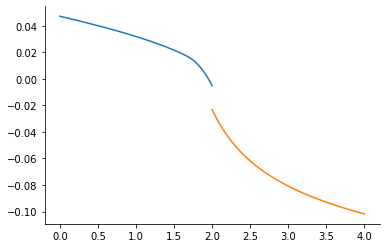

In [75]:
ϕ_bound = np.average(ϕ_carb_list, axis=0, weights=πᵈ_carb[:,-1])
plt.plot(y_grid[:numy_bar+1], ϕ_carb)
plt.plot(y_grid[numy_bar:], ϕ_bound[numy_bar:])

In [76]:
yt_carb, et_carb, πᵈt_carb, πᶜt_carb, ιt_carb, ht_carb = simulate_jump(y_grid[:numy_bar+1], ems_carb, πᶜ_carb, πᵈ_carb, ι_carb, h_carb,  θcarb_list)

Text(0.5, 0, 'years')

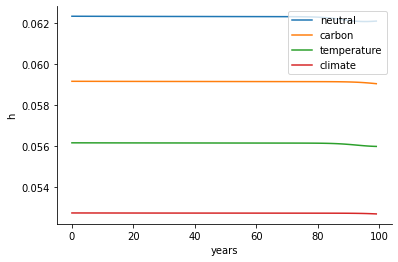

In [77]:
plt.plot(ht[ht>0], label="neutral")
plt.plot(ht_carb[ht_carb>0], label = "carbon")
plt.plot(ht_temp[ht_temp>0], label = "temperature")
plt.plot(ht_avg[ht_avg>0], label = "climate")
plt.legend()
plt.ylabel('h')
plt.xlabel('years')
# plt.ylim(0,0.0035)

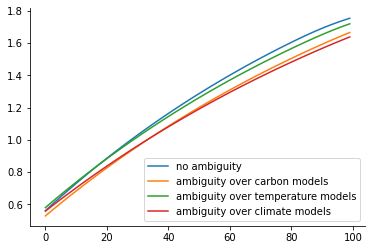

In [83]:
plt.plot(yt[yt>0],label="no ambiguity")
plt.plot(yt_carb[yt_carb>0],label="ambiguity over carbon models")
plt.plot(yt_temp[yt_temp>0],label="ambiguity over temperature models")
plt.plot(yt_avg[yt_avg>0],label="ambiguity over climate models")
plt.legend()

(0.0, 100.0)

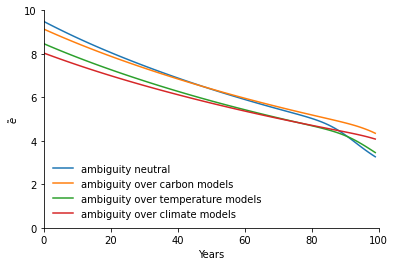

In [86]:
plt.plot(et[et>0], label="ambiguity neutral")
plt.plot(et_carb[et_carb>0], label="ambiguity over carbon models")
plt.plot(et_temp[et_temp>0], label="ambiguity over temperature models")
plt.plot(et_avg[et_avg>0], label="ambiguity over climate models")
plt.legend(frameon=False)
plt.ylabel("$\\tilde e$")
plt.xlabel('Years')
plt.ylim(0,10)
plt.xlim(0,100)
# plt.savefig("../figures/ems_partition_damage.png", facecolor='w', edgecolor='w',bbox_inches="tight")

## Approach two:
$$
\begin{aligned}
0 = \max_{\tilde e} \min_{g_j: \sum_j g_j \hat \pi_j=1} &- \delta \phi(y) + \delta\eta \log\tilde e \\
& +  \frac{d\phi}{dy} \theta \tilde e  + \frac{1}{2} \frac{d^2 \phi}{dy^2}(\tilde e)^2 |\sigma_y|^2\\
& + (\eta -1)(\gamma_1 + \gamma_2 y) \tilde e \theta + \mathcal{I}(y)\sum_j\hat\pi_j g_j\left[\phi_j(y) - \phi(y) \right] \\
&  + \xi_m \mathcal{I}(y) \sum_j \hat\pi_j g_j \log g_j
\end{aligned}
$$
Minimize over $g_j$ gives:
$$
g_j = \cfrac{\exp\left( \frac{1}{\xi_m} [\phi(y) - \phi_j(y)] \right)}{\sum_{j} \hat\pi_j \exp\left( \frac{1}{\xi_m} [\phi(y) - \phi_j(y)] \right)}
$$
Plug back in:
$$
\begin{aligned}
0 = \max_{\tilde e} &- \delta \phi(y) + \delta\eta \log\tilde e \\
& +  \frac{d\phi}{dy} \theta \tilde e  + \frac{1}{2} \frac{d^2 \phi}{dy^2}(\tilde e)^2 |\sigma_y|^2\\
& + (\eta -1)(\gamma_1 + \gamma_2 y) \tilde e \theta  \\
&   - \xi_m \mathcal{I}(y) \log \left(\sum_j \hat\pi_j \exp\left( \frac{1}{\xi_m} [\phi(y) - \phi_j(y)] \right) \right)
\end{aligned}
$$

First order condition for $\tilde e$:
$$
 \frac{d^2 \phi}{dy^2} |\sigma_y|^2 (\tilde e)^2 + [\frac{d\phi(y)}{dy} + (\eta -1)(\gamma_1 + \gamma_2 y)]\theta \tilde e + \delta \eta = 0
$$

In [ ]:
y_grid_cap = y_grid[:numy_bar+1]

In [ ]:
# solve for approach 2
ς = 1/10
ξₘ = 0.1
dmg_weight = np.array([0.5, 0.5])
dΛ = γ1 + γ2*y_grid_cap
ϕ_bound = np.average(ϕ_list, axis=0, weights=dmg_weight)
tol = 1e-8
ϕ = - δ*η*y_grid_cap**2
dy = y_grid_cap[1] - y_grid_cap[0]
ems = δ*η
ems_old = ems
episode = 0
ϵ = .3
lhs_error = 1
πo = np.ones(len(γ3_list))/len(γ3_list)
while lhs_error > tol:
    ϕ_old = ϕ.copy()
    dϕdy = derivative_1d(ϕ, 1, dy, True)
    dϕdyy = derivative_1d(ϕ, 2, dy, True)
    # update control
    temp = dϕdy + (η-1)*dΛ
    a = dϕdyy*σy**2  
    b = temp*θ
    c = δ*η
    Δ = b**2 - 4*a*c
    Δ[Δ < 0] = 0
    root1 = (-b - np.sqrt(Δ))/(2*a)
    root2 = (-b + np.sqrt(Δ))/(2*a)
    if root1.all() > 0:
        ems_new = root1
    else:
        ems_new = root2
    ems_new[ems_new < 1e-15] = 1e-15
    ems = ems_new*1 + ems_old*0.
    inside = np.array([πo[i]*np.exp(1/ξₘ*(ϕ - ϕ_list[i][:numy_bar+1])) for i in range(len(γ3_list))])
    sum_inside = np.sum(inside, axis=0)
    # coefficients
    A = -δ*np.ones(y_grid_cap.shape)
    By = θ*ems
    Cyy = ems**2*σy**2/2
    D = δ*η*np.log(ems) + (η-1)*dΛ*θ*ems - ξₘ*get_intensity(y_grid_cap,ς)*np.log(sum_inside)
    # solver
    ϕ_new = solve_ode(A, By, Cyy, D, y_grid_cap, ϕ, ϵ, (True, ϕ_bound[numy_bar]))
    rhs = -δ*ϕ_new + By*dϕdy + Cyy*dϕdyy + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
    ϕ = ϕ_new
    episode += 1
    ems_old = ems
    print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))

In [ ]:
plt.plot(y_grid_cap, ϕ)
plt.plot(y_grid[numy_bar:], ϕ_bound[numy_bar:])

In [ ]:
plt.plot(ems)